In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 738)
(657450, 8)
validation
(74368, 738)
(74368, 8)
test
(91684, 738)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:48 - loss: 2.0973 - STD: 0.0925 - MAE: 0.2159

 4/66 [>.............................] - ETA: 1s - loss: 1.6237 - STD: 0.1355 - MAE: 0.1774  

 5/66 [=>............................] - ETA: 1s - loss: 1.5750 - STD: 0.1544 - MAE: 0.1683

 6/66 [=>............................] - ETA: 2s - loss: 1.5431 - STD: 0.1686 - MAE: 0.1616

 7/66 [==>...........................] - ETA: 2s - loss: 1.5157 - STD: 0.1788 - MAE: 0.1566

 8/66 [==>...........................] - ETA: 2s - loss: 1.4954 - STD: 0.1857 - MAE: 0.1532

 9/66 [===>..........................] - ETA: 2s - loss: 1.4761 - STD: 0.1900 - MAE: 0.1508

10/66 [===>..........................] - ETA: 2s - loss: 1.4610 - STD: 0.1923 - MAE: 0.1494

11/66 [====>.........................] - ETA: 2s - loss: 1.4490 - STD: 0.1930 - MAE: 0.1488

12/66 [====>.........................] - ETA: 2s - loss: 1.4396 - STD: 0.1927 - MAE: 0.1486

13/66 [====>.........................] - ETA: 2s - loss: 1.4312 - STD: 0.1917 - MAE: 0.1488

14/66 [=====>........................] - ETA: 2s - loss: 1.4230 - STD: 0.1904 - MAE: 0.1490

15/66 [=====>........................] - ETA: 2s - loss: 1.4157 - STD: 0.1890 - MAE: 0.1493

16/66 [======>.......................] - ETA: 2s - loss: 1.4107 - STD: 0.1878 - MAE: 0.1496

17/66 [======>.......................] - ETA: 2s - loss: 1.4055 - STD: 0.1869 - MAE: 0.1497

18/66 [=======>......................] - ETA: 2s - loss: 1.4004 - STD: 0.1865 - MAE: 0.1498

19/66 [=======>......................] - ETA: 2s - loss: 1.3958 - STD: 0.1864 - MAE: 0.1496

20/66 [========>.....................] - ETA: 2s - loss: 1.3925 - STD: 0.1866 - MAE: 0.1495

21/66 [========>.....................] - ETA: 2s - loss: 1.3893 - STD: 0.1872 - MAE: 0.1492

22/66 [=========>....................] - ETA: 2s - loss: 1.3854 - STD: 0.1879 - MAE: 0.1488

23/66 [=========>....................] - ETA: 3s - loss: 1.3828 - STD: 0.1888 - MAE: 0.1483

26/66 [==========>...................] - ETA: 3s - loss: 1.3767 - STD: 0.1911 - MAE: 0.1473

28/66 [===========>..................] - ETA: 3s - loss: 1.3718 - STD: 0.1920 - MAE: 0.1468

29/66 [============>.................] - ETA: 2s - loss: 1.3693 - STD: 0.1922 - MAE: 0.1466

30/66 [============>.................] - ETA: 2s - loss: 1.3676 - STD: 0.1923 - MAE: 0.1465

31/66 [=============>................] - ETA: 2s - loss: 1.3665 - STD: 0.1922 - MAE: 0.1465

32/66 [=============>................] - ETA: 2s - loss: 1.3654 - STD: 0.1921 - MAE: 0.1465

33/66 [==============>...............] - ETA: 2s - loss: 1.3639 - STD: 0.1919 - MAE: 0.1465

34/66 [==============>...............] - ETA: 2s - loss: 1.3622 - STD: 0.1917 - MAE: 0.1466

35/66 [==============>...............] - ETA: 2s - loss: 1.3611 - STD: 0.1915 - MAE: 0.1466

36/66 [===============>..............] - ETA: 2s - loss: 1.3597 - STD: 0.1913 - MAE: 0.1467

37/66 [===============>..............] - ETA: 2s - loss: 1.3582 - STD: 0.1912 - MAE: 0.1467

38/66 [================>.............] - ETA: 2s - loss: 1.3575 - STD: 0.1911 - MAE: 0.1467

39/66 [================>.............] - ETA: 1s - loss: 1.3563 - STD: 0.1911 - MAE: 0.1467

40/66 [=================>............] - ETA: 1s - loss: 1.3551 - STD: 0.1911 - MAE: 0.1466

41/66 [=================>............] - ETA: 1s - loss: 1.3535 - STD: 0.1912 - MAE: 0.1465

42/66 [==================>...........] - ETA: 1s - loss: 1.3524 - STD: 0.1914 - MAE: 0.1464

43/66 [==================>...........] - ETA: 1s - loss: 1.3515 - STD: 0.1915 - MAE: 0.1464

44/66 [===================>..........] - ETA: 1s - loss: 1.3506 - STD: 0.1917 - MAE: 0.1463

46/66 [===================>..........] - ETA: 1s - loss: 1.3494 - STD: 0.1919 - MAE: 0.1462

47/66 [====================>.........] - ETA: 1s - loss: 1.3483 - STD: 0.1920 - MAE: 0.1461

48/66 [====================>.........] - ETA: 1s - loss: 1.3473 - STD: 0.1920 - MAE: 0.1460

49/66 [=====================>........] - ETA: 1s - loss: 1.3466 - STD: 0.1920 - MAE: 0.1460

50/66 [=====================>........] - ETA: 1s - loss: 1.3457 - STD: 0.1920 - MAE: 0.1460

51/66 [======================>.......] - ETA: 1s - loss: 1.3452 - STD: 0.1920 - MAE: 0.1460

52/66 [======================>.......] - ETA: 0s - loss: 1.3448 - STD: 0.1920 - MAE: 0.1460

53/66 [=======================>......] - ETA: 0s - loss: 1.3442 - STD: 0.1919 - MAE: 0.1460

54/66 [=======================>......] - ETA: 0s - loss: 1.3435 - STD: 0.1919 - MAE: 0.1460

55/66 [========================>.....] - ETA: 0s - loss: 1.3424 - STD: 0.1918 - MAE: 0.1460

56/66 [========================>.....] - ETA: 0s - loss: 1.3417 - STD: 0.1918 - MAE: 0.1460

57/66 [========================>.....] - ETA: 0s - loss: 1.3405 - STD: 0.1918 - MAE: 0.1460

58/66 [=========================>....] - ETA: 0s - loss: 1.3401 - STD: 0.1918 - MAE: 0.1459

59/66 [=========================>....] - ETA: 0s - loss: 1.3396 - STD: 0.1919 - MAE: 0.1459

60/66 [==========================>...] - ETA: 0s - loss: 1.3392 - STD: 0.1919 - MAE: 0.1459

61/66 [==========================>...] - ETA: 0s - loss: 1.3387 - STD: 0.1919 - MAE: 0.1459

62/66 [===========================>..] - ETA: 0s - loss: 1.3382 - STD: 0.1920 - MAE: 0.1458

63/66 [===========================>..] - ETA: 0s - loss: 1.3374 - STD: 0.1920 - MAE: 0.1458

64/66 [============================>.] - ETA: 0s - loss: 1.3369 - STD: 0.1920 - MAE: 0.1458

65/66 [============================>.] - ETA: 0s - loss: 1.3363 - STD: 0.1920 - MAE: 0.1457

66/66 [==============================] - ETA: 0s - loss: 1.3361 - STD: 0.1920 - MAE: 0.1457

66/66 [==============================] - 7s 75ms/step - loss: 1.3361 - STD: 0.1920 - MAE: 0.1457 - val_loss: 1.2444 - val_STD: 0.1916 - val_MAE: 0.1420


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3098 - STD: 0.1916 - MAE: 0.1448

 2/66 [..............................] - ETA: 3s - loss: 1.3033 - STD: 0.1914 - MAE: 0.1449

 3/66 [>.............................] - ETA: 3s - loss: 1.3061 - STD: 0.1913 - MAE: 0.1451

 4/66 [>.............................] - ETA: 3s - loss: 1.3065 - STD: 0.1912 - MAE: 0.1451

 5/66 [=>............................] - ETA: 3s - loss: 1.3094 - STD: 0.1912 - MAE: 0.1454

 6/66 [=>............................] - ETA: 3s - loss: 1.3037 - STD: 0.1911 - MAE: 0.1451

 7/66 [==>...........................] - ETA: 3s - loss: 1.3048 - STD: 0.1912 - MAE: 0.1451

 8/66 [==>...........................] - ETA: 3s - loss: 1.3069 - STD: 0.1912 - MAE: 0.1453

 9/66 [===>..........................] - ETA: 2s - loss: 1.3088 - STD: 0.1913 - MAE: 0.1453

11/66 [====>.........................] - ETA: 2s - loss: 1.3099 - STD: 0.1913 - MAE: 0.1454

12/66 [====>.........................] - ETA: 2s - loss: 1.3097 - STD: 0.1912 - MAE: 0.1454

13/66 [====>.........................] - ETA: 2s - loss: 1.3080 - STD: 0.1911 - MAE: 0.1453

14/66 [=====>........................] - ETA: 2s - loss: 1.3080 - STD: 0.1911 - MAE: 0.1453

15/66 [=====>........................] - ETA: 2s - loss: 1.3093 - STD: 0.1911 - MAE: 0.1454

16/66 [======>.......................] - ETA: 2s - loss: 1.3089 - STD: 0.1912 - MAE: 0.1454

17/66 [======>.......................] - ETA: 2s - loss: 1.3085 - STD: 0.1912 - MAE: 0.1453

18/66 [=======>......................] - ETA: 2s - loss: 1.3082 - STD: 0.1912 - MAE: 0.1453

19/66 [=======>......................] - ETA: 2s - loss: 1.3083 - STD: 0.1913 - MAE: 0.1453

20/66 [========>.....................] - ETA: 2s - loss: 1.3087 - STD: 0.1913 - MAE: 0.1453

21/66 [========>.....................] - ETA: 2s - loss: 1.3082 - STD: 0.1914 - MAE: 0.1452

22/66 [=========>....................] - ETA: 2s - loss: 1.3089 - STD: 0.1914 - MAE: 0.1453

23/66 [=========>....................] - ETA: 2s - loss: 1.3082 - STD: 0.1915 - MAE: 0.1452

24/66 [=========>....................] - ETA: 2s - loss: 1.3076 - STD: 0.1915 - MAE: 0.1452

25/66 [==========>...................] - ETA: 2s - loss: 1.3085 - STD: 0.1915 - MAE: 0.1452

26/66 [==========>...................] - ETA: 2s - loss: 1.3085 - STD: 0.1916 - MAE: 0.1452

27/66 [===========>..................] - ETA: 2s - loss: 1.3080 - STD: 0.1916 - MAE: 0.1452

28/66 [===========>..................] - ETA: 2s - loss: 1.3076 - STD: 0.1916 - MAE: 0.1451

29/66 [============>.................] - ETA: 1s - loss: 1.3070 - STD: 0.1916 - MAE: 0.1451

30/66 [============>.................] - ETA: 1s - loss: 1.3064 - STD: 0.1916 - MAE: 0.1451

31/66 [=============>................] - ETA: 1s - loss: 1.3070 - STD: 0.1916 - MAE: 0.1451

33/66 [==============>...............] - ETA: 1s - loss: 1.3068 - STD: 0.1917 - MAE: 0.1450

34/66 [==============>...............] - ETA: 1s - loss: 1.3064 - STD: 0.1917 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3066 - STD: 0.1917 - MAE: 0.1450

36/66 [===============>..............] - ETA: 1s - loss: 1.3065 - STD: 0.1917 - MAE: 0.1450

37/66 [===============>..............] - ETA: 1s - loss: 1.3066 - STD: 0.1917 - MAE: 0.1450

38/66 [================>.............] - ETA: 1s - loss: 1.3065 - STD: 0.1916 - MAE: 0.1450

39/66 [================>.............] - ETA: 1s - loss: 1.3067 - STD: 0.1916 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3062 - STD: 0.1916 - MAE: 0.1450

41/66 [=================>............] - ETA: 1s - loss: 1.3059 - STD: 0.1916 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3058 - STD: 0.1916 - MAE: 0.1450

43/66 [==================>...........] - ETA: 1s - loss: 1.3055 - STD: 0.1916 - MAE: 0.1450

44/66 [===================>..........] - ETA: 1s - loss: 1.3050 - STD: 0.1916 - MAE: 0.1449

45/66 [===================>..........] - ETA: 1s - loss: 1.3042 - STD: 0.1916 - MAE: 0.1449

46/66 [===================>..........] - ETA: 1s - loss: 1.3038 - STD: 0.1917 - MAE: 0.1449

47/66 [====================>.........] - ETA: 1s - loss: 1.3035 - STD: 0.1917 - MAE: 0.1448

48/66 [====================>.........] - ETA: 0s - loss: 1.3029 - STD: 0.1917 - MAE: 0.1448

49/66 [=====================>........] - ETA: 0s - loss: 1.3026 - STD: 0.1918 - MAE: 0.1448

50/66 [=====================>........] - ETA: 0s - loss: 1.3022 - STD: 0.1918 - MAE: 0.1448

51/66 [======================>.......] - ETA: 0s - loss: 1.3019 - STD: 0.1918 - MAE: 0.1447

52/66 [======================>.......] - ETA: 0s - loss: 1.3018 - STD: 0.1917 - MAE: 0.1447

53/66 [=======================>......] - ETA: 0s - loss: 1.3011 - STD: 0.1917 - MAE: 0.1447

54/66 [=======================>......] - ETA: 0s - loss: 1.3006 - STD: 0.1918 - MAE: 0.1447

55/66 [========================>.....] - ETA: 0s - loss: 1.3002 - STD: 0.1918 - MAE: 0.1446

56/66 [========================>.....] - ETA: 0s - loss: 1.3000 - STD: 0.1918 - MAE: 0.1446

57/66 [========================>.....] - ETA: 0s - loss: 1.2998 - STD: 0.1918 - MAE: 0.1446

58/66 [=========================>....] - ETA: 0s - loss: 1.2994 - STD: 0.1917 - MAE: 0.1446

59/66 [=========================>....] - ETA: 0s - loss: 1.2987 - STD: 0.1917 - MAE: 0.1446

60/66 [==========================>...] - ETA: 0s - loss: 1.2978 - STD: 0.1917 - MAE: 0.1446

61/66 [==========================>...] - ETA: 0s - loss: 1.2968 - STD: 0.1918 - MAE: 0.1445

62/66 [===========================>..] - ETA: 0s - loss: 1.2962 - STD: 0.1919 - MAE: 0.1444

63/66 [===========================>..] - ETA: 0s - loss: 1.2958 - STD: 0.1921 - MAE: 0.1443

64/66 [============================>.] - ETA: 0s - loss: 1.2953 - STD: 0.1922 - MAE: 0.1443

65/66 [============================>.] - ETA: 0s - loss: 1.2950 - STD: 0.1921 - MAE: 0.1443

66/66 [==============================] - ETA: 0s - loss: 1.2946 - STD: 0.1920 - MAE: 0.1443

66/66 [==============================] - 4s 56ms/step - loss: 1.2946 - STD: 0.1920 - MAE: 0.1443 - val_loss: 1.1816 - val_STD: 0.1850 - val_MAE: 0.1408


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2766 - STD: 0.1882 - MAE: 0.1450

 3/66 [>.............................] - ETA: 2s - loss: 1.2509 - STD: 0.1962 - MAE: 0.1406

 4/66 [>.............................] - ETA: 3s - loss: 1.2509 - STD: 0.1982 - MAE: 0.1399

 5/66 [=>............................] - ETA: 3s - loss: 1.2501 - STD: 0.1980 - MAE: 0.1400

 6/66 [=>............................] - ETA: 3s - loss: 1.2515 - STD: 0.1964 - MAE: 0.1407

 7/66 [==>...........................] - ETA: 3s - loss: 1.2503 - STD: 0.1951 - MAE: 0.1411

 8/66 [==>...........................] - ETA: 2s - loss: 1.2483 - STD: 0.1951 - MAE: 0.1411

 9/66 [===>..........................] - ETA: 2s - loss: 1.2475 - STD: 0.1961 - MAE: 0.1406

10/66 [===>..........................] - ETA: 2s - loss: 1.2473 - STD: 0.1970 - MAE: 0.1403

11/66 [====>.........................] - ETA: 3s - loss: 1.2441 - STD: 0.1972 - MAE: 0.1401

12/66 [====>.........................] - ETA: 3s - loss: 1.2429 - STD: 0.1969 - MAE: 0.1401

13/66 [====>.........................] - ETA: 3s - loss: 1.2425 - STD: 0.1968 - MAE: 0.1402

15/66 [=====>........................] - ETA: 2s - loss: 1.2390 - STD: 0.1972 - MAE: 0.1399

16/66 [======>.......................] - ETA: 2s - loss: 1.2381 - STD: 0.1973 - MAE: 0.1398

17/66 [======>.......................] - ETA: 2s - loss: 1.2369 - STD: 0.1974 - MAE: 0.1398

19/66 [=======>......................] - ETA: 2s - loss: 1.2352 - STD: 0.1976 - MAE: 0.1396

20/66 [========>.....................] - ETA: 2s - loss: 1.2331 - STD: 0.1976 - MAE: 0.1396

21/66 [========>.....................] - ETA: 2s - loss: 1.2318 - STD: 0.1977 - MAE: 0.1395

23/66 [=========>....................] - ETA: 2s - loss: 1.2290 - STD: 0.1979 - MAE: 0.1393

24/66 [=========>....................] - ETA: 2s - loss: 1.2274 - STD: 0.1979 - MAE: 0.1392

25/66 [==========>...................] - ETA: 2s - loss: 1.2268 - STD: 0.1982 - MAE: 0.1391

27/66 [===========>..................] - ETA: 2s - loss: 1.2258 - STD: 0.1980 - MAE: 0.1392

28/66 [===========>..................] - ETA: 2s - loss: 1.2241 - STD: 0.1984 - MAE: 0.1390

29/66 [============>.................] - ETA: 2s - loss: 1.2235 - STD: 0.1985 - MAE: 0.1389

30/66 [============>.................] - ETA: 1s - loss: 1.2220 - STD: 0.1982 - MAE: 0.1390

32/66 [=============>................] - ETA: 1s - loss: 1.2203 - STD: 0.1988 - MAE: 0.1387

34/66 [==============>...............] - ETA: 1s - loss: 1.2188 - STD: 0.1986 - MAE: 0.1387

35/66 [==============>...............] - ETA: 1s - loss: 1.2180 - STD: 0.1991 - MAE: 0.1385

36/66 [===============>..............] - ETA: 1s - loss: 1.2170 - STD: 0.1993 - MAE: 0.1384

37/66 [===============>..............] - ETA: 1s - loss: 1.2165 - STD: 0.1990 - MAE: 0.1386

38/66 [================>.............] - ETA: 1s - loss: 1.2152 - STD: 0.1989 - MAE: 0.1385

39/66 [================>.............] - ETA: 1s - loss: 1.2144 - STD: 0.1993 - MAE: 0.1383

40/66 [=================>............] - ETA: 1s - loss: 1.2132 - STD: 0.1995 - MAE: 0.1382

41/66 [=================>............] - ETA: 1s - loss: 1.2125 - STD: 0.1994 - MAE: 0.1383

42/66 [==================>...........] - ETA: 1s - loss: 1.2118 - STD: 0.1992 - MAE: 0.1383

43/66 [==================>...........] - ETA: 1s - loss: 1.2113 - STD: 0.1994 - MAE: 0.1382

45/66 [===================>..........] - ETA: 1s - loss: 1.2100 - STD: 0.1997 - MAE: 0.1381

46/66 [===================>..........] - ETA: 1s - loss: 1.2092 - STD: 0.1995 - MAE: 0.1381

47/66 [====================>.........] - ETA: 1s - loss: 1.2087 - STD: 0.1995 - MAE: 0.1381

48/66 [====================>.........] - ETA: 0s - loss: 1.2078 - STD: 0.1998 - MAE: 0.1380

49/66 [=====================>........] - ETA: 0s - loss: 1.2073 - STD: 0.2000 - MAE: 0.1379

50/66 [=====================>........] - ETA: 0s - loss: 1.2066 - STD: 0.1999 - MAE: 0.1379

51/66 [======================>.......] - ETA: 0s - loss: 1.2063 - STD: 0.1998 - MAE: 0.1380

52/66 [======================>.......] - ETA: 0s - loss: 1.2056 - STD: 0.1998 - MAE: 0.1379

53/66 [=======================>......] - ETA: 0s - loss: 1.2052 - STD: 0.2000 - MAE: 0.1379

54/66 [=======================>......] - ETA: 0s - loss: 1.2042 - STD: 0.2000 - MAE: 0.1378

55/66 [========================>.....] - ETA: 0s - loss: 1.2033 - STD: 0.2000 - MAE: 0.1378

56/66 [========================>.....] - ETA: 0s - loss: 1.2026 - STD: 0.2000 - MAE: 0.1378

57/66 [========================>.....] - ETA: 0s - loss: 1.2023 - STD: 0.2002 - MAE: 0.1377

59/66 [=========================>....] - ETA: 0s - loss: 1.2009 - STD: 0.2003 - MAE: 0.1376

61/66 [==========================>...] - ETA: 0s - loss: 1.1994 - STD: 0.2003 - MAE: 0.1376

63/66 [===========================>..] - ETA: 0s - loss: 1.1980 - STD: 0.2005 - MAE: 0.1374

65/66 [============================>.] - ETA: 0s - loss: 1.1970 - STD: 0.2005 - MAE: 0.1374

66/66 [==============================] - 4s 56ms/step - loss: 1.1967 - STD: 0.2007 - MAE: 0.1374 - val_loss: 1.0700 - val_STD: 0.1934 - val_MAE: 0.1331


Epoch 4/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1534 - STD: 0.2033 - MAE: 0.1350

 2/66 [..............................] - ETA: 3s - loss: 1.1619 - STD: 0.2005 - MAE: 0.1365

 3/66 [>.............................] - ETA: 3s - loss: 1.1627 - STD: 0.2012 - MAE: 0.1363

 4/66 [>.............................] - ETA: 3s - loss: 1.1620 - STD: 0.2030 - MAE: 0.1357

 5/66 [=>............................] - ETA: 3s - loss: 1.1594 - STD: 0.2032 - MAE: 0.1355

 6/66 [=>............................] - ETA: 3s - loss: 1.1559 - STD: 0.2025 - MAE: 0.1357

 7/66 [==>...........................] - ETA: 3s - loss: 1.1581 - STD: 0.2020 - MAE: 0.1360

 8/66 [==>...........................] - ETA: 3s - loss: 1.1555 - STD: 0.2020 - MAE: 0.1358

 9/66 [===>..........................] - ETA: 3s - loss: 1.1560 - STD: 0.2025 - MAE: 0.1356

10/66 [===>..........................] - ETA: 3s - loss: 1.1563 - STD: 0.2024 - MAE: 0.1357

11/66 [====>.........................] - ETA: 2s - loss: 1.1576 - STD: 0.2025 - MAE: 0.1357

12/66 [====>.........................] - ETA: 2s - loss: 1.1579 - STD: 0.2029 - MAE: 0.1356

13/66 [====>.........................] - ETA: 2s - loss: 1.1557 - STD: 0.2034 - MAE: 0.1353

14/66 [=====>........................] - ETA: 2s - loss: 1.1552 - STD: 0.2035 - MAE: 0.1353

15/66 [=====>........................] - ETA: 2s - loss: 1.1543 - STD: 0.2032 - MAE: 0.1354

16/66 [======>.......................] - ETA: 2s - loss: 1.1540 - STD: 0.2031 - MAE: 0.1354

17/66 [======>.......................] - ETA: 2s - loss: 1.1537 - STD: 0.2030 - MAE: 0.1355

18/66 [=======>......................] - ETA: 2s - loss: 1.1523 - STD: 0.2029 - MAE: 0.1354

19/66 [=======>......................] - ETA: 2s - loss: 1.1515 - STD: 0.2029 - MAE: 0.1354

21/66 [========>.....................] - ETA: 2s - loss: 1.1511 - STD: 0.2034 - MAE: 0.1352

22/66 [=========>....................] - ETA: 2s - loss: 1.1502 - STD: 0.2034 - MAE: 0.1352

23/66 [=========>....................] - ETA: 2s - loss: 1.1489 - STD: 0.2035 - MAE: 0.1351

24/66 [=========>....................] - ETA: 2s - loss: 1.1485 - STD: 0.2037 - MAE: 0.1350

25/66 [==========>...................] - ETA: 2s - loss: 1.1481 - STD: 0.2037 - MAE: 0.1350

26/66 [==========>...................] - ETA: 2s - loss: 1.1483 - STD: 0.2034 - MAE: 0.1351

27/66 [===========>..................] - ETA: 2s - loss: 1.1475 - STD: 0.2034 - MAE: 0.1351

28/66 [===========>..................] - ETA: 2s - loss: 1.1471 - STD: 0.2036 - MAE: 0.1350

29/66 [============>.................] - ETA: 1s - loss: 1.1463 - STD: 0.2036 - MAE: 0.1350

30/66 [============>.................] - ETA: 1s - loss: 1.1458 - STD: 0.2035 - MAE: 0.1350

31/66 [=============>................] - ETA: 1s - loss: 1.1456 - STD: 0.2036 - MAE: 0.1350

32/66 [=============>................] - ETA: 1s - loss: 1.1448 - STD: 0.2037 - MAE: 0.1349

33/66 [==============>...............] - ETA: 1s - loss: 1.1442 - STD: 0.2036 - MAE: 0.1349

34/66 [==============>...............] - ETA: 1s - loss: 1.1438 - STD: 0.2035 - MAE: 0.1349

35/66 [==============>...............] - ETA: 1s - loss: 1.1438 - STD: 0.2036 - MAE: 0.1349

36/66 [===============>..............] - ETA: 1s - loss: 1.1430 - STD: 0.2037 - MAE: 0.1349

38/66 [================>.............] - ETA: 1s - loss: 1.1419 - STD: 0.2035 - MAE: 0.1349

39/66 [================>.............] - ETA: 1s - loss: 1.1411 - STD: 0.2036 - MAE: 0.1349

40/66 [=================>............] - ETA: 1s - loss: 1.1405 - STD: 0.2036 - MAE: 0.1348

41/66 [=================>............] - ETA: 1s - loss: 1.1402 - STD: 0.2035 - MAE: 0.1348

42/66 [==================>...........] - ETA: 1s - loss: 1.1393 - STD: 0.2036 - MAE: 0.1348

43/66 [==================>...........] - ETA: 1s - loss: 1.1389 - STD: 0.2037 - MAE: 0.1347

44/66 [===================>..........] - ETA: 1s - loss: 1.1383 - STD: 0.2035 - MAE: 0.1348

45/66 [===================>..........] - ETA: 1s - loss: 1.1375 - STD: 0.2035 - MAE: 0.1347

46/66 [===================>..........] - ETA: 1s - loss: 1.1369 - STD: 0.2038 - MAE: 0.1346

47/66 [====================>.........] - ETA: 1s - loss: 1.1363 - STD: 0.2036 - MAE: 0.1346

48/66 [====================>.........] - ETA: 0s - loss: 1.1354 - STD: 0.2035 - MAE: 0.1346

49/66 [=====================>........] - ETA: 0s - loss: 1.1344 - STD: 0.2037 - MAE: 0.1345

50/66 [=====================>........] - ETA: 0s - loss: 1.1336 - STD: 0.2038 - MAE: 0.1344

51/66 [======================>.......] - ETA: 0s - loss: 1.1330 - STD: 0.2037 - MAE: 0.1344

52/66 [======================>.......] - ETA: 0s - loss: 1.1319 - STD: 0.2037 - MAE: 0.1343

53/66 [=======================>......] - ETA: 0s - loss: 1.1309 - STD: 0.2039 - MAE: 0.1342

54/66 [=======================>......] - ETA: 0s - loss: 1.1299 - STD: 0.2039 - MAE: 0.1342

55/66 [========================>.....] - ETA: 0s - loss: 1.1291 - STD: 0.2038 - MAE: 0.1341

56/66 [========================>.....] - ETA: 0s - loss: 1.1277 - STD: 0.2040 - MAE: 0.1340

57/66 [========================>.....] - ETA: 0s - loss: 1.1268 - STD: 0.2042 - MAE: 0.1339

59/66 [=========================>....] - ETA: 0s - loss: 1.1251 - STD: 0.2041 - MAE: 0.1338

61/66 [==========================>...] - ETA: 0s - loss: 1.1227 - STD: 0.2045 - MAE: 0.1335

63/66 [===========================>..] - ETA: 0s - loss: 1.1204 - STD: 0.2045 - MAE: 0.1334

64/66 [============================>.] - ETA: 0s - loss: 1.1191 - STD: 0.2048 - MAE: 0.1332

65/66 [============================>.] - ETA: 0s - loss: 1.1179 - STD: 0.2049 - MAE: 0.1331

66/66 [==============================] - ETA: 0s - loss: 1.1168 - STD: 0.2049 - MAE: 0.1330

66/66 [==============================] - 4s 56ms/step - loss: 1.1168 - STD: 0.2049 - MAE: 0.1330 - val_loss: 0.9399 - val_STD: 0.2065 - val_MAE: 0.1213


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0501 - STD: 0.2147 - MAE: 0.1256

 2/66 [..............................] - ETA: 3s - loss: 1.0499 - STD: 0.2165 - MAE: 0.1245

 3/66 [>.............................] - ETA: 3s - loss: 1.0480 - STD: 0.2166 - MAE: 0.1244

 4/66 [>.............................] - ETA: 3s - loss: 1.0465 - STD: 0.2138 - MAE: 0.1256

 5/66 [=>............................] - ETA: 3s - loss: 1.0430 - STD: 0.2138 - MAE: 0.1254

 6/66 [=>............................] - ETA: 3s - loss: 1.0402 - STD: 0.2164 - MAE: 0.1242

 7/66 [==>...........................] - ETA: 3s - loss: 1.0400 - STD: 0.2154 - MAE: 0.1246

 8/66 [==>...........................] - ETA: 3s - loss: 1.0400 - STD: 0.2143 - MAE: 0.1251

 9/66 [===>..........................] - ETA: 3s - loss: 1.0375 - STD: 0.2146 - MAE: 0.1249

10/66 [===>..........................] - ETA: 3s - loss: 1.0355 - STD: 0.2159 - MAE: 0.1242

11/66 [====>.........................] - ETA: 2s - loss: 1.0335 - STD: 0.2153 - MAE: 0.1244

12/66 [====>.........................] - ETA: 2s - loss: 1.0322 - STD: 0.2150 - MAE: 0.1244

13/66 [====>.........................] - ETA: 2s - loss: 1.0318 - STD: 0.2158 - MAE: 0.1241

14/66 [=====>........................] - ETA: 2s - loss: 1.0320 - STD: 0.2155 - MAE: 0.1242

15/66 [=====>........................] - ETA: 2s - loss: 1.0316 - STD: 0.2160 - MAE: 0.1240

16/66 [======>.......................] - ETA: 2s - loss: 1.0310 - STD: 0.2158 - MAE: 0.1240

17/66 [======>.......................] - ETA: 2s - loss: 1.0317 - STD: 0.2155 - MAE: 0.1242

18/66 [=======>......................] - ETA: 2s - loss: 1.0307 - STD: 0.2162 - MAE: 0.1238

19/66 [=======>......................] - ETA: 2s - loss: 1.0313 - STD: 0.2162 - MAE: 0.1239

20/66 [========>.....................] - ETA: 2s - loss: 1.0314 - STD: 0.2156 - MAE: 0.1242

21/66 [========>.....................] - ETA: 2s - loss: 1.0307 - STD: 0.2159 - MAE: 0.1240

22/66 [=========>....................] - ETA: 2s - loss: 1.0302 - STD: 0.2164 - MAE: 0.1238

23/66 [=========>....................] - ETA: 2s - loss: 1.0290 - STD: 0.2163 - MAE: 0.1237

24/66 [=========>....................] - ETA: 2s - loss: 1.0278 - STD: 0.2161 - MAE: 0.1238

25/66 [==========>...................] - ETA: 2s - loss: 1.0268 - STD: 0.2164 - MAE: 0.1236

26/66 [==========>...................] - ETA: 2s - loss: 1.0267 - STD: 0.2165 - MAE: 0.1235

27/66 [===========>..................] - ETA: 2s - loss: 1.0254 - STD: 0.2163 - MAE: 0.1236

28/66 [===========>..................] - ETA: 1s - loss: 1.0243 - STD: 0.2164 - MAE: 0.1235

29/66 [============>.................] - ETA: 1s - loss: 1.0236 - STD: 0.2167 - MAE: 0.1233

30/66 [============>.................] - ETA: 1s - loss: 1.0226 - STD: 0.2169 - MAE: 0.1232

31/66 [=============>................] - ETA: 1s - loss: 1.0220 - STD: 0.2168 - MAE: 0.1232

32/66 [=============>................] - ETA: 1s - loss: 1.0215 - STD: 0.2168 - MAE: 0.1232

33/66 [==============>...............] - ETA: 1s - loss: 1.0209 - STD: 0.2169 - MAE: 0.1231

34/66 [==============>...............] - ETA: 1s - loss: 1.0208 - STD: 0.2170 - MAE: 0.1230

35/66 [==============>...............] - ETA: 1s - loss: 1.0202 - STD: 0.2170 - MAE: 0.1230

36/66 [===============>..............] - ETA: 1s - loss: 1.0195 - STD: 0.2170 - MAE: 0.1230

37/66 [===============>..............] - ETA: 1s - loss: 1.0188 - STD: 0.2171 - MAE: 0.1229

38/66 [================>.............] - ETA: 1s - loss: 1.0179 - STD: 0.2172 - MAE: 0.1228

39/66 [================>.............] - ETA: 1s - loss: 1.0167 - STD: 0.2173 - MAE: 0.1227

40/66 [=================>............] - ETA: 1s - loss: 1.0161 - STD: 0.2173 - MAE: 0.1227

41/66 [=================>............] - ETA: 1s - loss: 1.0158 - STD: 0.2175 - MAE: 0.1226

42/66 [==================>...........] - ETA: 1s - loss: 1.0148 - STD: 0.2175 - MAE: 0.1226

43/66 [==================>...........] - ETA: 1s - loss: 1.0141 - STD: 0.2174 - MAE: 0.1226

44/66 [===================>..........] - ETA: 1s - loss: 1.0132 - STD: 0.2176 - MAE: 0.1224

45/66 [===================>..........] - ETA: 1s - loss: 1.0124 - STD: 0.2179 - MAE: 0.1223

46/66 [===================>..........] - ETA: 1s - loss: 1.0117 - STD: 0.2179 - MAE: 0.1222

47/66 [====================>.........] - ETA: 1s - loss: 1.0111 - STD: 0.2179 - MAE: 0.1222

48/66 [====================>.........] - ETA: 0s - loss: 1.0103 - STD: 0.2181 - MAE: 0.1221

49/66 [=====================>........] - ETA: 0s - loss: 1.0098 - STD: 0.2182 - MAE: 0.1220

50/66 [=====================>........] - ETA: 0s - loss: 1.0090 - STD: 0.2181 - MAE: 0.1220

51/66 [======================>.......] - ETA: 0s - loss: 1.0082 - STD: 0.2182 - MAE: 0.1219

53/66 [=======================>......] - ETA: 0s - loss: 1.0069 - STD: 0.2185 - MAE: 0.1217

54/66 [=======================>......] - ETA: 0s - loss: 1.0062 - STD: 0.2184 - MAE: 0.1217

55/66 [========================>.....] - ETA: 0s - loss: 1.0055 - STD: 0.2186 - MAE: 0.1216

56/66 [========================>.....] - ETA: 0s - loss: 1.0046 - STD: 0.2188 - MAE: 0.1215

57/66 [========================>.....] - ETA: 0s - loss: 1.0041 - STD: 0.2188 - MAE: 0.1215

59/66 [=========================>....] - ETA: 0s - loss: 1.0034 - STD: 0.2188 - MAE: 0.1214

60/66 [==========================>...] - ETA: 0s - loss: 1.0028 - STD: 0.2190 - MAE: 0.1213

61/66 [==========================>...] - ETA: 0s - loss: 1.0022 - STD: 0.2191 - MAE: 0.1213

62/66 [===========================>..] - ETA: 0s - loss: 1.0013 - STD: 0.2191 - MAE: 0.1212

63/66 [===========================>..] - ETA: 0s - loss: 1.0010 - STD: 0.2191 - MAE: 0.1212

65/66 [============================>.] - ETA: 0s - loss: 0.9994 - STD: 0.2193 - MAE: 0.1210

66/66 [==============================] - 4s 56ms/step - loss: 0.9986 - STD: 0.2194 - MAE: 0.1210 - val_loss: 0.8660 - val_STD: 0.2231 - val_MAE: 0.1107


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9488 - STD: 0.2313 - MAE: 0.1135

 2/66 [..............................] - ETA: 3s - loss: 0.9559 - STD: 0.2279 - MAE: 0.1153

 3/66 [>.............................] - ETA: 3s - loss: 0.9557 - STD: 0.2256 - MAE: 0.1163

 4/66 [>.............................] - ETA: 3s - loss: 0.9519 - STD: 0.2258 - MAE: 0.1159

 5/66 [=>............................] - ETA: 3s - loss: 0.9532 - STD: 0.2273 - MAE: 0.1154

 6/66 [=>............................] - ETA: 3s - loss: 0.9525 - STD: 0.2261 - MAE: 0.1159

 7/66 [==>...........................] - ETA: 3s - loss: 0.9516 - STD: 0.2254 - MAE: 0.1162

 8/66 [==>...........................] - ETA: 3s - loss: 0.9507 - STD: 0.2256 - MAE: 0.1161

 9/66 [===>..........................] - ETA: 3s - loss: 0.9504 - STD: 0.2263 - MAE: 0.1157

10/66 [===>..........................] - ETA: 3s - loss: 0.9498 - STD: 0.2262 - MAE: 0.1157

12/66 [====>.........................] - ETA: 2s - loss: 0.9508 - STD: 0.2258 - MAE: 0.1159

13/66 [====>.........................] - ETA: 2s - loss: 0.9501 - STD: 0.2263 - MAE: 0.1157

15/66 [=====>........................] - ETA: 2s - loss: 0.9522 - STD: 0.2251 - MAE: 0.1163

17/66 [======>.......................] - ETA: 2s - loss: 0.9506 - STD: 0.2259 - MAE: 0.1159

18/66 [=======>......................] - ETA: 2s - loss: 0.9500 - STD: 0.2256 - MAE: 0.1160

19/66 [=======>......................] - ETA: 2s - loss: 0.9496 - STD: 0.2255 - MAE: 0.1160

20/66 [========>.....................] - ETA: 2s - loss: 0.9498 - STD: 0.2258 - MAE: 0.1159

21/66 [========>.....................] - ETA: 2s - loss: 0.9487 - STD: 0.2257 - MAE: 0.1159

22/66 [=========>....................] - ETA: 2s - loss: 0.9485 - STD: 0.2256 - MAE: 0.1160

23/66 [=========>....................] - ETA: 2s - loss: 0.9485 - STD: 0.2256 - MAE: 0.1160

24/66 [=========>....................] - ETA: 2s - loss: 0.9479 - STD: 0.2258 - MAE: 0.1158

25/66 [==========>...................] - ETA: 2s - loss: 0.9475 - STD: 0.2258 - MAE: 0.1159

26/66 [==========>...................] - ETA: 2s - loss: 0.9478 - STD: 0.2256 - MAE: 0.1160

27/66 [===========>..................] - ETA: 2s - loss: 0.9477 - STD: 0.2259 - MAE: 0.1158

28/66 [===========>..................] - ETA: 2s - loss: 0.9475 - STD: 0.2260 - MAE: 0.1158

29/66 [============>.................] - ETA: 2s - loss: 0.9477 - STD: 0.2257 - MAE: 0.1159

31/66 [=============>................] - ETA: 1s - loss: 0.9472 - STD: 0.2259 - MAE: 0.1158

33/66 [==============>...............] - ETA: 1s - loss: 0.9463 - STD: 0.2259 - MAE: 0.1158

35/66 [==============>...............] - ETA: 1s - loss: 0.9454 - STD: 0.2260 - MAE: 0.1157

37/66 [===============>..............] - ETA: 1s - loss: 0.9444 - STD: 0.2260 - MAE: 0.1157

38/66 [================>.............] - ETA: 1s - loss: 0.9441 - STD: 0.2260 - MAE: 0.1157

39/66 [================>.............] - ETA: 1s - loss: 0.9440 - STD: 0.2262 - MAE: 0.1156

40/66 [=================>............] - ETA: 1s - loss: 0.9438 - STD: 0.2262 - MAE: 0.1156

41/66 [=================>............] - ETA: 1s - loss: 0.9440 - STD: 0.2261 - MAE: 0.1156

42/66 [==================>...........] - ETA: 1s - loss: 0.9435 - STD: 0.2261 - MAE: 0.1156

43/66 [==================>...........] - ETA: 1s - loss: 0.9430 - STD: 0.2261 - MAE: 0.1156

45/66 [===================>..........] - ETA: 1s - loss: 0.9422 - STD: 0.2262 - MAE: 0.1155

46/66 [===================>..........] - ETA: 1s - loss: 0.9415 - STD: 0.2262 - MAE: 0.1155

47/66 [====================>.........] - ETA: 1s - loss: 0.9413 - STD: 0.2262 - MAE: 0.1155

48/66 [====================>.........] - ETA: 0s - loss: 0.9411 - STD: 0.2262 - MAE: 0.1155

49/66 [=====================>........] - ETA: 0s - loss: 0.9408 - STD: 0.2262 - MAE: 0.1155

50/66 [=====================>........] - ETA: 0s - loss: 0.9405 - STD: 0.2263 - MAE: 0.1155

51/66 [======================>.......] - ETA: 0s - loss: 0.9401 - STD: 0.2263 - MAE: 0.1155

52/66 [======================>.......] - ETA: 0s - loss: 0.9399 - STD: 0.2263 - MAE: 0.1154

53/66 [=======================>......] - ETA: 0s - loss: 0.9397 - STD: 0.2263 - MAE: 0.1154

54/66 [=======================>......] - ETA: 0s - loss: 0.9395 - STD: 0.2263 - MAE: 0.1154

55/66 [========================>.....] - ETA: 0s - loss: 0.9391 - STD: 0.2264 - MAE: 0.1154

56/66 [========================>.....] - ETA: 0s - loss: 0.9386 - STD: 0.2264 - MAE: 0.1153

57/66 [========================>.....] - ETA: 0s - loss: 0.9384 - STD: 0.2264 - MAE: 0.1154

58/66 [=========================>....] - ETA: 0s - loss: 0.9380 - STD: 0.2264 - MAE: 0.1154

59/66 [=========================>....] - ETA: 0s - loss: 0.9375 - STD: 0.2265 - MAE: 0.1153

60/66 [==========================>...] - ETA: 0s - loss: 0.9370 - STD: 0.2265 - MAE: 0.1153

61/66 [==========================>...] - ETA: 0s - loss: 0.9367 - STD: 0.2264 - MAE: 0.1153

62/66 [===========================>..] - ETA: 0s - loss: 0.9363 - STD: 0.2265 - MAE: 0.1152

63/66 [===========================>..] - ETA: 0s - loss: 0.9361 - STD: 0.2266 - MAE: 0.1152

64/66 [============================>.] - ETA: 0s - loss: 0.9357 - STD: 0.2265 - MAE: 0.1152

65/66 [============================>.] - ETA: 0s - loss: 0.9353 - STD: 0.2265 - MAE: 0.1152

66/66 [==============================] - ETA: 0s - loss: 0.9348 - STD: 0.2265 - MAE: 0.1152

66/66 [==============================] - 4s 59ms/step - loss: 0.9348 - STD: 0.2265 - MAE: 0.1152 - val_loss: 0.8393 - val_STD: 0.2274 - val_MAE: 0.1082


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9111 - STD: 0.2349 - MAE: 0.1105

 2/66 [..............................] - ETA: 3s - loss: 0.9051 - STD: 0.2297 - MAE: 0.1124

 3/66 [>.............................] - ETA: 3s - loss: 0.9050 - STD: 0.2284 - MAE: 0.1133

 4/66 [>.............................] - ETA: 3s - loss: 0.9046 - STD: 0.2296 - MAE: 0.1127

 5/66 [=>............................] - ETA: 3s - loss: 0.9038 - STD: 0.2298 - MAE: 0.1126

 6/66 [=>............................] - ETA: 3s - loss: 0.9048 - STD: 0.2285 - MAE: 0.1133

 7/66 [==>...........................] - ETA: 3s - loss: 0.9057 - STD: 0.2281 - MAE: 0.1136

 8/66 [==>...........................] - ETA: 3s - loss: 0.9056 - STD: 0.2286 - MAE: 0.1134

 9/66 [===>..........................] - ETA: 3s - loss: 0.9045 - STD: 0.2291 - MAE: 0.1131

10/66 [===>..........................] - ETA: 3s - loss: 0.9053 - STD: 0.2285 - MAE: 0.1134

11/66 [====>.........................] - ETA: 3s - loss: 0.9037 - STD: 0.2285 - MAE: 0.1133

12/66 [====>.........................] - ETA: 3s - loss: 0.9035 - STD: 0.2287 - MAE: 0.1132

13/66 [====>.........................] - ETA: 3s - loss: 0.9042 - STD: 0.2287 - MAE: 0.1133

14/66 [=====>........................] - ETA: 3s - loss: 0.9038 - STD: 0.2284 - MAE: 0.1134

15/66 [=====>........................] - ETA: 3s - loss: 0.9037 - STD: 0.2285 - MAE: 0.1134

16/66 [======>.......................] - ETA: 3s - loss: 0.9042 - STD: 0.2285 - MAE: 0.1134

17/66 [======>.......................] - ETA: 2s - loss: 0.9050 - STD: 0.2284 - MAE: 0.1135

19/66 [=======>......................] - ETA: 2s - loss: 0.9039 - STD: 0.2289 - MAE: 0.1131

20/66 [========>.....................] - ETA: 2s - loss: 0.9036 - STD: 0.2288 - MAE: 0.1132

21/66 [========>.....................] - ETA: 2s - loss: 0.9043 - STD: 0.2283 - MAE: 0.1135

22/66 [=========>....................] - ETA: 2s - loss: 0.9037 - STD: 0.2285 - MAE: 0.1134

23/66 [=========>....................] - ETA: 2s - loss: 0.9033 - STD: 0.2289 - MAE: 0.1132

24/66 [=========>....................] - ETA: 2s - loss: 0.9039 - STD: 0.2287 - MAE: 0.1133

25/66 [==========>...................] - ETA: 2s - loss: 0.9033 - STD: 0.2284 - MAE: 0.1134

26/66 [==========>...................] - ETA: 2s - loss: 0.9036 - STD: 0.2286 - MAE: 0.1133

27/66 [===========>..................] - ETA: 2s - loss: 0.9039 - STD: 0.2288 - MAE: 0.1132

28/66 [===========>..................] - ETA: 2s - loss: 0.9042 - STD: 0.2286 - MAE: 0.1133

29/66 [============>.................] - ETA: 2s - loss: 0.9038 - STD: 0.2284 - MAE: 0.1134

30/66 [============>.................] - ETA: 2s - loss: 0.9033 - STD: 0.2286 - MAE: 0.1134

31/66 [=============>................] - ETA: 2s - loss: 0.9038 - STD: 0.2288 - MAE: 0.1133

32/66 [=============>................] - ETA: 2s - loss: 0.9038 - STD: 0.2285 - MAE: 0.1134

33/66 [==============>...............] - ETA: 1s - loss: 0.9034 - STD: 0.2284 - MAE: 0.1135

34/66 [==============>...............] - ETA: 1s - loss: 0.9036 - STD: 0.2286 - MAE: 0.1134

35/66 [==============>...............] - ETA: 1s - loss: 0.9027 - STD: 0.2287 - MAE: 0.1133

36/66 [===============>..............] - ETA: 1s - loss: 0.9026 - STD: 0.2285 - MAE: 0.1134

37/66 [===============>..............] - ETA: 1s - loss: 0.9025 - STD: 0.2284 - MAE: 0.1134

38/66 [================>.............] - ETA: 1s - loss: 0.9022 - STD: 0.2286 - MAE: 0.1133

39/66 [================>.............] - ETA: 1s - loss: 0.9018 - STD: 0.2287 - MAE: 0.1133

40/66 [=================>............] - ETA: 1s - loss: 0.9016 - STD: 0.2285 - MAE: 0.1134

41/66 [=================>............] - ETA: 1s - loss: 0.9013 - STD: 0.2285 - MAE: 0.1134

42/66 [==================>...........] - ETA: 1s - loss: 0.9011 - STD: 0.2287 - MAE: 0.1133

43/66 [==================>...........] - ETA: 1s - loss: 0.9010 - STD: 0.2288 - MAE: 0.1132

44/66 [===================>..........] - ETA: 1s - loss: 0.9010 - STD: 0.2285 - MAE: 0.1134

45/66 [===================>..........] - ETA: 1s - loss: 0.9004 - STD: 0.2285 - MAE: 0.1133

46/66 [===================>..........] - ETA: 1s - loss: 0.9001 - STD: 0.2288 - MAE: 0.1132

47/66 [====================>.........] - ETA: 1s - loss: 0.9003 - STD: 0.2289 - MAE: 0.1132

48/66 [====================>.........] - ETA: 1s - loss: 0.9004 - STD: 0.2287 - MAE: 0.1133

49/66 [=====================>........] - ETA: 0s - loss: 0.9002 - STD: 0.2286 - MAE: 0.1133

50/66 [=====================>........] - ETA: 0s - loss: 0.9005 - STD: 0.2288 - MAE: 0.1132

51/66 [======================>.......] - ETA: 0s - loss: 0.9007 - STD: 0.2289 - MAE: 0.1132

52/66 [======================>.......] - ETA: 0s - loss: 0.9010 - STD: 0.2287 - MAE: 0.1133

53/66 [=======================>......] - ETA: 0s - loss: 0.9009 - STD: 0.2285 - MAE: 0.1134

54/66 [=======================>......] - ETA: 0s - loss: 0.9006 - STD: 0.2286 - MAE: 0.1134

55/66 [========================>.....] - ETA: 0s - loss: 0.9004 - STD: 0.2288 - MAE: 0.1133

56/66 [========================>.....] - ETA: 0s - loss: 0.9000 - STD: 0.2287 - MAE: 0.1133

57/66 [========================>.....] - ETA: 0s - loss: 0.8998 - STD: 0.2285 - MAE: 0.1134

58/66 [=========================>....] - ETA: 0s - loss: 0.8995 - STD: 0.2285 - MAE: 0.1134

59/66 [=========================>....] - ETA: 0s - loss: 0.8992 - STD: 0.2286 - MAE: 0.1133

60/66 [==========================>...] - ETA: 0s - loss: 0.8988 - STD: 0.2287 - MAE: 0.1133

61/66 [==========================>...] - ETA: 0s - loss: 0.8987 - STD: 0.2286 - MAE: 0.1133

62/66 [===========================>..] - ETA: 0s - loss: 0.8984 - STD: 0.2286 - MAE: 0.1133

63/66 [===========================>..] - ETA: 0s - loss: 0.8981 - STD: 0.2286 - MAE: 0.1133

64/66 [============================>.] - ETA: 0s - loss: 0.8974 - STD: 0.2286 - MAE: 0.1133

65/66 [============================>.] - ETA: 0s - loss: 0.8969 - STD: 0.2287 - MAE: 0.1132

66/66 [==============================] - ETA: 0s - loss: 0.8966 - STD: 0.2287 - MAE: 0.1132

66/66 [==============================] - 4s 61ms/step - loss: 0.8966 - STD: 0.2287 - MAE: 0.1132 - val_loss: 0.8225 - val_STD: 0.2230 - val_MAE: 0.1103


Epoch 8/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8734 - STD: 0.2293 - MAE: 0.1120

 2/66 [..............................] - ETA: 4s - loss: 0.8686 - STD: 0.2297 - MAE: 0.1115

 3/66 [>.............................] - ETA: 3s - loss: 0.8788 - STD: 0.2307 - MAE: 0.1116

 4/66 [>.............................] - ETA: 3s - loss: 0.8790 - STD: 0.2309 - MAE: 0.1115

 5/66 [=>............................] - ETA: 3s - loss: 0.8783 - STD: 0.2306 - MAE: 0.1117

 6/66 [=>............................] - ETA: 3s - loss: 0.8792 - STD: 0.2299 - MAE: 0.1121

 7/66 [==>...........................] - ETA: 3s - loss: 0.8758 - STD: 0.2296 - MAE: 0.1120

 8/66 [==>...........................] - ETA: 3s - loss: 0.8756 - STD: 0.2303 - MAE: 0.1117

 9/66 [===>..........................] - ETA: 3s - loss: 0.8760 - STD: 0.2307 - MAE: 0.1116

10/66 [===>..........................] - ETA: 3s - loss: 0.8756 - STD: 0.2303 - MAE: 0.1117

11/66 [====>.........................] - ETA: 3s - loss: 0.8757 - STD: 0.2298 - MAE: 0.1119

12/66 [====>.........................] - ETA: 3s - loss: 0.8756 - STD: 0.2302 - MAE: 0.1118

13/66 [====>.........................] - ETA: 3s - loss: 0.8754 - STD: 0.2305 - MAE: 0.1116

14/66 [=====>........................] - ETA: 3s - loss: 0.8748 - STD: 0.2304 - MAE: 0.1116

15/66 [=====>........................] - ETA: 3s - loss: 0.8747 - STD: 0.2303 - MAE: 0.1116

16/66 [======>.......................] - ETA: 2s - loss: 0.8744 - STD: 0.2304 - MAE: 0.1116

17/66 [======>.......................] - ETA: 2s - loss: 0.8742 - STD: 0.2304 - MAE: 0.1116

18/66 [=======>......................] - ETA: 2s - loss: 0.8743 - STD: 0.2305 - MAE: 0.1115

19/66 [=======>......................] - ETA: 2s - loss: 0.8746 - STD: 0.2304 - MAE: 0.1116

20/66 [========>.....................] - ETA: 2s - loss: 0.8753 - STD: 0.2305 - MAE: 0.1116

21/66 [========>.....................] - ETA: 2s - loss: 0.8756 - STD: 0.2304 - MAE: 0.1117

22/66 [=========>....................] - ETA: 2s - loss: 0.8755 - STD: 0.2304 - MAE: 0.1116

23/66 [=========>....................] - ETA: 2s - loss: 0.8747 - STD: 0.2305 - MAE: 0.1116

24/66 [=========>....................] - ETA: 2s - loss: 0.8740 - STD: 0.2306 - MAE: 0.1115

25/66 [==========>...................] - ETA: 2s - loss: 0.8737 - STD: 0.2306 - MAE: 0.1114

26/66 [==========>...................] - ETA: 2s - loss: 0.8737 - STD: 0.2305 - MAE: 0.1115

27/66 [===========>..................] - ETA: 2s - loss: 0.8729 - STD: 0.2305 - MAE: 0.1115

28/66 [===========>..................] - ETA: 2s - loss: 0.8727 - STD: 0.2306 - MAE: 0.1114

30/66 [============>.................] - ETA: 2s - loss: 0.8726 - STD: 0.2304 - MAE: 0.1115

31/66 [=============>................] - ETA: 2s - loss: 0.8730 - STD: 0.2304 - MAE: 0.1116

32/66 [=============>................] - ETA: 2s - loss: 0.8731 - STD: 0.2305 - MAE: 0.1116

33/66 [==============>...............] - ETA: 1s - loss: 0.8731 - STD: 0.2304 - MAE: 0.1116

34/66 [==============>...............] - ETA: 1s - loss: 0.8728 - STD: 0.2303 - MAE: 0.1116

35/66 [==============>...............] - ETA: 1s - loss: 0.8725 - STD: 0.2303 - MAE: 0.1116

36/66 [===============>..............] - ETA: 1s - loss: 0.8724 - STD: 0.2304 - MAE: 0.1116

37/66 [===============>..............] - ETA: 1s - loss: 0.8725 - STD: 0.2303 - MAE: 0.1116

38/66 [================>.............] - ETA: 1s - loss: 0.8722 - STD: 0.2303 - MAE: 0.1116

39/66 [================>.............] - ETA: 1s - loss: 0.8718 - STD: 0.2304 - MAE: 0.1116

40/66 [=================>............] - ETA: 1s - loss: 0.8719 - STD: 0.2304 - MAE: 0.1115

41/66 [=================>............] - ETA: 1s - loss: 0.8726 - STD: 0.2304 - MAE: 0.1116

42/66 [==================>...........] - ETA: 1s - loss: 0.8737 - STD: 0.2303 - MAE: 0.1117

43/66 [==================>...........] - ETA: 1s - loss: 0.8739 - STD: 0.2305 - MAE: 0.1116

44/66 [===================>..........] - ETA: 1s - loss: 0.8736 - STD: 0.2305 - MAE: 0.1115

45/66 [===================>..........] - ETA: 1s - loss: 0.8736 - STD: 0.2304 - MAE: 0.1116

46/66 [===================>..........] - ETA: 1s - loss: 0.8741 - STD: 0.2304 - MAE: 0.1117

47/66 [====================>.........] - ETA: 1s - loss: 0.8741 - STD: 0.2304 - MAE: 0.1116

48/66 [====================>.........] - ETA: 1s - loss: 0.8740 - STD: 0.2305 - MAE: 0.1116

49/66 [=====================>........] - ETA: 1s - loss: 0.8738 - STD: 0.2305 - MAE: 0.1116

50/66 [=====================>........] - ETA: 0s - loss: 0.8738 - STD: 0.2304 - MAE: 0.1116

51/66 [======================>.......] - ETA: 0s - loss: 0.8736 - STD: 0.2305 - MAE: 0.1116

52/66 [======================>.......] - ETA: 0s - loss: 0.8738 - STD: 0.2305 - MAE: 0.1116

53/66 [=======================>......] - ETA: 0s - loss: 0.8734 - STD: 0.2304 - MAE: 0.1116

54/66 [=======================>......] - ETA: 0s - loss: 0.8735 - STD: 0.2304 - MAE: 0.1117

55/66 [========================>.....] - ETA: 0s - loss: 0.8738 - STD: 0.2306 - MAE: 0.1116

56/66 [========================>.....] - ETA: 0s - loss: 0.8734 - STD: 0.2306 - MAE: 0.1116

57/66 [========================>.....] - ETA: 0s - loss: 0.8735 - STD: 0.2305 - MAE: 0.1116

58/66 [=========================>....] - ETA: 0s - loss: 0.8737 - STD: 0.2305 - MAE: 0.1116

59/66 [=========================>....] - ETA: 0s - loss: 0.8733 - STD: 0.2305 - MAE: 0.1116

60/66 [==========================>...] - ETA: 0s - loss: 0.8732 - STD: 0.2305 - MAE: 0.1116

61/66 [==========================>...] - ETA: 0s - loss: 0.8729 - STD: 0.2305 - MAE: 0.1116

62/66 [===========================>..] - ETA: 0s - loss: 0.8726 - STD: 0.2305 - MAE: 0.1115

63/66 [===========================>..] - ETA: 0s - loss: 0.8723 - STD: 0.2306 - MAE: 0.1115

64/66 [============================>.] - ETA: 0s - loss: 0.8719 - STD: 0.2307 - MAE: 0.1114

65/66 [============================>.] - ETA: 0s - loss: 0.8718 - STD: 0.2307 - MAE: 0.1114

66/66 [==============================] - ETA: 0s - loss: 0.8717 - STD: 0.2306 - MAE: 0.1114

66/66 [==============================] - 4s 63ms/step - loss: 0.8717 - STD: 0.2306 - MAE: 0.1114 - val_loss: 0.8119 - val_STD: 0.2251 - val_MAE: 0.1089


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8699 - STD: 0.2301 - MAE: 0.1119

 2/66 [..............................] - ETA: 3s - loss: 0.8574 - STD: 0.2329 - MAE: 0.1097

 3/66 [>.............................] - ETA: 3s - loss: 0.8541 - STD: 0.2334 - MAE: 0.1094

 4/66 [>.............................] - ETA: 3s - loss: 0.8580 - STD: 0.2321 - MAE: 0.1103

 5/66 [=>............................] - ETA: 3s - loss: 0.8589 - STD: 0.2315 - MAE: 0.1106

 6/66 [=>............................] - ETA: 3s - loss: 0.8599 - STD: 0.2318 - MAE: 0.1105

 7/66 [==>...........................] - ETA: 3s - loss: 0.8573 - STD: 0.2322 - MAE: 0.1102

 9/66 [===>..........................] - ETA: 3s - loss: 0.8560 - STD: 0.2321 - MAE: 0.1101

10/66 [===>..........................] - ETA: 3s - loss: 0.8580 - STD: 0.2320 - MAE: 0.1103

11/66 [====>.........................] - ETA: 3s - loss: 0.8584 - STD: 0.2318 - MAE: 0.1104

12/66 [====>.........................] - ETA: 3s - loss: 0.8584 - STD: 0.2316 - MAE: 0.1105

13/66 [====>.........................] - ETA: 3s - loss: 0.8578 - STD: 0.2314 - MAE: 0.1106

14/66 [=====>........................] - ETA: 3s - loss: 0.8569 - STD: 0.2317 - MAE: 0.1104

15/66 [=====>........................] - ETA: 2s - loss: 0.8561 - STD: 0.2320 - MAE: 0.1102

16/66 [======>.......................] - ETA: 2s - loss: 0.8556 - STD: 0.2318 - MAE: 0.1103

17/66 [======>.......................] - ETA: 2s - loss: 0.8555 - STD: 0.2319 - MAE: 0.1102

18/66 [=======>......................] - ETA: 2s - loss: 0.8555 - STD: 0.2320 - MAE: 0.1102

19/66 [=======>......................] - ETA: 2s - loss: 0.8549 - STD: 0.2320 - MAE: 0.1102

20/66 [========>.....................] - ETA: 2s - loss: 0.8555 - STD: 0.2319 - MAE: 0.1102

21/66 [========>.....................] - ETA: 2s - loss: 0.8557 - STD: 0.2319 - MAE: 0.1102

22/66 [=========>....................] - ETA: 2s - loss: 0.8552 - STD: 0.2319 - MAE: 0.1103

23/66 [=========>....................] - ETA: 2s - loss: 0.8551 - STD: 0.2317 - MAE: 0.1103

24/66 [=========>....................] - ETA: 2s - loss: 0.8549 - STD: 0.2319 - MAE: 0.1102

25/66 [==========>...................] - ETA: 2s - loss: 0.8543 - STD: 0.2320 - MAE: 0.1101

26/66 [==========>...................] - ETA: 2s - loss: 0.8542 - STD: 0.2320 - MAE: 0.1102

27/66 [===========>..................] - ETA: 2s - loss: 0.8544 - STD: 0.2320 - MAE: 0.1102

28/66 [===========>..................] - ETA: 2s - loss: 0.8540 - STD: 0.2320 - MAE: 0.1102

29/66 [============>.................] - ETA: 2s - loss: 0.8547 - STD: 0.2320 - MAE: 0.1102

30/66 [============>.................] - ETA: 2s - loss: 0.8548 - STD: 0.2320 - MAE: 0.1102

31/66 [=============>................] - ETA: 2s - loss: 0.8544 - STD: 0.2319 - MAE: 0.1102

32/66 [=============>................] - ETA: 1s - loss: 0.8549 - STD: 0.2319 - MAE: 0.1102

33/66 [==============>...............] - ETA: 1s - loss: 0.8544 - STD: 0.2319 - MAE: 0.1102

34/66 [==============>...............] - ETA: 1s - loss: 0.8542 - STD: 0.2320 - MAE: 0.1102

35/66 [==============>...............] - ETA: 1s - loss: 0.8536 - STD: 0.2321 - MAE: 0.1101

36/66 [===============>..............] - ETA: 1s - loss: 0.8534 - STD: 0.2320 - MAE: 0.1101

37/66 [===============>..............] - ETA: 1s - loss: 0.8531 - STD: 0.2320 - MAE: 0.1101

38/66 [================>.............] - ETA: 1s - loss: 0.8532 - STD: 0.2320 - MAE: 0.1101

39/66 [================>.............] - ETA: 1s - loss: 0.8532 - STD: 0.2322 - MAE: 0.1100

40/66 [=================>............] - ETA: 1s - loss: 0.8536 - STD: 0.2322 - MAE: 0.1100

41/66 [=================>............] - ETA: 1s - loss: 0.8535 - STD: 0.2320 - MAE: 0.1101

42/66 [==================>...........] - ETA: 1s - loss: 0.8535 - STD: 0.2320 - MAE: 0.1101

43/66 [==================>...........] - ETA: 1s - loss: 0.8536 - STD: 0.2321 - MAE: 0.1101

44/66 [===================>..........] - ETA: 1s - loss: 0.8533 - STD: 0.2321 - MAE: 0.1101

45/66 [===================>..........] - ETA: 1s - loss: 0.8530 - STD: 0.2322 - MAE: 0.1100

46/66 [===================>..........] - ETA: 1s - loss: 0.8529 - STD: 0.2322 - MAE: 0.1100

47/66 [====================>.........] - ETA: 1s - loss: 0.8527 - STD: 0.2321 - MAE: 0.1100

48/66 [====================>.........] - ETA: 1s - loss: 0.8526 - STD: 0.2321 - MAE: 0.1100

49/66 [=====================>........] - ETA: 0s - loss: 0.8524 - STD: 0.2322 - MAE: 0.1100

50/66 [=====================>........] - ETA: 0s - loss: 0.8521 - STD: 0.2322 - MAE: 0.1099

51/66 [======================>.......] - ETA: 0s - loss: 0.8519 - STD: 0.2321 - MAE: 0.1100

52/66 [======================>.......] - ETA: 0s - loss: 0.8517 - STD: 0.2322 - MAE: 0.1099

53/66 [=======================>......] - ETA: 0s - loss: 0.8513 - STD: 0.2323 - MAE: 0.1099

54/66 [=======================>......] - ETA: 0s - loss: 0.8511 - STD: 0.2323 - MAE: 0.1099

55/66 [========================>.....] - ETA: 0s - loss: 0.8512 - STD: 0.2322 - MAE: 0.1099

56/66 [========================>.....] - ETA: 0s - loss: 0.8516 - STD: 0.2323 - MAE: 0.1099

57/66 [========================>.....] - ETA: 0s - loss: 0.8516 - STD: 0.2323 - MAE: 0.1099

58/66 [=========================>....] - ETA: 0s - loss: 0.8516 - STD: 0.2322 - MAE: 0.1099

59/66 [=========================>....] - ETA: 0s - loss: 0.8514 - STD: 0.2323 - MAE: 0.1099

60/66 [==========================>...] - ETA: 0s - loss: 0.8512 - STD: 0.2324 - MAE: 0.1099

61/66 [==========================>...] - ETA: 0s - loss: 0.8513 - STD: 0.2323 - MAE: 0.1099

62/66 [===========================>..] - ETA: 0s - loss: 0.8512 - STD: 0.2323 - MAE: 0.1099

63/66 [===========================>..] - ETA: 0s - loss: 0.8510 - STD: 0.2323 - MAE: 0.1099

64/66 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2324 - MAE: 0.1098

65/66 [============================>.] - ETA: 0s - loss: 0.8512 - STD: 0.2323 - MAE: 0.1099

66/66 [==============================] - ETA: 0s - loss: 0.8513 - STD: 0.2323 - MAE: 0.1099

66/66 [==============================] - 4s 61ms/step - loss: 0.8513 - STD: 0.2323 - MAE: 0.1099 - val_loss: 0.8106 - val_STD: 0.2316 - val_MAE: 0.1055


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8475 - STD: 0.2376 - MAE: 0.1072

 2/66 [..............................] - ETA: 3s - loss: 0.8412 - STD: 0.2352 - MAE: 0.1081

 3/66 [>.............................] - ETA: 3s - loss: 0.8452 - STD: 0.2327 - MAE: 0.1094

 4/66 [>.............................] - ETA: 3s - loss: 0.8429 - STD: 0.2336 - MAE: 0.1089

 5/66 [=>............................] - ETA: 3s - loss: 0.8419 - STD: 0.2350 - MAE: 0.1082

 6/66 [=>............................] - ETA: 3s - loss: 0.8418 - STD: 0.2341 - MAE: 0.1086

 7/66 [==>...........................] - ETA: 3s - loss: 0.8444 - STD: 0.2334 - MAE: 0.1091

 8/66 [==>...........................] - ETA: 3s - loss: 0.8438 - STD: 0.2336 - MAE: 0.1090

 9/66 [===>..........................] - ETA: 3s - loss: 0.8450 - STD: 0.2337 - MAE: 0.1090

10/66 [===>..........................] - ETA: 3s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1090

11/66 [====>.........................] - ETA: 3s - loss: 0.8414 - STD: 0.2334 - MAE: 0.1089

12/66 [====>.........................] - ETA: 3s - loss: 0.8394 - STD: 0.2338 - MAE: 0.1087

13/66 [====>.........................] - ETA: 3s - loss: 0.8388 - STD: 0.2338 - MAE: 0.1086

14/66 [=====>........................] - ETA: 3s - loss: 0.8390 - STD: 0.2334 - MAE: 0.1088

15/66 [=====>........................] - ETA: 3s - loss: 0.8388 - STD: 0.2334 - MAE: 0.1088

16/66 [======>.......................] - ETA: 2s - loss: 0.8389 - STD: 0.2338 - MAE: 0.1086

17/66 [======>.......................] - ETA: 2s - loss: 0.8386 - STD: 0.2338 - MAE: 0.1086

18/66 [=======>......................] - ETA: 2s - loss: 0.8391 - STD: 0.2337 - MAE: 0.1087

19/66 [=======>......................] - ETA: 2s - loss: 0.8400 - STD: 0.2337 - MAE: 0.1088

20/66 [========>.....................] - ETA: 2s - loss: 0.8404 - STD: 0.2340 - MAE: 0.1086

21/66 [========>.....................] - ETA: 2s - loss: 0.8408 - STD: 0.2338 - MAE: 0.1088

22/66 [=========>....................] - ETA: 2s - loss: 0.8408 - STD: 0.2335 - MAE: 0.1089

23/66 [=========>....................] - ETA: 2s - loss: 0.8411 - STD: 0.2337 - MAE: 0.1088

24/66 [=========>....................] - ETA: 2s - loss: 0.8413 - STD: 0.2338 - MAE: 0.1088

25/66 [==========>...................] - ETA: 2s - loss: 0.8414 - STD: 0.2338 - MAE: 0.1088

26/66 [==========>...................] - ETA: 2s - loss: 0.8412 - STD: 0.2336 - MAE: 0.1089

27/66 [===========>..................] - ETA: 2s - loss: 0.8409 - STD: 0.2336 - MAE: 0.1089

28/66 [===========>..................] - ETA: 2s - loss: 0.8416 - STD: 0.2339 - MAE: 0.1088

29/66 [============>.................] - ETA: 2s - loss: 0.8422 - STD: 0.2336 - MAE: 0.1089

30/66 [============>.................] - ETA: 2s - loss: 0.8428 - STD: 0.2335 - MAE: 0.1090

31/66 [=============>................] - ETA: 2s - loss: 0.8431 - STD: 0.2336 - MAE: 0.1090

32/66 [=============>................] - ETA: 2s - loss: 0.8432 - STD: 0.2337 - MAE: 0.1089

33/66 [==============>...............] - ETA: 1s - loss: 0.8437 - STD: 0.2337 - MAE: 0.1090

34/66 [==============>...............] - ETA: 1s - loss: 0.8439 - STD: 0.2335 - MAE: 0.1091

35/66 [==============>...............] - ETA: 1s - loss: 0.8432 - STD: 0.2336 - MAE: 0.1090

36/66 [===============>..............] - ETA: 1s - loss: 0.8432 - STD: 0.2338 - MAE: 0.1089

37/66 [===============>..............] - ETA: 1s - loss: 0.8437 - STD: 0.2337 - MAE: 0.1090

38/66 [================>.............] - ETA: 1s - loss: 0.8434 - STD: 0.2335 - MAE: 0.1090

39/66 [================>.............] - ETA: 1s - loss: 0.8428 - STD: 0.2336 - MAE: 0.1090

40/66 [=================>............] - ETA: 1s - loss: 0.8428 - STD: 0.2336 - MAE: 0.1089

41/66 [=================>............] - ETA: 1s - loss: 0.8428 - STD: 0.2336 - MAE: 0.1090

42/66 [==================>...........] - ETA: 1s - loss: 0.8429 - STD: 0.2335 - MAE: 0.1090

43/66 [==================>...........] - ETA: 1s - loss: 0.8431 - STD: 0.2335 - MAE: 0.1090

44/66 [===================>..........] - ETA: 1s - loss: 0.8429 - STD: 0.2335 - MAE: 0.1090

45/66 [===================>..........] - ETA: 1s - loss: 0.8428 - STD: 0.2335 - MAE: 0.1090

46/66 [===================>..........] - ETA: 1s - loss: 0.8428 - STD: 0.2335 - MAE: 0.1090

47/66 [====================>.........] - ETA: 1s - loss: 0.8426 - STD: 0.2336 - MAE: 0.1090

48/66 [====================>.........] - ETA: 1s - loss: 0.8425 - STD: 0.2336 - MAE: 0.1090

49/66 [=====================>........] - ETA: 1s - loss: 0.8421 - STD: 0.2335 - MAE: 0.1090

50/66 [=====================>........] - ETA: 0s - loss: 0.8419 - STD: 0.2335 - MAE: 0.1090

52/66 [======================>.......] - ETA: 0s - loss: 0.8419 - STD: 0.2335 - MAE: 0.1090

53/66 [=======================>......] - ETA: 0s - loss: 0.8417 - STD: 0.2335 - MAE: 0.1090

54/66 [=======================>......] - ETA: 0s - loss: 0.8415 - STD: 0.2335 - MAE: 0.1089

55/66 [========================>.....] - ETA: 0s - loss: 0.8416 - STD: 0.2335 - MAE: 0.1089

56/66 [========================>.....] - ETA: 0s - loss: 0.8411 - STD: 0.2336 - MAE: 0.1089

57/66 [========================>.....] - ETA: 0s - loss: 0.8406 - STD: 0.2337 - MAE: 0.1088

58/66 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2337 - MAE: 0.1089

59/66 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2336 - MAE: 0.1089

60/66 [==========================>...] - ETA: 0s - loss: 0.8409 - STD: 0.2336 - MAE: 0.1089

61/66 [==========================>...] - ETA: 0s - loss: 0.8416 - STD: 0.2336 - MAE: 0.1089

62/66 [===========================>..] - ETA: 0s - loss: 0.8418 - STD: 0.2337 - MAE: 0.1089

63/66 [===========================>..] - ETA: 0s - loss: 0.8416 - STD: 0.2337 - MAE: 0.1089

64/66 [============================>.] - ETA: 0s - loss: 0.8414 - STD: 0.2336 - MAE: 0.1089

65/66 [============================>.] - ETA: 0s - loss: 0.8412 - STD: 0.2337 - MAE: 0.1089

66/66 [==============================] - ETA: 0s - loss: 0.8414 - STD: 0.2338 - MAE: 0.1088

66/66 [==============================] - 4s 63ms/step - loss: 0.8414 - STD: 0.2338 - MAE: 0.1088 - val_loss: 0.7976 - val_STD: 0.2282 - val_MAE: 0.1074


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8273 - STD: 0.2330 - MAE: 0.1084

 2/66 [..............................] - ETA: 4s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1081

 3/66 [>.............................] - ETA: 3s - loss: 0.8372 - STD: 0.2332 - MAE: 0.1087

 4/66 [>.............................] - ETA: 3s - loss: 0.8382 - STD: 0.2328 - MAE: 0.1089

 5/66 [=>............................] - ETA: 3s - loss: 0.8377 - STD: 0.2330 - MAE: 0.1089

 6/66 [=>............................] - ETA: 3s - loss: 0.8389 - STD: 0.2331 - MAE: 0.1089

 7/66 [==>...........................] - ETA: 3s - loss: 0.8393 - STD: 0.2338 - MAE: 0.1087

 8/66 [==>...........................] - ETA: 3s - loss: 0.8387 - STD: 0.2336 - MAE: 0.1087

 9/66 [===>..........................] - ETA: 3s - loss: 0.8381 - STD: 0.2330 - MAE: 0.1090

10/66 [===>..........................] - ETA: 3s - loss: 0.8377 - STD: 0.2329 - MAE: 0.1091

11/66 [====>.........................] - ETA: 3s - loss: 0.8391 - STD: 0.2334 - MAE: 0.1089

12/66 [====>.........................] - ETA: 3s - loss: 0.8385 - STD: 0.2338 - MAE: 0.1087

13/66 [====>.........................] - ETA: 3s - loss: 0.8389 - STD: 0.2337 - MAE: 0.1088

14/66 [=====>........................] - ETA: 3s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1088

15/66 [=====>........................] - ETA: 3s - loss: 0.8361 - STD: 0.2337 - MAE: 0.1086

16/66 [======>.......................] - ETA: 2s - loss: 0.8349 - STD: 0.2339 - MAE: 0.1085

17/66 [======>.......................] - ETA: 2s - loss: 0.8352 - STD: 0.2341 - MAE: 0.1084

18/66 [=======>......................] - ETA: 2s - loss: 0.8349 - STD: 0.2339 - MAE: 0.1085

19/66 [=======>......................] - ETA: 2s - loss: 0.8341 - STD: 0.2338 - MAE: 0.1085

20/66 [========>.....................] - ETA: 2s - loss: 0.8338 - STD: 0.2338 - MAE: 0.1085

21/66 [========>.....................] - ETA: 2s - loss: 0.8334 - STD: 0.2338 - MAE: 0.1085

22/66 [=========>....................] - ETA: 2s - loss: 0.8333 - STD: 0.2339 - MAE: 0.1085

23/66 [=========>....................] - ETA: 2s - loss: 0.8331 - STD: 0.2340 - MAE: 0.1084

24/66 [=========>....................] - ETA: 2s - loss: 0.8326 - STD: 0.2339 - MAE: 0.1085

25/66 [==========>...................] - ETA: 2s - loss: 0.8326 - STD: 0.2337 - MAE: 0.1085

27/66 [===========>..................] - ETA: 2s - loss: 0.8327 - STD: 0.2339 - MAE: 0.1084

28/66 [===========>..................] - ETA: 2s - loss: 0.8323 - STD: 0.2339 - MAE: 0.1084

29/66 [============>.................] - ETA: 2s - loss: 0.8316 - STD: 0.2339 - MAE: 0.1084

30/66 [============>.................] - ETA: 2s - loss: 0.8306 - STD: 0.2341 - MAE: 0.1083

31/66 [=============>................] - ETA: 2s - loss: 0.8301 - STD: 0.2342 - MAE: 0.1082

32/66 [=============>................] - ETA: 1s - loss: 0.8298 - STD: 0.2342 - MAE: 0.1082

33/66 [==============>...............] - ETA: 1s - loss: 0.8300 - STD: 0.2341 - MAE: 0.1082

34/66 [==============>...............] - ETA: 1s - loss: 0.8301 - STD: 0.2342 - MAE: 0.1082

35/66 [==============>...............] - ETA: 1s - loss: 0.8304 - STD: 0.2342 - MAE: 0.1082

36/66 [===============>..............] - ETA: 1s - loss: 0.8305 - STD: 0.2342 - MAE: 0.1082

37/66 [===============>..............] - ETA: 1s - loss: 0.8304 - STD: 0.2342 - MAE: 0.1082

38/66 [================>.............] - ETA: 1s - loss: 0.8301 - STD: 0.2343 - MAE: 0.1082

39/66 [================>.............] - ETA: 1s - loss: 0.8296 - STD: 0.2343 - MAE: 0.1081

40/66 [=================>............] - ETA: 1s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1081

41/66 [=================>............] - ETA: 1s - loss: 0.8301 - STD: 0.2343 - MAE: 0.1081

42/66 [==================>...........] - ETA: 1s - loss: 0.8300 - STD: 0.2343 - MAE: 0.1081

43/66 [==================>...........] - ETA: 1s - loss: 0.8301 - STD: 0.2342 - MAE: 0.1082

44/66 [===================>..........] - ETA: 1s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1081

45/66 [===================>..........] - ETA: 1s - loss: 0.8297 - STD: 0.2344 - MAE: 0.1081

46/66 [===================>..........] - ETA: 1s - loss: 0.8292 - STD: 0.2344 - MAE: 0.1081

47/66 [====================>.........] - ETA: 1s - loss: 0.8291 - STD: 0.2343 - MAE: 0.1081

48/66 [====================>.........] - ETA: 1s - loss: 0.8290 - STD: 0.2343 - MAE: 0.1081

49/66 [=====================>........] - ETA: 0s - loss: 0.8286 - STD: 0.2344 - MAE: 0.1080

50/66 [=====================>........] - ETA: 0s - loss: 0.8285 - STD: 0.2344 - MAE: 0.1080

51/66 [======================>.......] - ETA: 0s - loss: 0.8286 - STD: 0.2344 - MAE: 0.1080

52/66 [======================>.......] - ETA: 0s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1080

53/66 [=======================>......] - ETA: 0s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1080

54/66 [=======================>......] - ETA: 0s - loss: 0.8287 - STD: 0.2344 - MAE: 0.1080

55/66 [========================>.....] - ETA: 0s - loss: 0.8285 - STD: 0.2344 - MAE: 0.1080

56/66 [========================>.....] - ETA: 0s - loss: 0.8284 - STD: 0.2345 - MAE: 0.1080

57/66 [========================>.....] - ETA: 0s - loss: 0.8282 - STD: 0.2345 - MAE: 0.1080

58/66 [=========================>....] - ETA: 0s - loss: 0.8277 - STD: 0.2345 - MAE: 0.1079

59/66 [=========================>....] - ETA: 0s - loss: 0.8275 - STD: 0.2346 - MAE: 0.1079

60/66 [==========================>...] - ETA: 0s - loss: 0.8275 - STD: 0.2346 - MAE: 0.1079

61/66 [==========================>...] - ETA: 0s - loss: 0.8274 - STD: 0.2346 - MAE: 0.1079

62/66 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2345 - MAE: 0.1079

63/66 [===========================>..] - ETA: 0s - loss: 0.8278 - STD: 0.2346 - MAE: 0.1079

64/66 [============================>.] - ETA: 0s - loss: 0.8279 - STD: 0.2346 - MAE: 0.1079

65/66 [============================>.] - ETA: 0s - loss: 0.8277 - STD: 0.2346 - MAE: 0.1079

66/66 [==============================] - ETA: 0s - loss: 0.8278 - STD: 0.2347 - MAE: 0.1079

66/66 [==============================] - 4s 61ms/step - loss: 0.8278 - STD: 0.2347 - MAE: 0.1079 - val_loss: 0.8177 - val_STD: 0.2244 - val_MAE: 0.1099


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8529 - STD: 0.2286 - MAE: 0.1118

 2/66 [..............................] - ETA: 3s - loss: 0.8380 - STD: 0.2339 - MAE: 0.1087

 3/66 [>.............................] - ETA: 3s - loss: 0.8302 - STD: 0.2358 - MAE: 0.1075

 4/66 [>.............................] - ETA: 3s - loss: 0.8359 - STD: 0.2352 - MAE: 0.1079

 5/66 [=>............................] - ETA: 3s - loss: 0.8337 - STD: 0.2346 - MAE: 0.1081

 6/66 [=>............................] - ETA: 3s - loss: 0.8314 - STD: 0.2352 - MAE: 0.1077

 7/66 [==>...........................] - ETA: 3s - loss: 0.8311 - STD: 0.2357 - MAE: 0.1075

 8/66 [==>...........................] - ETA: 3s - loss: 0.8311 - STD: 0.2358 - MAE: 0.1074

 9/66 [===>..........................] - ETA: 3s - loss: 0.8290 - STD: 0.2356 - MAE: 0.1074

10/66 [===>..........................] - ETA: 3s - loss: 0.8288 - STD: 0.2354 - MAE: 0.1075

11/66 [====>.........................] - ETA: 3s - loss: 0.8272 - STD: 0.2353 - MAE: 0.1074

12/66 [====>.........................] - ETA: 3s - loss: 0.8275 - STD: 0.2356 - MAE: 0.1074

13/66 [====>.........................] - ETA: 3s - loss: 0.8268 - STD: 0.2356 - MAE: 0.1074

14/66 [=====>........................] - ETA: 3s - loss: 0.8270 - STD: 0.2355 - MAE: 0.1074

15/66 [=====>........................] - ETA: 2s - loss: 0.8268 - STD: 0.2353 - MAE: 0.1075

16/66 [======>.......................] - ETA: 2s - loss: 0.8281 - STD: 0.2352 - MAE: 0.1076

17/66 [======>.......................] - ETA: 2s - loss: 0.8282 - STD: 0.2352 - MAE: 0.1076

18/66 [=======>......................] - ETA: 2s - loss: 0.8266 - STD: 0.2353 - MAE: 0.1075

19/66 [=======>......................] - ETA: 2s - loss: 0.8277 - STD: 0.2352 - MAE: 0.1076

20/66 [========>.....................] - ETA: 2s - loss: 0.8277 - STD: 0.2353 - MAE: 0.1075

21/66 [========>.....................] - ETA: 2s - loss: 0.8278 - STD: 0.2352 - MAE: 0.1076

22/66 [=========>....................] - ETA: 2s - loss: 0.8279 - STD: 0.2351 - MAE: 0.1076

23/66 [=========>....................] - ETA: 2s - loss: 0.8275 - STD: 0.2353 - MAE: 0.1075

24/66 [=========>....................] - ETA: 2s - loss: 0.8277 - STD: 0.2354 - MAE: 0.1075

25/66 [==========>...................] - ETA: 2s - loss: 0.8280 - STD: 0.2352 - MAE: 0.1076

26/66 [==========>...................] - ETA: 2s - loss: 0.8279 - STD: 0.2351 - MAE: 0.1076

27/66 [===========>..................] - ETA: 2s - loss: 0.8275 - STD: 0.2352 - MAE: 0.1076

28/66 [===========>..................] - ETA: 2s - loss: 0.8281 - STD: 0.2352 - MAE: 0.1076

29/66 [============>.................] - ETA: 2s - loss: 0.8281 - STD: 0.2354 - MAE: 0.1075

30/66 [============>.................] - ETA: 2s - loss: 0.8278 - STD: 0.2354 - MAE: 0.1075

31/66 [=============>................] - ETA: 2s - loss: 0.8284 - STD: 0.2351 - MAE: 0.1077

32/66 [=============>................] - ETA: 1s - loss: 0.8278 - STD: 0.2352 - MAE: 0.1076

33/66 [==============>...............] - ETA: 1s - loss: 0.8278 - STD: 0.2353 - MAE: 0.1075

34/66 [==============>...............] - ETA: 1s - loss: 0.8278 - STD: 0.2352 - MAE: 0.1076

35/66 [==============>...............] - ETA: 1s - loss: 0.8274 - STD: 0.2352 - MAE: 0.1076

36/66 [===============>..............] - ETA: 1s - loss: 0.8269 - STD: 0.2353 - MAE: 0.1075

37/66 [===============>..............] - ETA: 1s - loss: 0.8267 - STD: 0.2353 - MAE: 0.1075

38/66 [================>.............] - ETA: 1s - loss: 0.8265 - STD: 0.2353 - MAE: 0.1075

39/66 [================>.............] - ETA: 1s - loss: 0.8263 - STD: 0.2354 - MAE: 0.1074

40/66 [=================>............] - ETA: 1s - loss: 0.8260 - STD: 0.2353 - MAE: 0.1075

42/66 [==================>...........] - ETA: 1s - loss: 0.8259 - STD: 0.2353 - MAE: 0.1075

43/66 [==================>...........] - ETA: 1s - loss: 0.8256 - STD: 0.2354 - MAE: 0.1074

44/66 [===================>..........] - ETA: 1s - loss: 0.8253 - STD: 0.2354 - MAE: 0.1074

45/66 [===================>..........] - ETA: 1s - loss: 0.8250 - STD: 0.2352 - MAE: 0.1075

46/66 [===================>..........] - ETA: 1s - loss: 0.8247 - STD: 0.2353 - MAE: 0.1074

47/66 [====================>.........] - ETA: 1s - loss: 0.8248 - STD: 0.2354 - MAE: 0.1074

48/66 [====================>.........] - ETA: 1s - loss: 0.8245 - STD: 0.2354 - MAE: 0.1074

49/66 [=====================>........] - ETA: 0s - loss: 0.8241 - STD: 0.2354 - MAE: 0.1074

50/66 [=====================>........] - ETA: 0s - loss: 0.8240 - STD: 0.2354 - MAE: 0.1073

51/66 [======================>.......] - ETA: 0s - loss: 0.8238 - STD: 0.2354 - MAE: 0.1073

52/66 [======================>.......] - ETA: 0s - loss: 0.8237 - STD: 0.2354 - MAE: 0.1073

53/66 [=======================>......] - ETA: 0s - loss: 0.8234 - STD: 0.2354 - MAE: 0.1073

54/66 [=======================>......] - ETA: 0s - loss: 0.8234 - STD: 0.2354 - MAE: 0.1073

55/66 [========================>.....] - ETA: 0s - loss: 0.8230 - STD: 0.2354 - MAE: 0.1073

56/66 [========================>.....] - ETA: 0s - loss: 0.8230 - STD: 0.2353 - MAE: 0.1073

57/66 [========================>.....] - ETA: 0s - loss: 0.8233 - STD: 0.2355 - MAE: 0.1073

58/66 [=========================>....] - ETA: 0s - loss: 0.8234 - STD: 0.2355 - MAE: 0.1073

59/66 [=========================>....] - ETA: 0s - loss: 0.8229 - STD: 0.2354 - MAE: 0.1073

60/66 [==========================>...] - ETA: 0s - loss: 0.8226 - STD: 0.2355 - MAE: 0.1073

61/66 [==========================>...] - ETA: 0s - loss: 0.8225 - STD: 0.2355 - MAE: 0.1072

62/66 [===========================>..] - ETA: 0s - loss: 0.8222 - STD: 0.2355 - MAE: 0.1072

63/66 [===========================>..] - ETA: 0s - loss: 0.8223 - STD: 0.2356 - MAE: 0.1072

64/66 [============================>.] - ETA: 0s - loss: 0.8223 - STD: 0.2355 - MAE: 0.1072

65/66 [============================>.] - ETA: 0s - loss: 0.8221 - STD: 0.2355 - MAE: 0.1072

66/66 [==============================] - ETA: 0s - loss: 0.8217 - STD: 0.2355 - MAE: 0.1072

66/66 [==============================] - 4s 61ms/step - loss: 0.8217 - STD: 0.2355 - MAE: 0.1072 - val_loss: 0.7653 - val_STD: 0.2367 - val_MAE: 0.1024


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8083 - STD: 0.2406 - MAE: 0.1045

 2/66 [..............................] - ETA: 4s - loss: 0.8091 - STD: 0.2392 - MAE: 0.1050

 3/66 [>.............................] - ETA: 3s - loss: 0.8102 - STD: 0.2377 - MAE: 0.1057

 4/66 [>.............................] - ETA: 3s - loss: 0.8102 - STD: 0.2364 - MAE: 0.1063

 5/66 [=>............................] - ETA: 3s - loss: 0.8141 - STD: 0.2362 - MAE: 0.1068

 6/66 [=>............................] - ETA: 3s - loss: 0.8165 - STD: 0.2363 - MAE: 0.1068

 7/66 [==>...........................] - ETA: 3s - loss: 0.8162 - STD: 0.2363 - MAE: 0.1067

 8/66 [==>...........................] - ETA: 3s - loss: 0.8162 - STD: 0.2362 - MAE: 0.1068

 9/66 [===>..........................] - ETA: 3s - loss: 0.8158 - STD: 0.2360 - MAE: 0.1069

10/66 [===>..........................] - ETA: 3s - loss: 0.8153 - STD: 0.2359 - MAE: 0.1068

11/66 [====>.........................] - ETA: 3s - loss: 0.8156 - STD: 0.2367 - MAE: 0.1064

12/66 [====>.........................] - ETA: 3s - loss: 0.8144 - STD: 0.2366 - MAE: 0.1065

13/66 [====>.........................] - ETA: 3s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1065

14/66 [=====>........................] - ETA: 3s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1065

15/66 [=====>........................] - ETA: 3s - loss: 0.8119 - STD: 0.2364 - MAE: 0.1064

16/66 [======>.......................] - ETA: 3s - loss: 0.8128 - STD: 0.2364 - MAE: 0.1065

17/66 [======>.......................] - ETA: 2s - loss: 0.8127 - STD: 0.2363 - MAE: 0.1065

18/66 [=======>......................] - ETA: 2s - loss: 0.8129 - STD: 0.2361 - MAE: 0.1066

19/66 [=======>......................] - ETA: 2s - loss: 0.8122 - STD: 0.2361 - MAE: 0.1065

20/66 [========>.....................] - ETA: 2s - loss: 0.8112 - STD: 0.2364 - MAE: 0.1064

21/66 [========>.....................] - ETA: 2s - loss: 0.8107 - STD: 0.2364 - MAE: 0.1063

22/66 [=========>....................] - ETA: 2s - loss: 0.8108 - STD: 0.2364 - MAE: 0.1064

23/66 [=========>....................] - ETA: 2s - loss: 0.8112 - STD: 0.2365 - MAE: 0.1064

24/66 [=========>....................] - ETA: 2s - loss: 0.8113 - STD: 0.2363 - MAE: 0.1065

25/66 [==========>...................] - ETA: 2s - loss: 0.8117 - STD: 0.2363 - MAE: 0.1065

26/66 [==========>...................] - ETA: 2s - loss: 0.8111 - STD: 0.2365 - MAE: 0.1063

27/66 [===========>..................] - ETA: 2s - loss: 0.8108 - STD: 0.2365 - MAE: 0.1063

28/66 [===========>..................] - ETA: 2s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1063

29/66 [============>.................] - ETA: 2s - loss: 0.8101 - STD: 0.2365 - MAE: 0.1063

30/66 [============>.................] - ETA: 2s - loss: 0.8113 - STD: 0.2367 - MAE: 0.1062

31/66 [=============>................] - ETA: 2s - loss: 0.8121 - STD: 0.2364 - MAE: 0.1064

32/66 [=============>................] - ETA: 2s - loss: 0.8117 - STD: 0.2364 - MAE: 0.1064

33/66 [==============>...............] - ETA: 1s - loss: 0.8113 - STD: 0.2365 - MAE: 0.1063

34/66 [==============>...............] - ETA: 1s - loss: 0.8127 - STD: 0.2365 - MAE: 0.1064

35/66 [==============>...............] - ETA: 1s - loss: 0.8133 - STD: 0.2365 - MAE: 0.1064

36/66 [===============>..............] - ETA: 1s - loss: 0.8137 - STD: 0.2365 - MAE: 0.1064

37/66 [===============>..............] - ETA: 1s - loss: 0.8139 - STD: 0.2364 - MAE: 0.1065

38/66 [================>.............] - ETA: 1s - loss: 0.8139 - STD: 0.2364 - MAE: 0.1065

39/66 [================>.............] - ETA: 1s - loss: 0.8137 - STD: 0.2365 - MAE: 0.1064

40/66 [=================>............] - ETA: 1s - loss: 0.8136 - STD: 0.2365 - MAE: 0.1064

41/66 [=================>............] - ETA: 1s - loss: 0.8136 - STD: 0.2364 - MAE: 0.1064

42/66 [==================>...........] - ETA: 1s - loss: 0.8137 - STD: 0.2364 - MAE: 0.1065

43/66 [==================>...........] - ETA: 1s - loss: 0.8139 - STD: 0.2364 - MAE: 0.1065

44/66 [===================>..........] - ETA: 1s - loss: 0.8135 - STD: 0.2365 - MAE: 0.1064

45/66 [===================>..........] - ETA: 1s - loss: 0.8134 - STD: 0.2366 - MAE: 0.1064

46/66 [===================>..........] - ETA: 1s - loss: 0.8136 - STD: 0.2365 - MAE: 0.1064

47/66 [====================>.........] - ETA: 1s - loss: 0.8132 - STD: 0.2365 - MAE: 0.1064

48/66 [====================>.........] - ETA: 1s - loss: 0.8133 - STD: 0.2366 - MAE: 0.1064

49/66 [=====================>........] - ETA: 1s - loss: 0.8134 - STD: 0.2365 - MAE: 0.1064

50/66 [=====================>........] - ETA: 0s - loss: 0.8132 - STD: 0.2365 - MAE: 0.1064

51/66 [======================>.......] - ETA: 0s - loss: 0.8128 - STD: 0.2365 - MAE: 0.1064

52/66 [======================>.......] - ETA: 0s - loss: 0.8126 - STD: 0.2365 - MAE: 0.1063

53/66 [=======================>......] - ETA: 0s - loss: 0.8125 - STD: 0.2365 - MAE: 0.1063

54/66 [=======================>......] - ETA: 0s - loss: 0.8123 - STD: 0.2366 - MAE: 0.1063

56/66 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2365 - MAE: 0.1063

57/66 [========================>.....] - ETA: 0s - loss: 0.8121 - STD: 0.2366 - MAE: 0.1063

58/66 [=========================>....] - ETA: 0s - loss: 0.8118 - STD: 0.2367 - MAE: 0.1062

59/66 [=========================>....] - ETA: 0s - loss: 0.8117 - STD: 0.2366 - MAE: 0.1062

60/66 [==========================>...] - ETA: 0s - loss: 0.8117 - STD: 0.2366 - MAE: 0.1063

61/66 [==========================>...] - ETA: 0s - loss: 0.8117 - STD: 0.2366 - MAE: 0.1063

62/66 [===========================>..] - ETA: 0s - loss: 0.8116 - STD: 0.2366 - MAE: 0.1062

63/66 [===========================>..] - ETA: 0s - loss: 0.8115 - STD: 0.2366 - MAE: 0.1062

64/66 [============================>.] - ETA: 0s - loss: 0.8113 - STD: 0.2366 - MAE: 0.1062

65/66 [============================>.] - ETA: 0s - loss: 0.8112 - STD: 0.2365 - MAE: 0.1063

66/66 [==============================] - ETA: 0s - loss: 0.8109 - STD: 0.2366 - MAE: 0.1062

66/66 [==============================] - 4s 62ms/step - loss: 0.8109 - STD: 0.2366 - MAE: 0.1062 - val_loss: 0.7590 - val_STD: 0.2385 - val_MAE: 0.1013


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8074 - STD: 0.2418 - MAE: 0.1035

 2/66 [..............................] - ETA: 3s - loss: 0.8168 - STD: 0.2393 - MAE: 0.1049

 3/66 [>.............................] - ETA: 3s - loss: 0.8224 - STD: 0.2375 - MAE: 0.1062

 4/66 [>.............................] - ETA: 3s - loss: 0.8163 - STD: 0.2367 - MAE: 0.1063

 5/66 [=>............................] - ETA: 3s - loss: 0.8157 - STD: 0.2370 - MAE: 0.1060

 6/66 [=>............................] - ETA: 3s - loss: 0.8172 - STD: 0.2379 - MAE: 0.1057

 7/66 [==>...........................] - ETA: 3s - loss: 0.8173 - STD: 0.2377 - MAE: 0.1059

 8/66 [==>...........................] - ETA: 3s - loss: 0.8165 - STD: 0.2371 - MAE: 0.1061

 9/66 [===>..........................] - ETA: 3s - loss: 0.8185 - STD: 0.2372 - MAE: 0.1062

10/66 [===>..........................] - ETA: 3s - loss: 0.8165 - STD: 0.2372 - MAE: 0.1061

11/66 [====>.........................] - ETA: 3s - loss: 0.8161 - STD: 0.2375 - MAE: 0.1060

12/66 [====>.........................] - ETA: 3s - loss: 0.8156 - STD: 0.2377 - MAE: 0.1058

13/66 [====>.........................] - ETA: 3s - loss: 0.8155 - STD: 0.2372 - MAE: 0.1061

14/66 [=====>........................] - ETA: 3s - loss: 0.8151 - STD: 0.2368 - MAE: 0.1063

15/66 [=====>........................] - ETA: 3s - loss: 0.8155 - STD: 0.2375 - MAE: 0.1060

16/66 [======>.......................] - ETA: 2s - loss: 0.8141 - STD: 0.2375 - MAE: 0.1059

17/66 [======>.......................] - ETA: 2s - loss: 0.8139 - STD: 0.2370 - MAE: 0.1061

18/66 [=======>......................] - ETA: 2s - loss: 0.8137 - STD: 0.2373 - MAE: 0.1060

19/66 [=======>......................] - ETA: 2s - loss: 0.8127 - STD: 0.2374 - MAE: 0.1059

20/66 [========>.....................] - ETA: 2s - loss: 0.8135 - STD: 0.2371 - MAE: 0.1061

21/66 [========>.....................] - ETA: 2s - loss: 0.8132 - STD: 0.2372 - MAE: 0.1060

22/66 [=========>....................] - ETA: 2s - loss: 0.8140 - STD: 0.2374 - MAE: 0.1060

23/66 [=========>....................] - ETA: 2s - loss: 0.8138 - STD: 0.2371 - MAE: 0.1061

24/66 [=========>....................] - ETA: 2s - loss: 0.8137 - STD: 0.2368 - MAE: 0.1062

26/66 [==========>...................] - ETA: 2s - loss: 0.8134 - STD: 0.2370 - MAE: 0.1061

27/66 [===========>..................] - ETA: 2s - loss: 0.8135 - STD: 0.2369 - MAE: 0.1062

28/66 [===========>..................] - ETA: 2s - loss: 0.8136 - STD: 0.2368 - MAE: 0.1062

29/66 [============>.................] - ETA: 2s - loss: 0.8140 - STD: 0.2370 - MAE: 0.1062

30/66 [============>.................] - ETA: 2s - loss: 0.8138 - STD: 0.2369 - MAE: 0.1062

31/66 [=============>................] - ETA: 2s - loss: 0.8135 - STD: 0.2367 - MAE: 0.1063

32/66 [=============>................] - ETA: 1s - loss: 0.8140 - STD: 0.2369 - MAE: 0.1063

33/66 [==============>...............] - ETA: 1s - loss: 0.8134 - STD: 0.2368 - MAE: 0.1062

34/66 [==============>...............] - ETA: 1s - loss: 0.8129 - STD: 0.2367 - MAE: 0.1063

35/66 [==============>...............] - ETA: 1s - loss: 0.8124 - STD: 0.2369 - MAE: 0.1061

36/66 [===============>..............] - ETA: 1s - loss: 0.8119 - STD: 0.2371 - MAE: 0.1060

37/66 [===============>..............] - ETA: 1s - loss: 0.8115 - STD: 0.2370 - MAE: 0.1061

38/66 [================>.............] - ETA: 1s - loss: 0.8116 - STD: 0.2369 - MAE: 0.1061

39/66 [================>.............] - ETA: 1s - loss: 0.8116 - STD: 0.2370 - MAE: 0.1061

40/66 [=================>............] - ETA: 1s - loss: 0.8112 - STD: 0.2370 - MAE: 0.1060

41/66 [=================>............] - ETA: 1s - loss: 0.8111 - STD: 0.2370 - MAE: 0.1060

42/66 [==================>...........] - ETA: 1s - loss: 0.8108 - STD: 0.2369 - MAE: 0.1061

43/66 [==================>...........] - ETA: 1s - loss: 0.8108 - STD: 0.2369 - MAE: 0.1061

44/66 [===================>..........] - ETA: 1s - loss: 0.8102 - STD: 0.2370 - MAE: 0.1060

45/66 [===================>..........] - ETA: 1s - loss: 0.8099 - STD: 0.2370 - MAE: 0.1060

46/66 [===================>..........] - ETA: 1s - loss: 0.8095 - STD: 0.2370 - MAE: 0.1060

47/66 [====================>.........] - ETA: 1s - loss: 0.8094 - STD: 0.2371 - MAE: 0.1059

48/66 [====================>.........] - ETA: 1s - loss: 0.8092 - STD: 0.2370 - MAE: 0.1060

49/66 [=====================>........] - ETA: 0s - loss: 0.8086 - STD: 0.2370 - MAE: 0.1060

50/66 [=====================>........] - ETA: 0s - loss: 0.8088 - STD: 0.2372 - MAE: 0.1059

51/66 [======================>.......] - ETA: 0s - loss: 0.8088 - STD: 0.2372 - MAE: 0.1059

52/66 [======================>.......] - ETA: 0s - loss: 0.8089 - STD: 0.2370 - MAE: 0.1059

53/66 [=======================>......] - ETA: 0s - loss: 0.8087 - STD: 0.2370 - MAE: 0.1059

54/66 [=======================>......] - ETA: 0s - loss: 0.8087 - STD: 0.2372 - MAE: 0.1058

55/66 [========================>.....] - ETA: 0s - loss: 0.8084 - STD: 0.2373 - MAE: 0.1058

56/66 [========================>.....] - ETA: 0s - loss: 0.8086 - STD: 0.2372 - MAE: 0.1058

57/66 [========================>.....] - ETA: 0s - loss: 0.8084 - STD: 0.2371 - MAE: 0.1058

58/66 [=========================>....] - ETA: 0s - loss: 0.8084 - STD: 0.2372 - MAE: 0.1058

59/66 [=========================>....] - ETA: 0s - loss: 0.8084 - STD: 0.2372 - MAE: 0.1058

60/66 [==========================>...] - ETA: 0s - loss: 0.8084 - STD: 0.2372 - MAE: 0.1058

61/66 [==========================>...] - ETA: 0s - loss: 0.8082 - STD: 0.2372 - MAE: 0.1058

62/66 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2372 - MAE: 0.1058

63/66 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2372 - MAE: 0.1058

64/66 [============================>.] - ETA: 0s - loss: 0.8079 - STD: 0.2372 - MAE: 0.1058

65/66 [============================>.] - ETA: 0s - loss: 0.8078 - STD: 0.2373 - MAE: 0.1058

66/66 [==============================] - ETA: 0s - loss: 0.8077 - STD: 0.2372 - MAE: 0.1058

66/66 [==============================] - 4s 62ms/step - loss: 0.8077 - STD: 0.2372 - MAE: 0.1058 - val_loss: 0.7586 - val_STD: 0.2338 - val_MAE: 0.1037


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7860 - STD: 0.2365 - MAE: 0.1050

 2/66 [..............................] - ETA: 3s - loss: 0.7907 - STD: 0.2401 - MAE: 0.1034

 3/66 [>.............................] - ETA: 3s - loss: 0.7902 - STD: 0.2398 - MAE: 0.1034

 4/66 [>.............................] - ETA: 3s - loss: 0.7940 - STD: 0.2381 - MAE: 0.1046

 5/66 [=>............................] - ETA: 3s - loss: 0.7926 - STD: 0.2373 - MAE: 0.1049

 6/66 [=>............................] - ETA: 3s - loss: 0.7953 - STD: 0.2378 - MAE: 0.1048

 7/66 [==>...........................] - ETA: 3s - loss: 0.7938 - STD: 0.2381 - MAE: 0.1046

 8/66 [==>...........................] - ETA: 3s - loss: 0.7932 - STD: 0.2379 - MAE: 0.1047

 9/66 [===>..........................] - ETA: 3s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1048

10/66 [===>..........................] - ETA: 3s - loss: 0.7943 - STD: 0.2381 - MAE: 0.1046

11/66 [====>.........................] - ETA: 3s - loss: 0.7941 - STD: 0.2382 - MAE: 0.1046

12/66 [====>.........................] - ETA: 3s - loss: 0.7939 - STD: 0.2380 - MAE: 0.1047

13/66 [====>.........................] - ETA: 3s - loss: 0.7927 - STD: 0.2381 - MAE: 0.1046

14/66 [=====>........................] - ETA: 3s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1045

15/66 [=====>........................] - ETA: 2s - loss: 0.7931 - STD: 0.2382 - MAE: 0.1046

16/66 [======>.......................] - ETA: 2s - loss: 0.7932 - STD: 0.2380 - MAE: 0.1047

18/66 [=======>......................] - ETA: 2s - loss: 0.7929 - STD: 0.2380 - MAE: 0.1047

19/66 [=======>......................] - ETA: 2s - loss: 0.7927 - STD: 0.2380 - MAE: 0.1046

20/66 [========>.....................] - ETA: 2s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1046

21/66 [========>.....................] - ETA: 2s - loss: 0.7940 - STD: 0.2378 - MAE: 0.1048

22/66 [=========>....................] - ETA: 2s - loss: 0.7940 - STD: 0.2378 - MAE: 0.1048

23/66 [=========>....................] - ETA: 2s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1048

24/66 [=========>....................] - ETA: 2s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1048

25/66 [==========>...................] - ETA: 2s - loss: 0.7945 - STD: 0.2377 - MAE: 0.1049

26/66 [==========>...................] - ETA: 2s - loss: 0.7946 - STD: 0.2376 - MAE: 0.1049

27/66 [===========>..................] - ETA: 2s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1048

28/66 [===========>..................] - ETA: 2s - loss: 0.7950 - STD: 0.2378 - MAE: 0.1049

29/66 [============>.................] - ETA: 2s - loss: 0.7952 - STD: 0.2376 - MAE: 0.1050

30/66 [============>.................] - ETA: 2s - loss: 0.7958 - STD: 0.2377 - MAE: 0.1050

31/66 [=============>................] - ETA: 2s - loss: 0.7955 - STD: 0.2378 - MAE: 0.1049

32/66 [=============>................] - ETA: 2s - loss: 0.7957 - STD: 0.2378 - MAE: 0.1049

33/66 [==============>...............] - ETA: 1s - loss: 0.7955 - STD: 0.2378 - MAE: 0.1049

34/66 [==============>...............] - ETA: 1s - loss: 0.7954 - STD: 0.2378 - MAE: 0.1049

35/66 [==============>...............] - ETA: 1s - loss: 0.7952 - STD: 0.2377 - MAE: 0.1049

36/66 [===============>..............] - ETA: 1s - loss: 0.7948 - STD: 0.2378 - MAE: 0.1049

37/66 [===============>..............] - ETA: 1s - loss: 0.7945 - STD: 0.2379 - MAE: 0.1048

38/66 [================>.............] - ETA: 1s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1048

39/66 [================>.............] - ETA: 1s - loss: 0.7938 - STD: 0.2378 - MAE: 0.1048

40/66 [=================>............] - ETA: 1s - loss: 0.7933 - STD: 0.2380 - MAE: 0.1047

41/66 [=================>............] - ETA: 1s - loss: 0.7937 - STD: 0.2381 - MAE: 0.1047

42/66 [==================>...........] - ETA: 1s - loss: 0.7937 - STD: 0.2380 - MAE: 0.1047

43/66 [==================>...........] - ETA: 1s - loss: 0.7939 - STD: 0.2379 - MAE: 0.1048

44/66 [===================>..........] - ETA: 1s - loss: 0.7941 - STD: 0.2379 - MAE: 0.1048

45/66 [===================>..........] - ETA: 1s - loss: 0.7940 - STD: 0.2380 - MAE: 0.1047

46/66 [===================>..........] - ETA: 1s - loss: 0.7939 - STD: 0.2380 - MAE: 0.1047

47/66 [====================>.........] - ETA: 1s - loss: 0.7936 - STD: 0.2379 - MAE: 0.1047

48/66 [====================>.........] - ETA: 1s - loss: 0.7938 - STD: 0.2380 - MAE: 0.1047

49/66 [=====================>........] - ETA: 1s - loss: 0.7941 - STD: 0.2380 - MAE: 0.1048

50/66 [=====================>........] - ETA: 0s - loss: 0.7943 - STD: 0.2381 - MAE: 0.1047

51/66 [======================>.......] - ETA: 0s - loss: 0.7942 - STD: 0.2380 - MAE: 0.1048

52/66 [======================>.......] - ETA: 0s - loss: 0.7941 - STD: 0.2380 - MAE: 0.1048

53/66 [=======================>......] - ETA: 0s - loss: 0.7944 - STD: 0.2381 - MAE: 0.1047

54/66 [=======================>......] - ETA: 0s - loss: 0.7948 - STD: 0.2381 - MAE: 0.1048

55/66 [========================>.....] - ETA: 0s - loss: 0.7949 - STD: 0.2381 - MAE: 0.1048

56/66 [========================>.....] - ETA: 0s - loss: 0.7952 - STD: 0.2380 - MAE: 0.1048

57/66 [========================>.....] - ETA: 0s - loss: 0.7950 - STD: 0.2381 - MAE: 0.1048

58/66 [=========================>....] - ETA: 0s - loss: 0.7951 - STD: 0.2381 - MAE: 0.1047

59/66 [=========================>....] - ETA: 0s - loss: 0.7949 - STD: 0.2381 - MAE: 0.1048

60/66 [==========================>...] - ETA: 0s - loss: 0.7948 - STD: 0.2381 - MAE: 0.1047

61/66 [==========================>...] - ETA: 0s - loss: 0.7947 - STD: 0.2381 - MAE: 0.1047

62/66 [===========================>..] - ETA: 0s - loss: 0.7947 - STD: 0.2380 - MAE: 0.1048

63/66 [===========================>..] - ETA: 0s - loss: 0.7952 - STD: 0.2381 - MAE: 0.1048

64/66 [============================>.] - ETA: 0s - loss: 0.7953 - STD: 0.2381 - MAE: 0.1048

65/66 [============================>.] - ETA: 0s - loss: 0.7952 - STD: 0.2381 - MAE: 0.1048

66/66 [==============================] - ETA: 0s - loss: 0.7950 - STD: 0.2381 - MAE: 0.1048

66/66 [==============================] - 4s 62ms/step - loss: 0.7950 - STD: 0.2381 - MAE: 0.1048 - val_loss: 0.7574 - val_STD: 0.2369 - val_MAE: 0.1017


Epoch 16/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7876 - STD: 0.2399 - MAE: 0.1035

 2/66 [..............................] - ETA: 3s - loss: 0.7880 - STD: 0.2421 - MAE: 0.1024

 3/66 [>.............................] - ETA: 3s - loss: 0.7886 - STD: 0.2398 - MAE: 0.1036

 4/66 [>.............................] - ETA: 3s - loss: 0.7927 - STD: 0.2376 - MAE: 0.1049

 5/66 [=>............................] - ETA: 3s - loss: 0.7979 - STD: 0.2390 - MAE: 0.1044

 6/66 [=>............................] - ETA: 3s - loss: 0.7948 - STD: 0.2394 - MAE: 0.1041

 7/66 [==>...........................] - ETA: 3s - loss: 0.7946 - STD: 0.2394 - MAE: 0.1041

 8/66 [==>...........................] - ETA: 3s - loss: 0.7942 - STD: 0.2393 - MAE: 0.1041

 9/66 [===>..........................] - ETA: 3s - loss: 0.7957 - STD: 0.2390 - MAE: 0.1043

10/66 [===>..........................] - ETA: 3s - loss: 0.7953 - STD: 0.2390 - MAE: 0.1043

11/66 [====>.........................] - ETA: 3s - loss: 0.7964 - STD: 0.2391 - MAE: 0.1043

12/66 [====>.........................] - ETA: 3s - loss: 0.7966 - STD: 0.2389 - MAE: 0.1044

13/66 [====>.........................] - ETA: 3s - loss: 0.7949 - STD: 0.2387 - MAE: 0.1044

14/66 [=====>........................] - ETA: 3s - loss: 0.7945 - STD: 0.2391 - MAE: 0.1042

15/66 [=====>........................] - ETA: 3s - loss: 0.7963 - STD: 0.2388 - MAE: 0.1045

16/66 [======>.......................] - ETA: 3s - loss: 0.7948 - STD: 0.2388 - MAE: 0.1044

17/66 [======>.......................] - ETA: 3s - loss: 0.7955 - STD: 0.2388 - MAE: 0.1044

18/66 [=======>......................] - ETA: 2s - loss: 0.7973 - STD: 0.2386 - MAE: 0.1046

19/66 [=======>......................] - ETA: 2s - loss: 0.7973 - STD: 0.2387 - MAE: 0.1046

20/66 [========>.....................] - ETA: 2s - loss: 0.7974 - STD: 0.2387 - MAE: 0.1046

21/66 [========>.....................] - ETA: 2s - loss: 0.7976 - STD: 0.2384 - MAE: 0.1047

22/66 [=========>....................] - ETA: 2s - loss: 0.7980 - STD: 0.2386 - MAE: 0.1047

23/66 [=========>....................] - ETA: 2s - loss: 0.7987 - STD: 0.2386 - MAE: 0.1047

24/66 [=========>....................] - ETA: 2s - loss: 0.7994 - STD: 0.2384 - MAE: 0.1048

25/66 [==========>...................] - ETA: 2s - loss: 0.7988 - STD: 0.2384 - MAE: 0.1048

26/66 [==========>...................] - ETA: 2s - loss: 0.7986 - STD: 0.2385 - MAE: 0.1048

27/66 [===========>..................] - ETA: 2s - loss: 0.7983 - STD: 0.2384 - MAE: 0.1048

28/66 [===========>..................] - ETA: 2s - loss: 0.7976 - STD: 0.2384 - MAE: 0.1047

29/66 [============>.................] - ETA: 2s - loss: 0.7973 - STD: 0.2384 - MAE: 0.1047

30/66 [============>.................] - ETA: 2s - loss: 0.7977 - STD: 0.2383 - MAE: 0.1048

31/66 [=============>................] - ETA: 2s - loss: 0.7972 - STD: 0.2384 - MAE: 0.1047

32/66 [=============>................] - ETA: 2s - loss: 0.7970 - STD: 0.2385 - MAE: 0.1047

33/66 [==============>...............] - ETA: 1s - loss: 0.7969 - STD: 0.2383 - MAE: 0.1048

34/66 [==============>...............] - ETA: 1s - loss: 0.7970 - STD: 0.2384 - MAE: 0.1047

35/66 [==============>...............] - ETA: 1s - loss: 0.7967 - STD: 0.2384 - MAE: 0.1047

36/66 [===============>..............] - ETA: 1s - loss: 0.7966 - STD: 0.2383 - MAE: 0.1048

37/66 [===============>..............] - ETA: 1s - loss: 0.7963 - STD: 0.2383 - MAE: 0.1048

38/66 [================>.............] - ETA: 1s - loss: 0.7958 - STD: 0.2384 - MAE: 0.1047

39/66 [================>.............] - ETA: 1s - loss: 0.7961 - STD: 0.2384 - MAE: 0.1047

40/66 [=================>............] - ETA: 1s - loss: 0.7964 - STD: 0.2384 - MAE: 0.1047

41/66 [=================>............] - ETA: 1s - loss: 0.7962 - STD: 0.2384 - MAE: 0.1047

42/66 [==================>...........] - ETA: 1s - loss: 0.7957 - STD: 0.2384 - MAE: 0.1047

43/66 [==================>...........] - ETA: 1s - loss: 0.7956 - STD: 0.2384 - MAE: 0.1046

44/66 [===================>..........] - ETA: 1s - loss: 0.7956 - STD: 0.2385 - MAE: 0.1046

45/66 [===================>..........] - ETA: 1s - loss: 0.7958 - STD: 0.2385 - MAE: 0.1046

46/66 [===================>..........] - ETA: 1s - loss: 0.7958 - STD: 0.2383 - MAE: 0.1047

47/66 [====================>.........] - ETA: 1s - loss: 0.7956 - STD: 0.2383 - MAE: 0.1047

48/66 [====================>.........] - ETA: 1s - loss: 0.7955 - STD: 0.2385 - MAE: 0.1046

49/66 [=====================>........] - ETA: 1s - loss: 0.7951 - STD: 0.2385 - MAE: 0.1046

50/66 [=====================>........] - ETA: 0s - loss: 0.7947 - STD: 0.2384 - MAE: 0.1046

51/66 [======================>.......] - ETA: 0s - loss: 0.7948 - STD: 0.2384 - MAE: 0.1046

52/66 [======================>.......] - ETA: 0s - loss: 0.7946 - STD: 0.2384 - MAE: 0.1046

53/66 [=======================>......] - ETA: 0s - loss: 0.7948 - STD: 0.2385 - MAE: 0.1046

54/66 [=======================>......] - ETA: 0s - loss: 0.7946 - STD: 0.2385 - MAE: 0.1046

55/66 [========================>.....] - ETA: 0s - loss: 0.7942 - STD: 0.2384 - MAE: 0.1046

56/66 [========================>.....] - ETA: 0s - loss: 0.7941 - STD: 0.2385 - MAE: 0.1045

57/66 [========================>.....] - ETA: 0s - loss: 0.7942 - STD: 0.2386 - MAE: 0.1045

58/66 [=========================>....] - ETA: 0s - loss: 0.7940 - STD: 0.2385 - MAE: 0.1045

59/66 [=========================>....] - ETA: 0s - loss: 0.7940 - STD: 0.2385 - MAE: 0.1045

60/66 [==========================>...] - ETA: 0s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1045

61/66 [==========================>...] - ETA: 0s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1045

62/66 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2386 - MAE: 0.1045

64/66 [============================>.] - ETA: 0s - loss: 0.7941 - STD: 0.2386 - MAE: 0.1045

65/66 [============================>.] - ETA: 0s - loss: 0.7941 - STD: 0.2385 - MAE: 0.1045

66/66 [==============================] - ETA: 0s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1045

66/66 [==============================] - 4s 63ms/step - loss: 0.7940 - STD: 0.2386 - MAE: 0.1045 - val_loss: 0.7705 - val_STD: 0.2325 - val_MAE: 0.1044


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8052 - STD: 0.2348 - MAE: 0.1068

 2/66 [..............................] - ETA: 3s - loss: 0.8047 - STD: 0.2369 - MAE: 0.1058

 3/66 [>.............................] - ETA: 3s - loss: 0.8020 - STD: 0.2374 - MAE: 0.1055

 4/66 [>.............................] - ETA: 3s - loss: 0.8026 - STD: 0.2380 - MAE: 0.1052

 5/66 [=>............................] - ETA: 3s - loss: 0.7986 - STD: 0.2384 - MAE: 0.1048

 6/66 [=>............................] - ETA: 3s - loss: 0.7991 - STD: 0.2382 - MAE: 0.1049

 7/66 [==>...........................] - ETA: 3s - loss: 0.7995 - STD: 0.2382 - MAE: 0.1049

 8/66 [==>...........................] - ETA: 3s - loss: 0.7969 - STD: 0.2387 - MAE: 0.1046

 9/66 [===>..........................] - ETA: 3s - loss: 0.7959 - STD: 0.2385 - MAE: 0.1046

10/66 [===>..........................] - ETA: 3s - loss: 0.7964 - STD: 0.2385 - MAE: 0.1046

11/66 [====>.........................] - ETA: 3s - loss: 0.7979 - STD: 0.2388 - MAE: 0.1045

12/66 [====>.........................] - ETA: 3s - loss: 0.7986 - STD: 0.2383 - MAE: 0.1049

13/66 [====>.........................] - ETA: 3s - loss: 0.7977 - STD: 0.2382 - MAE: 0.1049

14/66 [=====>........................] - ETA: 3s - loss: 0.7989 - STD: 0.2387 - MAE: 0.1047

15/66 [=====>........................] - ETA: 3s - loss: 0.7989 - STD: 0.2387 - MAE: 0.1047

16/66 [======>.......................] - ETA: 2s - loss: 0.7988 - STD: 0.2381 - MAE: 0.1050

17/66 [======>.......................] - ETA: 2s - loss: 0.7980 - STD: 0.2384 - MAE: 0.1048

18/66 [=======>......................] - ETA: 2s - loss: 0.7983 - STD: 0.2389 - MAE: 0.1046

19/66 [=======>......................] - ETA: 2s - loss: 0.7980 - STD: 0.2386 - MAE: 0.1047

20/66 [========>.....................] - ETA: 2s - loss: 0.7976 - STD: 0.2384 - MAE: 0.1048

21/66 [========>.....................] - ETA: 2s - loss: 0.7979 - STD: 0.2387 - MAE: 0.1047

22/66 [=========>....................] - ETA: 2s - loss: 0.7968 - STD: 0.2387 - MAE: 0.1046

23/66 [=========>....................] - ETA: 2s - loss: 0.7962 - STD: 0.2384 - MAE: 0.1047

24/66 [=========>....................] - ETA: 2s - loss: 0.7960 - STD: 0.2386 - MAE: 0.1046

25/66 [==========>...................] - ETA: 2s - loss: 0.7960 - STD: 0.2387 - MAE: 0.1046

26/66 [==========>...................] - ETA: 2s - loss: 0.7957 - STD: 0.2385 - MAE: 0.1047

27/66 [===========>..................] - ETA: 2s - loss: 0.7953 - STD: 0.2385 - MAE: 0.1047

28/66 [===========>..................] - ETA: 2s - loss: 0.7961 - STD: 0.2387 - MAE: 0.1046

29/66 [============>.................] - ETA: 2s - loss: 0.7951 - STD: 0.2386 - MAE: 0.1046

30/66 [============>.................] - ETA: 2s - loss: 0.7951 - STD: 0.2383 - MAE: 0.1047

31/66 [=============>................] - ETA: 2s - loss: 0.7950 - STD: 0.2385 - MAE: 0.1046

32/66 [=============>................] - ETA: 1s - loss: 0.7949 - STD: 0.2387 - MAE: 0.1045

33/66 [==============>...............] - ETA: 1s - loss: 0.7945 - STD: 0.2386 - MAE: 0.1046

34/66 [==============>...............] - ETA: 1s - loss: 0.7942 - STD: 0.2385 - MAE: 0.1046

35/66 [==============>...............] - ETA: 1s - loss: 0.7939 - STD: 0.2387 - MAE: 0.1045

36/66 [===============>..............] - ETA: 1s - loss: 0.7937 - STD: 0.2387 - MAE: 0.1045

37/66 [===============>..............] - ETA: 1s - loss: 0.7936 - STD: 0.2385 - MAE: 0.1045

38/66 [================>.............] - ETA: 1s - loss: 0.7936 - STD: 0.2385 - MAE: 0.1045

39/66 [================>.............] - ETA: 1s - loss: 0.7935 - STD: 0.2387 - MAE: 0.1044

40/66 [=================>............] - ETA: 1s - loss: 0.7928 - STD: 0.2387 - MAE: 0.1044

41/66 [=================>............] - ETA: 1s - loss: 0.7927 - STD: 0.2387 - MAE: 0.1044

42/66 [==================>...........] - ETA: 1s - loss: 0.7928 - STD: 0.2387 - MAE: 0.1044

43/66 [==================>...........] - ETA: 1s - loss: 0.7928 - STD: 0.2388 - MAE: 0.1044

44/66 [===================>..........] - ETA: 1s - loss: 0.7929 - STD: 0.2388 - MAE: 0.1043

45/66 [===================>..........] - ETA: 1s - loss: 0.7927 - STD: 0.2387 - MAE: 0.1044

46/66 [===================>..........] - ETA: 1s - loss: 0.7923 - STD: 0.2387 - MAE: 0.1043

47/66 [====================>.........] - ETA: 1s - loss: 0.7926 - STD: 0.2388 - MAE: 0.1043

48/66 [====================>.........] - ETA: 1s - loss: 0.7926 - STD: 0.2388 - MAE: 0.1044

49/66 [=====================>........] - ETA: 0s - loss: 0.7922 - STD: 0.2387 - MAE: 0.1043

50/66 [=====================>........] - ETA: 0s - loss: 0.7924 - STD: 0.2388 - MAE: 0.1043

51/66 [======================>.......] - ETA: 0s - loss: 0.7925 - STD: 0.2387 - MAE: 0.1044

52/66 [======================>.......] - ETA: 0s - loss: 0.7924 - STD: 0.2388 - MAE: 0.1043

53/66 [=======================>......] - ETA: 0s - loss: 0.7923 - STD: 0.2388 - MAE: 0.1043

54/66 [=======================>......] - ETA: 0s - loss: 0.7926 - STD: 0.2388 - MAE: 0.1043

55/66 [========================>.....] - ETA: 0s - loss: 0.7925 - STD: 0.2388 - MAE: 0.1043

56/66 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2388 - MAE: 0.1043

57/66 [========================>.....] - ETA: 0s - loss: 0.7927 - STD: 0.2388 - MAE: 0.1043

58/66 [=========================>....] - ETA: 0s - loss: 0.7923 - STD: 0.2388 - MAE: 0.1043

60/66 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2389 - MAE: 0.1042

61/66 [==========================>...] - ETA: 0s - loss: 0.7914 - STD: 0.2389 - MAE: 0.1042

62/66 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2390 - MAE: 0.1042

63/66 [===========================>..] - ETA: 0s - loss: 0.7913 - STD: 0.2389 - MAE: 0.1042

64/66 [============================>.] - ETA: 0s - loss: 0.7911 - STD: 0.2389 - MAE: 0.1042

65/66 [============================>.] - ETA: 0s - loss: 0.7910 - STD: 0.2390 - MAE: 0.1041

66/66 [==============================] - ETA: 0s - loss: 0.7910 - STD: 0.2390 - MAE: 0.1041

66/66 [==============================] - 4s 60ms/step - loss: 0.7910 - STD: 0.2390 - MAE: 0.1041 - val_loss: 0.7598 - val_STD: 0.2326 - val_MAE: 0.1046


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7861 - STD: 0.2343 - MAE: 0.1063

 2/66 [..............................] - ETA: 4s - loss: 0.7801 - STD: 0.2363 - MAE: 0.1049

 3/66 [>.............................] - ETA: 3s - loss: 0.7798 - STD: 0.2387 - MAE: 0.1037

 4/66 [>.............................] - ETA: 3s - loss: 0.7815 - STD: 0.2393 - MAE: 0.1035

 5/66 [=>............................] - ETA: 3s - loss: 0.7821 - STD: 0.2379 - MAE: 0.1042

 7/66 [==>...........................] - ETA: 3s - loss: 0.7817 - STD: 0.2386 - MAE: 0.1039

 8/66 [==>...........................] - ETA: 3s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1039

 9/66 [===>..........................] - ETA: 3s - loss: 0.7844 - STD: 0.2383 - MAE: 0.1042

10/66 [===>..........................] - ETA: 3s - loss: 0.7861 - STD: 0.2381 - MAE: 0.1044

11/66 [====>.........................] - ETA: 3s - loss: 0.7864 - STD: 0.2386 - MAE: 0.1042

12/66 [====>.........................] - ETA: 3s - loss: 0.7856 - STD: 0.2388 - MAE: 0.1040

13/66 [====>.........................] - ETA: 3s - loss: 0.7849 - STD: 0.2386 - MAE: 0.1041

14/66 [=====>........................] - ETA: 3s - loss: 0.7844 - STD: 0.2384 - MAE: 0.1042

15/66 [=====>........................] - ETA: 3s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1040

16/66 [======>.......................] - ETA: 2s - loss: 0.7831 - STD: 0.2387 - MAE: 0.1040

17/66 [======>.......................] - ETA: 2s - loss: 0.7823 - STD: 0.2385 - MAE: 0.1040

18/66 [=======>......................] - ETA: 2s - loss: 0.7813 - STD: 0.2387 - MAE: 0.1039

19/66 [=======>......................] - ETA: 2s - loss: 0.7810 - STD: 0.2389 - MAE: 0.1038

20/66 [========>.....................] - ETA: 2s - loss: 0.7807 - STD: 0.2388 - MAE: 0.1038

21/66 [========>.....................] - ETA: 2s - loss: 0.7800 - STD: 0.2389 - MAE: 0.1037

22/66 [=========>....................] - ETA: 2s - loss: 0.7799 - STD: 0.2390 - MAE: 0.1036

23/66 [=========>....................] - ETA: 2s - loss: 0.7798 - STD: 0.2391 - MAE: 0.1036

24/66 [=========>....................] - ETA: 2s - loss: 0.7800 - STD: 0.2391 - MAE: 0.1036

25/66 [==========>...................] - ETA: 2s - loss: 0.7803 - STD: 0.2392 - MAE: 0.1036

26/66 [==========>...................] - ETA: 2s - loss: 0.7799 - STD: 0.2392 - MAE: 0.1035

27/66 [===========>..................] - ETA: 2s - loss: 0.7801 - STD: 0.2392 - MAE: 0.1035

28/66 [===========>..................] - ETA: 2s - loss: 0.7801 - STD: 0.2392 - MAE: 0.1036

29/66 [============>.................] - ETA: 2s - loss: 0.7796 - STD: 0.2393 - MAE: 0.1035

30/66 [============>.................] - ETA: 2s - loss: 0.7794 - STD: 0.2393 - MAE: 0.1035

31/66 [=============>................] - ETA: 2s - loss: 0.7795 - STD: 0.2393 - MAE: 0.1035

32/66 [=============>................] - ETA: 2s - loss: 0.7793 - STD: 0.2393 - MAE: 0.1035

33/66 [==============>...............] - ETA: 1s - loss: 0.7792 - STD: 0.2394 - MAE: 0.1034

34/66 [==============>...............] - ETA: 1s - loss: 0.7789 - STD: 0.2393 - MAE: 0.1034

35/66 [==============>...............] - ETA: 1s - loss: 0.7788 - STD: 0.2394 - MAE: 0.1034

36/66 [===============>..............] - ETA: 1s - loss: 0.7786 - STD: 0.2394 - MAE: 0.1033

37/66 [===============>..............] - ETA: 1s - loss: 0.7784 - STD: 0.2394 - MAE: 0.1033

38/66 [================>.............] - ETA: 1s - loss: 0.7783 - STD: 0.2395 - MAE: 0.1033

39/66 [================>.............] - ETA: 1s - loss: 0.7786 - STD: 0.2394 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7786 - STD: 0.2394 - MAE: 0.1034

41/66 [=================>............] - ETA: 1s - loss: 0.7784 - STD: 0.2394 - MAE: 0.1033

42/66 [==================>...........] - ETA: 1s - loss: 0.7782 - STD: 0.2395 - MAE: 0.1033

43/66 [==================>...........] - ETA: 1s - loss: 0.7778 - STD: 0.2395 - MAE: 0.1033

44/66 [===================>..........] - ETA: 1s - loss: 0.7778 - STD: 0.2395 - MAE: 0.1032

45/66 [===================>..........] - ETA: 1s - loss: 0.7775 - STD: 0.2396 - MAE: 0.1032

46/66 [===================>..........] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1031

47/66 [====================>.........] - ETA: 1s - loss: 0.7768 - STD: 0.2397 - MAE: 0.1031

48/66 [====================>.........] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1031

49/66 [=====================>........] - ETA: 1s - loss: 0.7769 - STD: 0.2398 - MAE: 0.1031

50/66 [=====================>........] - ETA: 0s - loss: 0.7768 - STD: 0.2397 - MAE: 0.1031

51/66 [======================>.......] - ETA: 0s - loss: 0.7765 - STD: 0.2398 - MAE: 0.1031

52/66 [======================>.......] - ETA: 0s - loss: 0.7762 - STD: 0.2397 - MAE: 0.1031

53/66 [=======================>......] - ETA: 0s - loss: 0.7758 - STD: 0.2397 - MAE: 0.1030

54/66 [=======================>......] - ETA: 0s - loss: 0.7757 - STD: 0.2398 - MAE: 0.1030

55/66 [========================>.....] - ETA: 0s - loss: 0.7757 - STD: 0.2399 - MAE: 0.1030

56/66 [========================>.....] - ETA: 0s - loss: 0.7759 - STD: 0.2398 - MAE: 0.1030

57/66 [========================>.....] - ETA: 0s - loss: 0.7761 - STD: 0.2398 - MAE: 0.1030

58/66 [=========================>....] - ETA: 0s - loss: 0.7759 - STD: 0.2399 - MAE: 0.1030

59/66 [=========================>....] - ETA: 0s - loss: 0.7759 - STD: 0.2400 - MAE: 0.1029

60/66 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2399 - MAE: 0.1030

61/66 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2400 - MAE: 0.1029

62/66 [===========================>..] - ETA: 0s - loss: 0.7764 - STD: 0.2400 - MAE: 0.1029

63/66 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2399 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7772 - STD: 0.2400 - MAE: 0.1030

66/66 [==============================] - ETA: 0s - loss: 0.7773 - STD: 0.2400 - MAE: 0.1030

66/66 [==============================] - 4s 62ms/step - loss: 0.7773 - STD: 0.2400 - MAE: 0.1030 - val_loss: 0.7488 - val_STD: 0.2371 - val_MAE: 0.1019


Epoch 19/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7716 - STD: 0.2388 - MAE: 0.1031

 2/66 [..............................] - ETA: 3s - loss: 0.7789 - STD: 0.2394 - MAE: 0.1033

 3/66 [>.............................] - ETA: 3s - loss: 0.7783 - STD: 0.2399 - MAE: 0.1031

 4/66 [>.............................] - ETA: 3s - loss: 0.7791 - STD: 0.2389 - MAE: 0.1036

 5/66 [=>............................] - ETA: 3s - loss: 0.7772 - STD: 0.2394 - MAE: 0.1032

 6/66 [=>............................] - ETA: 3s - loss: 0.7785 - STD: 0.2400 - MAE: 0.1030

 7/66 [==>...........................] - ETA: 3s - loss: 0.7771 - STD: 0.2394 - MAE: 0.1032

 8/66 [==>...........................] - ETA: 3s - loss: 0.7769 - STD: 0.2398 - MAE: 0.1030

 9/66 [===>..........................] - ETA: 3s - loss: 0.7776 - STD: 0.2401 - MAE: 0.1029

10/66 [===>..........................] - ETA: 3s - loss: 0.7785 - STD: 0.2394 - MAE: 0.1033

11/66 [====>.........................] - ETA: 3s - loss: 0.7792 - STD: 0.2397 - MAE: 0.1032

12/66 [====>.........................] - ETA: 3s - loss: 0.7782 - STD: 0.2400 - MAE: 0.1030

13/66 [====>.........................] - ETA: 3s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1031

14/66 [=====>........................] - ETA: 3s - loss: 0.7797 - STD: 0.2396 - MAE: 0.1033

15/66 [=====>........................] - ETA: 3s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1033

16/66 [======>.......................] - ETA: 3s - loss: 0.7800 - STD: 0.2402 - MAE: 0.1030

17/66 [======>.......................] - ETA: 3s - loss: 0.7799 - STD: 0.2399 - MAE: 0.1032

18/66 [=======>......................] - ETA: 2s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1033

19/66 [=======>......................] - ETA: 2s - loss: 0.7805 - STD: 0.2403 - MAE: 0.1030

20/66 [========>.....................] - ETA: 2s - loss: 0.7807 - STD: 0.2401 - MAE: 0.1031

21/66 [========>.....................] - ETA: 2s - loss: 0.7802 - STD: 0.2399 - MAE: 0.1032

22/66 [=========>....................] - ETA: 2s - loss: 0.7799 - STD: 0.2401 - MAE: 0.1031

23/66 [=========>....................] - ETA: 2s - loss: 0.7819 - STD: 0.2401 - MAE: 0.1032

24/66 [=========>....................] - ETA: 2s - loss: 0.7816 - STD: 0.2401 - MAE: 0.1032

25/66 [==========>...................] - ETA: 2s - loss: 0.7814 - STD: 0.2401 - MAE: 0.1032

26/66 [==========>...................] - ETA: 2s - loss: 0.7820 - STD: 0.2401 - MAE: 0.1032

27/66 [===========>..................] - ETA: 2s - loss: 0.7818 - STD: 0.2402 - MAE: 0.1031

28/66 [===========>..................] - ETA: 2s - loss: 0.7821 - STD: 0.2401 - MAE: 0.1032

29/66 [============>.................] - ETA: 2s - loss: 0.7827 - STD: 0.2399 - MAE: 0.1033

30/66 [============>.................] - ETA: 2s - loss: 0.7831 - STD: 0.2401 - MAE: 0.1032

31/66 [=============>................] - ETA: 2s - loss: 0.7830 - STD: 0.2401 - MAE: 0.1033

33/66 [==============>...............] - ETA: 1s - loss: 0.7827 - STD: 0.2400 - MAE: 0.1033

34/66 [==============>...............] - ETA: 1s - loss: 0.7826 - STD: 0.2402 - MAE: 0.1032

35/66 [==============>...............] - ETA: 1s - loss: 0.7825 - STD: 0.2399 - MAE: 0.1033

36/66 [===============>..............] - ETA: 1s - loss: 0.7824 - STD: 0.2399 - MAE: 0.1033

37/66 [===============>..............] - ETA: 1s - loss: 0.7821 - STD: 0.2400 - MAE: 0.1032

38/66 [================>.............] - ETA: 1s - loss: 0.7817 - STD: 0.2400 - MAE: 0.1033

39/66 [================>.............] - ETA: 1s - loss: 0.7814 - STD: 0.2399 - MAE: 0.1033

40/66 [=================>............] - ETA: 1s - loss: 0.7813 - STD: 0.2400 - MAE: 0.1032

41/66 [=================>............] - ETA: 1s - loss: 0.7814 - STD: 0.2400 - MAE: 0.1032

42/66 [==================>...........] - ETA: 1s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1032

43/66 [==================>...........] - ETA: 1s - loss: 0.7805 - STD: 0.2399 - MAE: 0.1032

44/66 [===================>..........] - ETA: 1s - loss: 0.7802 - STD: 0.2399 - MAE: 0.1032

45/66 [===================>..........] - ETA: 1s - loss: 0.7798 - STD: 0.2400 - MAE: 0.1032

46/66 [===================>..........] - ETA: 1s - loss: 0.7795 - STD: 0.2400 - MAE: 0.1031

47/66 [====================>.........] - ETA: 1s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1031

48/66 [====================>.........] - ETA: 1s - loss: 0.7793 - STD: 0.2401 - MAE: 0.1031

49/66 [=====================>........] - ETA: 1s - loss: 0.7789 - STD: 0.2401 - MAE: 0.1031

50/66 [=====================>........] - ETA: 0s - loss: 0.7786 - STD: 0.2401 - MAE: 0.1030

51/66 [======================>.......] - ETA: 0s - loss: 0.7785 - STD: 0.2401 - MAE: 0.1030

52/66 [======================>.......] - ETA: 0s - loss: 0.7780 - STD: 0.2401 - MAE: 0.1030

53/66 [=======================>......] - ETA: 0s - loss: 0.7777 - STD: 0.2401 - MAE: 0.1030

54/66 [=======================>......] - ETA: 0s - loss: 0.7777 - STD: 0.2401 - MAE: 0.1030

55/66 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2401 - MAE: 0.1030

56/66 [========================>.....] - ETA: 0s - loss: 0.7774 - STD: 0.2401 - MAE: 0.1030

57/66 [========================>.....] - ETA: 0s - loss: 0.7772 - STD: 0.2402 - MAE: 0.1029

58/66 [=========================>....] - ETA: 0s - loss: 0.7769 - STD: 0.2401 - MAE: 0.1029

59/66 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2401 - MAE: 0.1029

60/66 [==========================>...] - ETA: 0s - loss: 0.7765 - STD: 0.2402 - MAE: 0.1029

61/66 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2402 - MAE: 0.1028

62/66 [===========================>..] - ETA: 0s - loss: 0.7762 - STD: 0.2402 - MAE: 0.1029

63/66 [===========================>..] - ETA: 0s - loss: 0.7762 - STD: 0.2401 - MAE: 0.1029

64/66 [============================>.] - ETA: 0s - loss: 0.7761 - STD: 0.2402 - MAE: 0.1028

65/66 [============================>.] - ETA: 0s - loss: 0.7761 - STD: 0.2402 - MAE: 0.1028

66/66 [==============================] - ETA: 0s - loss: 0.7760 - STD: 0.2401 - MAE: 0.1029

66/66 [==============================] - 4s 62ms/step - loss: 0.7760 - STD: 0.2401 - MAE: 0.1029 - val_loss: 0.7364 - val_STD: 0.2430 - val_MAE: 0.0985


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7773 - STD: 0.2438 - MAE: 0.1013

 2/66 [..............................] - ETA: 3s - loss: 0.7777 - STD: 0.2447 - MAE: 0.1010

 3/66 [>.............................] - ETA: 3s - loss: 0.7731 - STD: 0.2419 - MAE: 0.1019

 4/66 [>.............................] - ETA: 3s - loss: 0.7713 - STD: 0.2409 - MAE: 0.1023

 5/66 [=>............................] - ETA: 3s - loss: 0.7719 - STD: 0.2419 - MAE: 0.1018

 6/66 [=>............................] - ETA: 3s - loss: 0.7701 - STD: 0.2418 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 3s - loss: 0.7675 - STD: 0.2415 - MAE: 0.1017

 8/66 [==>...........................] - ETA: 3s - loss: 0.7652 - STD: 0.2414 - MAE: 0.1016

 9/66 [===>..........................] - ETA: 3s - loss: 0.7676 - STD: 0.2419 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7663 - STD: 0.2416 - MAE: 0.1016

11/66 [====>.........................] - ETA: 3s - loss: 0.7671 - STD: 0.2412 - MAE: 0.1018

12/66 [====>.........................] - ETA: 3s - loss: 0.7675 - STD: 0.2416 - MAE: 0.1017

13/66 [====>.........................] - ETA: 3s - loss: 0.7681 - STD: 0.2415 - MAE: 0.1017

14/66 [=====>........................] - ETA: 3s - loss: 0.7676 - STD: 0.2414 - MAE: 0.1018

15/66 [=====>........................] - ETA: 3s - loss: 0.7695 - STD: 0.2413 - MAE: 0.1019

16/66 [======>.......................] - ETA: 3s - loss: 0.7692 - STD: 0.2413 - MAE: 0.1020

17/66 [======>.......................] - ETA: 2s - loss: 0.7690 - STD: 0.2413 - MAE: 0.1020

18/66 [=======>......................] - ETA: 2s - loss: 0.7697 - STD: 0.2411 - MAE: 0.1021

19/66 [=======>......................] - ETA: 2s - loss: 0.7693 - STD: 0.2410 - MAE: 0.1021

20/66 [========>.....................] - ETA: 2s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1022

21/66 [========>.....................] - ETA: 2s - loss: 0.7701 - STD: 0.2412 - MAE: 0.1021

22/66 [=========>....................] - ETA: 2s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1022

23/66 [=========>....................] - ETA: 2s - loss: 0.7693 - STD: 0.2410 - MAE: 0.1021

24/66 [=========>....................] - ETA: 2s - loss: 0.7695 - STD: 0.2413 - MAE: 0.1020

25/66 [==========>...................] - ETA: 2s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

26/66 [==========>...................] - ETA: 2s - loss: 0.7694 - STD: 0.2411 - MAE: 0.1021

27/66 [===========>..................] - ETA: 2s - loss: 0.7689 - STD: 0.2412 - MAE: 0.1020

28/66 [===========>..................] - ETA: 2s - loss: 0.7687 - STD: 0.2413 - MAE: 0.1020

29/66 [============>.................] - ETA: 2s - loss: 0.7683 - STD: 0.2412 - MAE: 0.1020

30/66 [============>.................] - ETA: 2s - loss: 0.7686 - STD: 0.2412 - MAE: 0.1020

31/66 [=============>................] - ETA: 2s - loss: 0.7690 - STD: 0.2413 - MAE: 0.1020

32/66 [=============>................] - ETA: 2s - loss: 0.7692 - STD: 0.2412 - MAE: 0.1020

33/66 [==============>...............] - ETA: 1s - loss: 0.7692 - STD: 0.2413 - MAE: 0.1020

34/66 [==============>...............] - ETA: 1s - loss: 0.7694 - STD: 0.2413 - MAE: 0.1020

35/66 [==============>...............] - ETA: 1s - loss: 0.7696 - STD: 0.2412 - MAE: 0.1021

36/66 [===============>..............] - ETA: 1s - loss: 0.7700 - STD: 0.2414 - MAE: 0.1020

37/66 [===============>..............] - ETA: 1s - loss: 0.7700 - STD: 0.2413 - MAE: 0.1020

38/66 [================>.............] - ETA: 1s - loss: 0.7698 - STD: 0.2412 - MAE: 0.1021

39/66 [================>.............] - ETA: 1s - loss: 0.7700 - STD: 0.2414 - MAE: 0.1020

40/66 [=================>............] - ETA: 1s - loss: 0.7706 - STD: 0.2412 - MAE: 0.1021

41/66 [=================>............] - ETA: 1s - loss: 0.7706 - STD: 0.2411 - MAE: 0.1021

42/66 [==================>...........] - ETA: 1s - loss: 0.7707 - STD: 0.2413 - MAE: 0.1021

43/66 [==================>...........] - ETA: 1s - loss: 0.7709 - STD: 0.2412 - MAE: 0.1021

44/66 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2411 - MAE: 0.1022

45/66 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2411 - MAE: 0.1022

46/66 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2413 - MAE: 0.1021

47/66 [====================>.........] - ETA: 1s - loss: 0.7717 - STD: 0.2412 - MAE: 0.1022

48/66 [====================>.........] - ETA: 1s - loss: 0.7721 - STD: 0.2410 - MAE: 0.1023

49/66 [=====================>........] - ETA: 1s - loss: 0.7725 - STD: 0.2412 - MAE: 0.1022

50/66 [=====================>........] - ETA: 0s - loss: 0.7726 - STD: 0.2412 - MAE: 0.1022

51/66 [======================>.......] - ETA: 0s - loss: 0.7737 - STD: 0.2410 - MAE: 0.1024

52/66 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2410 - MAE: 0.1024

53/66 [=======================>......] - ETA: 0s - loss: 0.7744 - STD: 0.2412 - MAE: 0.1023

54/66 [=======================>......] - ETA: 0s - loss: 0.7751 - STD: 0.2410 - MAE: 0.1025

55/66 [========================>.....] - ETA: 0s - loss: 0.7752 - STD: 0.2409 - MAE: 0.1025

56/66 [========================>.....] - ETA: 0s - loss: 0.7753 - STD: 0.2410 - MAE: 0.1025

57/66 [========================>.....] - ETA: 0s - loss: 0.7752 - STD: 0.2410 - MAE: 0.1024

58/66 [=========================>....] - ETA: 0s - loss: 0.7755 - STD: 0.2410 - MAE: 0.1025

59/66 [=========================>....] - ETA: 0s - loss: 0.7754 - STD: 0.2410 - MAE: 0.1025

60/66 [==========================>...] - ETA: 0s - loss: 0.7753 - STD: 0.2410 - MAE: 0.1025

61/66 [==========================>...] - ETA: 0s - loss: 0.7752 - STD: 0.2411 - MAE: 0.1024

62/66 [===========================>..] - ETA: 0s - loss: 0.7751 - STD: 0.2410 - MAE: 0.1024

63/66 [===========================>..] - ETA: 0s - loss: 0.7751 - STD: 0.2409 - MAE: 0.1025

64/66 [============================>.] - ETA: 0s - loss: 0.7752 - STD: 0.2410 - MAE: 0.1025

65/66 [============================>.] - ETA: 0s - loss: 0.7748 - STD: 0.2410 - MAE: 0.1024

66/66 [==============================] - 4s 62ms/step - loss: 0.7747 - STD: 0.2410 - MAE: 0.1024 - val_loss: 0.7630 - val_STD: 0.2369 - val_MAE: 0.1027


Epoch 21/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7827 - STD: 0.2385 - MAE: 0.1041

 2/66 [..............................] - ETA: 3s - loss: 0.7669 - STD: 0.2413 - MAE: 0.1018

 3/66 [>.............................] - ETA: 3s - loss: 0.7694 - STD: 0.2422 - MAE: 0.1015

 4/66 [>.............................] - ETA: 3s - loss: 0.7683 - STD: 0.2423 - MAE: 0.1013

 5/66 [=>............................] - ETA: 3s - loss: 0.7694 - STD: 0.2419 - MAE: 0.1016

 6/66 [=>............................] - ETA: 3s - loss: 0.7717 - STD: 0.2416 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 3s - loss: 0.7716 - STD: 0.2420 - MAE: 0.1017

 8/66 [==>...........................] - ETA: 3s - loss: 0.7694 - STD: 0.2421 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7713 - STD: 0.2417 - MAE: 0.1018

10/66 [===>..........................] - ETA: 3s - loss: 0.7709 - STD: 0.2415 - MAE: 0.1019

11/66 [====>.........................] - ETA: 3s - loss: 0.7708 - STD: 0.2415 - MAE: 0.1019

12/66 [====>.........................] - ETA: 3s - loss: 0.7704 - STD: 0.2413 - MAE: 0.1020

13/66 [====>.........................] - ETA: 3s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1020

14/66 [=====>........................] - ETA: 3s - loss: 0.7693 - STD: 0.2408 - MAE: 0.1021

15/66 [=====>........................] - ETA: 3s - loss: 0.7694 - STD: 0.2409 - MAE: 0.1021

16/66 [======>.......................] - ETA: 3s - loss: 0.7687 - STD: 0.2411 - MAE: 0.1020

17/66 [======>.......................] - ETA: 2s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1020

19/66 [=======>......................] - ETA: 2s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1019

20/66 [========>.....................] - ETA: 2s - loss: 0.7673 - STD: 0.2410 - MAE: 0.1019

21/66 [========>.....................] - ETA: 2s - loss: 0.7671 - STD: 0.2410 - MAE: 0.1020

22/66 [=========>....................] - ETA: 2s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1019

23/66 [=========>....................] - ETA: 2s - loss: 0.7669 - STD: 0.2412 - MAE: 0.1019

24/66 [=========>....................] - ETA: 2s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1019

25/66 [==========>...................] - ETA: 2s - loss: 0.7656 - STD: 0.2410 - MAE: 0.1019

26/66 [==========>...................] - ETA: 2s - loss: 0.7653 - STD: 0.2411 - MAE: 0.1018

27/66 [===========>..................] - ETA: 2s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1018

28/66 [===========>..................] - ETA: 2s - loss: 0.7654 - STD: 0.2412 - MAE: 0.1018

29/66 [============>.................] - ETA: 2s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1018

30/66 [============>.................] - ETA: 2s - loss: 0.7643 - STD: 0.2411 - MAE: 0.1018

31/66 [=============>................] - ETA: 2s - loss: 0.7640 - STD: 0.2412 - MAE: 0.1017

32/66 [=============>................] - ETA: 2s - loss: 0.7643 - STD: 0.2412 - MAE: 0.1018

33/66 [==============>...............] - ETA: 1s - loss: 0.7648 - STD: 0.2411 - MAE: 0.1018

34/66 [==============>...............] - ETA: 1s - loss: 0.7647 - STD: 0.2410 - MAE: 0.1019

35/66 [==============>...............] - ETA: 1s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1018

36/66 [===============>..............] - ETA: 1s - loss: 0.7651 - STD: 0.2412 - MAE: 0.1018

37/66 [===============>..............] - ETA: 1s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1019

38/66 [================>.............] - ETA: 1s - loss: 0.7652 - STD: 0.2411 - MAE: 0.1018

39/66 [================>.............] - ETA: 1s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1019

40/66 [=================>............] - ETA: 1s - loss: 0.7653 - STD: 0.2411 - MAE: 0.1018

41/66 [=================>............] - ETA: 1s - loss: 0.7657 - STD: 0.2411 - MAE: 0.1019

42/66 [==================>...........] - ETA: 1s - loss: 0.7664 - STD: 0.2411 - MAE: 0.1019

43/66 [==================>...........] - ETA: 1s - loss: 0.7661 - STD: 0.2412 - MAE: 0.1019

44/66 [===================>..........] - ETA: 1s - loss: 0.7658 - STD: 0.2412 - MAE: 0.1018

45/66 [===================>..........] - ETA: 1s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1019

46/66 [===================>..........] - ETA: 1s - loss: 0.7658 - STD: 0.2412 - MAE: 0.1018

47/66 [====================>.........] - ETA: 1s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1017

48/66 [====================>.........] - ETA: 1s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1017

49/66 [=====================>........] - ETA: 1s - loss: 0.7659 - STD: 0.2413 - MAE: 0.1018

50/66 [=====================>........] - ETA: 0s - loss: 0.7659 - STD: 0.2413 - MAE: 0.1018

51/66 [======================>.......] - ETA: 0s - loss: 0.7655 - STD: 0.2413 - MAE: 0.1017

52/66 [======================>.......] - ETA: 0s - loss: 0.7658 - STD: 0.2413 - MAE: 0.1017

53/66 [=======================>......] - ETA: 0s - loss: 0.7661 - STD: 0.2413 - MAE: 0.1018

54/66 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1017

55/66 [========================>.....] - ETA: 0s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1017

56/66 [========================>.....] - ETA: 0s - loss: 0.7663 - STD: 0.2413 - MAE: 0.1018

57/66 [========================>.....] - ETA: 0s - loss: 0.7663 - STD: 0.2413 - MAE: 0.1018

58/66 [=========================>....] - ETA: 0s - loss: 0.7665 - STD: 0.2414 - MAE: 0.1017

59/66 [=========================>....] - ETA: 0s - loss: 0.7667 - STD: 0.2413 - MAE: 0.1018

60/66 [==========================>...] - ETA: 0s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1018

61/66 [==========================>...] - ETA: 0s - loss: 0.7669 - STD: 0.2414 - MAE: 0.1018

62/66 [===========================>..] - ETA: 0s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1018

63/66 [===========================>..] - ETA: 0s - loss: 0.7670 - STD: 0.2413 - MAE: 0.1018

64/66 [============================>.] - ETA: 0s - loss: 0.7670 - STD: 0.2414 - MAE: 0.1018

65/66 [============================>.] - ETA: 0s - loss: 0.7668 - STD: 0.2413 - MAE: 0.1018

66/66 [==============================] - ETA: 0s - loss: 0.7671 - STD: 0.2414 - MAE: 0.1018

66/66 [==============================] - 4s 63ms/step - loss: 0.7671 - STD: 0.2414 - MAE: 0.1018 - val_loss: 0.7552 - val_STD: 0.2366 - val_MAE: 0.1026


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7649 - STD: 0.2387 - MAE: 0.1025

 2/66 [..............................] - ETA: 3s - loss: 0.7609 - STD: 0.2388 - MAE: 0.1025

 3/66 [>.............................] - ETA: 3s - loss: 0.7624 - STD: 0.2401 - MAE: 0.1019

 4/66 [>.............................] - ETA: 3s - loss: 0.7598 - STD: 0.2411 - MAE: 0.1013

 5/66 [=>............................] - ETA: 3s - loss: 0.7597 - STD: 0.2408 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7595 - STD: 0.2406 - MAE: 0.1016

 7/66 [==>...........................] - ETA: 3s - loss: 0.7569 - STD: 0.2415 - MAE: 0.1010

 8/66 [==>...........................] - ETA: 3s - loss: 0.7594 - STD: 0.2421 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 3s - loss: 0.7607 - STD: 0.2412 - MAE: 0.1014

10/66 [===>..........................] - ETA: 3s - loss: 0.7601 - STD: 0.2410 - MAE: 0.1015

11/66 [====>.........................] - ETA: 3s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1012

12/66 [====>.........................] - ETA: 3s - loss: 0.7601 - STD: 0.2418 - MAE: 0.1012

13/66 [====>.........................] - ETA: 3s - loss: 0.7605 - STD: 0.2414 - MAE: 0.1014

14/66 [=====>........................] - ETA: 3s - loss: 0.7602 - STD: 0.2417 - MAE: 0.1012

15/66 [=====>........................] - ETA: 2s - loss: 0.7604 - STD: 0.2419 - MAE: 0.1012

16/66 [======>.......................] - ETA: 2s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1013

17/66 [======>.......................] - ETA: 2s - loss: 0.7596 - STD: 0.2415 - MAE: 0.1013

18/66 [=======>......................] - ETA: 2s - loss: 0.7601 - STD: 0.2417 - MAE: 0.1012

19/66 [=======>......................] - ETA: 2s - loss: 0.7598 - STD: 0.2418 - MAE: 0.1012

20/66 [========>.....................] - ETA: 2s - loss: 0.7595 - STD: 0.2416 - MAE: 0.1013

21/66 [========>.....................] - ETA: 2s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1012

22/66 [=========>....................] - ETA: 2s - loss: 0.7600 - STD: 0.2418 - MAE: 0.1012

23/66 [=========>....................] - ETA: 2s - loss: 0.7599 - STD: 0.2416 - MAE: 0.1013

24/66 [=========>....................] - ETA: 2s - loss: 0.7601 - STD: 0.2415 - MAE: 0.1014

25/66 [==========>...................] - ETA: 2s - loss: 0.7599 - STD: 0.2416 - MAE: 0.1013

26/66 [==========>...................] - ETA: 2s - loss: 0.7594 - STD: 0.2416 - MAE: 0.1013

27/66 [===========>..................] - ETA: 2s - loss: 0.7594 - STD: 0.2417 - MAE: 0.1012

28/66 [===========>..................] - ETA: 2s - loss: 0.7595 - STD: 0.2417 - MAE: 0.1013

29/66 [============>.................] - ETA: 2s - loss: 0.7591 - STD: 0.2416 - MAE: 0.1013

30/66 [============>.................] - ETA: 2s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1013

31/66 [=============>................] - ETA: 2s - loss: 0.7597 - STD: 0.2416 - MAE: 0.1013

32/66 [=============>................] - ETA: 1s - loss: 0.7594 - STD: 0.2416 - MAE: 0.1013

33/66 [==============>...............] - ETA: 1s - loss: 0.7592 - STD: 0.2416 - MAE: 0.1013

34/66 [==============>...............] - ETA: 1s - loss: 0.7593 - STD: 0.2416 - MAE: 0.1013

35/66 [==============>...............] - ETA: 1s - loss: 0.7592 - STD: 0.2417 - MAE: 0.1012

36/66 [===============>..............] - ETA: 1s - loss: 0.7594 - STD: 0.2417 - MAE: 0.1013

37/66 [===============>..............] - ETA: 1s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1013

38/66 [================>.............] - ETA: 1s - loss: 0.7589 - STD: 0.2416 - MAE: 0.1013

39/66 [================>.............] - ETA: 1s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1013

40/66 [=================>............] - ETA: 1s - loss: 0.7589 - STD: 0.2416 - MAE: 0.1013

41/66 [=================>............] - ETA: 1s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1012

42/66 [==================>...........] - ETA: 1s - loss: 0.7584 - STD: 0.2417 - MAE: 0.1012

43/66 [==================>...........] - ETA: 1s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1012

44/66 [===================>..........] - ETA: 1s - loss: 0.7581 - STD: 0.2417 - MAE: 0.1012

45/66 [===================>..........] - ETA: 1s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1012

46/66 [===================>..........] - ETA: 1s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1012

47/66 [====================>.........] - ETA: 1s - loss: 0.7585 - STD: 0.2417 - MAE: 0.1012

48/66 [====================>.........] - ETA: 1s - loss: 0.7581 - STD: 0.2418 - MAE: 0.1012

49/66 [=====================>........] - ETA: 0s - loss: 0.7579 - STD: 0.2418 - MAE: 0.1011

50/66 [=====================>........] - ETA: 0s - loss: 0.7580 - STD: 0.2418 - MAE: 0.1012

51/66 [======================>.......] - ETA: 0s - loss: 0.7579 - STD: 0.2417 - MAE: 0.1012

52/66 [======================>.......] - ETA: 0s - loss: 0.7580 - STD: 0.2417 - MAE: 0.1012

53/66 [=======================>......] - ETA: 0s - loss: 0.7579 - STD: 0.2418 - MAE: 0.1012

54/66 [=======================>......] - ETA: 0s - loss: 0.7577 - STD: 0.2417 - MAE: 0.1012

56/66 [========================>.....] - ETA: 0s - loss: 0.7577 - STD: 0.2419 - MAE: 0.1011

57/66 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2418 - MAE: 0.1012

58/66 [=========================>....] - ETA: 0s - loss: 0.7586 - STD: 0.2418 - MAE: 0.1012

59/66 [=========================>....] - ETA: 0s - loss: 0.7587 - STD: 0.2419 - MAE: 0.1012

60/66 [==========================>...] - ETA: 0s - loss: 0.7588 - STD: 0.2419 - MAE: 0.1012

61/66 [==========================>...] - ETA: 0s - loss: 0.7586 - STD: 0.2419 - MAE: 0.1011

62/66 [===========================>..] - ETA: 0s - loss: 0.7583 - STD: 0.2419 - MAE: 0.1011

63/66 [===========================>..] - ETA: 0s - loss: 0.7585 - STD: 0.2419 - MAE: 0.1011

64/66 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2418 - MAE: 0.1012

65/66 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2419 - MAE: 0.1011

66/66 [==============================] - ETA: 0s - loss: 0.7589 - STD: 0.2419 - MAE: 0.1012

66/66 [==============================] - 4s 61ms/step - loss: 0.7589 - STD: 0.2419 - MAE: 0.1012 - val_loss: 0.7451 - val_STD: 0.2355 - val_MAE: 0.1031


Epoch 23/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7750 - STD: 0.2359 - MAE: 0.1050

 3/66 [>.............................] - ETA: 3s - loss: 0.7739 - STD: 0.2418 - MAE: 0.1021

 4/66 [>.............................] - ETA: 3s - loss: 0.7687 - STD: 0.2405 - MAE: 0.1024

 5/66 [=>............................] - ETA: 3s - loss: 0.7675 - STD: 0.2431 - MAE: 0.1012

 6/66 [=>............................] - ETA: 3s - loss: 0.7650 - STD: 0.2428 - MAE: 0.1012

 7/66 [==>...........................] - ETA: 3s - loss: 0.7650 - STD: 0.2414 - MAE: 0.1019

 8/66 [==>...........................] - ETA: 3s - loss: 0.7682 - STD: 0.2429 - MAE: 0.1014

 9/66 [===>..........................] - ETA: 3s - loss: 0.7683 - STD: 0.2430 - MAE: 0.1013

10/66 [===>..........................] - ETA: 3s - loss: 0.7683 - STD: 0.2424 - MAE: 0.1016

11/66 [====>.........................] - ETA: 3s - loss: 0.7657 - STD: 0.2427 - MAE: 0.1012

12/66 [====>.........................] - ETA: 3s - loss: 0.7645 - STD: 0.2427 - MAE: 0.1012

13/66 [====>.........................] - ETA: 3s - loss: 0.7649 - STD: 0.2427 - MAE: 0.1012

14/66 [=====>........................] - ETA: 2s - loss: 0.7643 - STD: 0.2425 - MAE: 0.1012

15/66 [=====>........................] - ETA: 2s - loss: 0.7637 - STD: 0.2425 - MAE: 0.1011

16/66 [======>.......................] - ETA: 2s - loss: 0.7639 - STD: 0.2425 - MAE: 0.1012

17/66 [======>.......................] - ETA: 2s - loss: 0.7634 - STD: 0.2423 - MAE: 0.1012

18/66 [=======>......................] - ETA: 2s - loss: 0.7625 - STD: 0.2425 - MAE: 0.1011

19/66 [=======>......................] - ETA: 2s - loss: 0.7630 - STD: 0.2427 - MAE: 0.1010

20/66 [========>.....................] - ETA: 2s - loss: 0.7629 - STD: 0.2422 - MAE: 0.1012

21/66 [========>.....................] - ETA: 2s - loss: 0.7619 - STD: 0.2423 - MAE: 0.1011

22/66 [=========>....................] - ETA: 2s - loss: 0.7622 - STD: 0.2427 - MAE: 0.1010

23/66 [=========>....................] - ETA: 2s - loss: 0.7627 - STD: 0.2424 - MAE: 0.1012

24/66 [=========>....................] - ETA: 2s - loss: 0.7625 - STD: 0.2423 - MAE: 0.1012

25/66 [==========>...................] - ETA: 2s - loss: 0.7629 - STD: 0.2425 - MAE: 0.1011

26/66 [==========>...................] - ETA: 2s - loss: 0.7630 - STD: 0.2424 - MAE: 0.1012

27/66 [===========>..................] - ETA: 2s - loss: 0.7626 - STD: 0.2423 - MAE: 0.1012

28/66 [===========>..................] - ETA: 2s - loss: 0.7625 - STD: 0.2424 - MAE: 0.1011

29/66 [============>.................] - ETA: 2s - loss: 0.7627 - STD: 0.2424 - MAE: 0.1012

30/66 [============>.................] - ETA: 2s - loss: 0.7627 - STD: 0.2423 - MAE: 0.1012

31/66 [=============>................] - ETA: 2s - loss: 0.7632 - STD: 0.2423 - MAE: 0.1013

32/66 [=============>................] - ETA: 1s - loss: 0.7637 - STD: 0.2422 - MAE: 0.1013

33/66 [==============>...............] - ETA: 1s - loss: 0.7636 - STD: 0.2423 - MAE: 0.1013

34/66 [==============>...............] - ETA: 1s - loss: 0.7634 - STD: 0.2422 - MAE: 0.1013

35/66 [==============>...............] - ETA: 1s - loss: 0.7634 - STD: 0.2421 - MAE: 0.1014

36/66 [===============>..............] - ETA: 1s - loss: 0.7636 - STD: 0.2422 - MAE: 0.1013

37/66 [===============>..............] - ETA: 1s - loss: 0.7633 - STD: 0.2423 - MAE: 0.1013

38/66 [================>.............] - ETA: 1s - loss: 0.7631 - STD: 0.2421 - MAE: 0.1013

39/66 [================>.............] - ETA: 1s - loss: 0.7632 - STD: 0.2422 - MAE: 0.1013

40/66 [=================>............] - ETA: 1s - loss: 0.7629 - STD: 0.2422 - MAE: 0.1013

41/66 [=================>............] - ETA: 1s - loss: 0.7628 - STD: 0.2422 - MAE: 0.1013

42/66 [==================>...........] - ETA: 1s - loss: 0.7628 - STD: 0.2422 - MAE: 0.1012

43/66 [==================>...........] - ETA: 1s - loss: 0.7627 - STD: 0.2422 - MAE: 0.1013

44/66 [===================>..........] - ETA: 1s - loss: 0.7626 - STD: 0.2422 - MAE: 0.1013

45/66 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2423 - MAE: 0.1012

46/66 [===================>..........] - ETA: 1s - loss: 0.7621 - STD: 0.2422 - MAE: 0.1012

47/66 [====================>.........] - ETA: 1s - loss: 0.7621 - STD: 0.2422 - MAE: 0.1012

48/66 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2422 - MAE: 0.1012

49/66 [=====================>........] - ETA: 0s - loss: 0.7622 - STD: 0.2422 - MAE: 0.1012

50/66 [=====================>........] - ETA: 0s - loss: 0.7621 - STD: 0.2421 - MAE: 0.1012

51/66 [======================>.......] - ETA: 0s - loss: 0.7620 - STD: 0.2422 - MAE: 0.1012

52/66 [======================>.......] - ETA: 0s - loss: 0.7617 - STD: 0.2422 - MAE: 0.1012

53/66 [=======================>......] - ETA: 0s - loss: 0.7615 - STD: 0.2422 - MAE: 0.1012

54/66 [=======================>......] - ETA: 0s - loss: 0.7612 - STD: 0.2422 - MAE: 0.1011

55/66 [========================>.....] - ETA: 0s - loss: 0.7610 - STD: 0.2422 - MAE: 0.1011

56/66 [========================>.....] - ETA: 0s - loss: 0.7606 - STD: 0.2422 - MAE: 0.1011

57/66 [========================>.....] - ETA: 0s - loss: 0.7604 - STD: 0.2422 - MAE: 0.1011

58/66 [=========================>....] - ETA: 0s - loss: 0.7603 - STD: 0.2422 - MAE: 0.1011

59/66 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2422 - MAE: 0.1011

60/66 [==========================>...] - ETA: 0s - loss: 0.7597 - STD: 0.2422 - MAE: 0.1011

61/66 [==========================>...] - ETA: 0s - loss: 0.7597 - STD: 0.2423 - MAE: 0.1010

62/66 [===========================>..] - ETA: 0s - loss: 0.7599 - STD: 0.2422 - MAE: 0.1011

63/66 [===========================>..] - ETA: 0s - loss: 0.7599 - STD: 0.2422 - MAE: 0.1011

64/66 [============================>.] - ETA: 0s - loss: 0.7597 - STD: 0.2422 - MAE: 0.1010

65/66 [============================>.] - ETA: 0s - loss: 0.7595 - STD: 0.2422 - MAE: 0.1010

66/66 [==============================] - ETA: 0s - loss: 0.7598 - STD: 0.2423 - MAE: 0.1010

66/66 [==============================] - 4s 61ms/step - loss: 0.7598 - STD: 0.2423 - MAE: 0.1010 - val_loss: 0.7368 - val_STD: 0.2413 - val_MAE: 0.0994


Epoch 24/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7466 - STD: 0.2426 - MAE: 0.1004

 2/66 [..............................] - ETA: 3s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1005

 3/66 [>.............................] - ETA: 3s - loss: 0.7471 - STD: 0.2434 - MAE: 0.0998

 4/66 [>.............................] - ETA: 3s - loss: 0.7496 - STD: 0.2427 - MAE: 0.1003

 5/66 [=>............................] - ETA: 3s - loss: 0.7511 - STD: 0.2425 - MAE: 0.1005

 6/66 [=>............................] - ETA: 3s - loss: 0.7500 - STD: 0.2428 - MAE: 0.1002

 7/66 [==>...........................] - ETA: 3s - loss: 0.7511 - STD: 0.2425 - MAE: 0.1003

 8/66 [==>...........................] - ETA: 3s - loss: 0.7527 - STD: 0.2428 - MAE: 0.1003

 9/66 [===>..........................] - ETA: 3s - loss: 0.7526 - STD: 0.2423 - MAE: 0.1005

10/66 [===>..........................] - ETA: 3s - loss: 0.7523 - STD: 0.2424 - MAE: 0.1005

11/66 [====>.........................] - ETA: 3s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1003

12/66 [====>.........................] - ETA: 3s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1005

13/66 [====>.........................] - ETA: 3s - loss: 0.7521 - STD: 0.2424 - MAE: 0.1005

14/66 [=====>........................] - ETA: 3s - loss: 0.7518 - STD: 0.2427 - MAE: 0.1003

15/66 [=====>........................] - ETA: 3s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1004

16/66 [======>.......................] - ETA: 3s - loss: 0.7521 - STD: 0.2425 - MAE: 0.1004

17/66 [======>.......................] - ETA: 2s - loss: 0.7517 - STD: 0.2428 - MAE: 0.1003

18/66 [=======>......................] - ETA: 2s - loss: 0.7517 - STD: 0.2427 - MAE: 0.1003

19/66 [=======>......................] - ETA: 2s - loss: 0.7514 - STD: 0.2424 - MAE: 0.1005

20/66 [========>.....................] - ETA: 2s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1003

21/66 [========>.....................] - ETA: 2s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1004

22/66 [=========>....................] - ETA: 2s - loss: 0.7506 - STD: 0.2426 - MAE: 0.1003

23/66 [=========>....................] - ETA: 2s - loss: 0.7514 - STD: 0.2428 - MAE: 0.1003

24/66 [=========>....................] - ETA: 2s - loss: 0.7513 - STD: 0.2426 - MAE: 0.1004

25/66 [==========>...................] - ETA: 2s - loss: 0.7519 - STD: 0.2426 - MAE: 0.1004

26/66 [==========>...................] - ETA: 2s - loss: 0.7517 - STD: 0.2427 - MAE: 0.1004

27/66 [===========>..................] - ETA: 2s - loss: 0.7518 - STD: 0.2426 - MAE: 0.1005

28/66 [===========>..................] - ETA: 2s - loss: 0.7519 - STD: 0.2426 - MAE: 0.1004

29/66 [============>.................] - ETA: 2s - loss: 0.7514 - STD: 0.2427 - MAE: 0.1004

30/66 [============>.................] - ETA: 2s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1004

31/66 [=============>................] - ETA: 2s - loss: 0.7506 - STD: 0.2427 - MAE: 0.1003

32/66 [=============>................] - ETA: 2s - loss: 0.7509 - STD: 0.2427 - MAE: 0.1003

33/66 [==============>...............] - ETA: 1s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1004

34/66 [==============>...............] - ETA: 1s - loss: 0.7505 - STD: 0.2427 - MAE: 0.1003

35/66 [==============>...............] - ETA: 1s - loss: 0.7505 - STD: 0.2428 - MAE: 0.1003

36/66 [===============>..............] - ETA: 1s - loss: 0.7505 - STD: 0.2427 - MAE: 0.1003

37/66 [===============>..............] - ETA: 1s - loss: 0.7504 - STD: 0.2427 - MAE: 0.1003

38/66 [================>.............] - ETA: 1s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1004

39/66 [================>.............] - ETA: 1s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1004

40/66 [=================>............] - ETA: 1s - loss: 0.7502 - STD: 0.2427 - MAE: 0.1003

41/66 [=================>............] - ETA: 1s - loss: 0.7501 - STD: 0.2428 - MAE: 0.1003

42/66 [==================>...........] - ETA: 1s - loss: 0.7496 - STD: 0.2428 - MAE: 0.1002

43/66 [==================>...........] - ETA: 1s - loss: 0.7495 - STD: 0.2428 - MAE: 0.1002

44/66 [===================>..........] - ETA: 1s - loss: 0.7496 - STD: 0.2428 - MAE: 0.1002

45/66 [===================>..........] - ETA: 1s - loss: 0.7498 - STD: 0.2428 - MAE: 0.1002

46/66 [===================>..........] - ETA: 1s - loss: 0.7500 - STD: 0.2427 - MAE: 0.1003

48/66 [====================>.........] - ETA: 1s - loss: 0.7500 - STD: 0.2428 - MAE: 0.1003

49/66 [=====================>........] - ETA: 1s - loss: 0.7501 - STD: 0.2427 - MAE: 0.1003

50/66 [=====================>........] - ETA: 0s - loss: 0.7499 - STD: 0.2428 - MAE: 0.1002

51/66 [======================>.......] - ETA: 0s - loss: 0.7495 - STD: 0.2428 - MAE: 0.1002

52/66 [======================>.......] - ETA: 0s - loss: 0.7496 - STD: 0.2428 - MAE: 0.1002

53/66 [=======================>......] - ETA: 0s - loss: 0.7497 - STD: 0.2428 - MAE: 0.1002

54/66 [=======================>......] - ETA: 0s - loss: 0.7498 - STD: 0.2428 - MAE: 0.1002

55/66 [========================>.....] - ETA: 0s - loss: 0.7498 - STD: 0.2429 - MAE: 0.1002

56/66 [========================>.....] - ETA: 0s - loss: 0.7495 - STD: 0.2429 - MAE: 0.1002

57/66 [========================>.....] - ETA: 0s - loss: 0.7493 - STD: 0.2428 - MAE: 0.1002

58/66 [=========================>....] - ETA: 0s - loss: 0.7492 - STD: 0.2429 - MAE: 0.1001

59/66 [=========================>....] - ETA: 0s - loss: 0.7492 - STD: 0.2429 - MAE: 0.1002

60/66 [==========================>...] - ETA: 0s - loss: 0.7494 - STD: 0.2429 - MAE: 0.1002

61/66 [==========================>...] - ETA: 0s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1001

62/66 [===========================>..] - ETA: 0s - loss: 0.7498 - STD: 0.2429 - MAE: 0.1002

63/66 [===========================>..] - ETA: 0s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1002

64/66 [============================>.] - ETA: 0s - loss: 0.7498 - STD: 0.2430 - MAE: 0.1002

65/66 [============================>.] - ETA: 0s - loss: 0.7501 - STD: 0.2428 - MAE: 0.1002

66/66 [==============================] - ETA: 0s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1002

66/66 [==============================] - 4s 63ms/step - loss: 0.7502 - STD: 0.2430 - MAE: 0.1002 - val_loss: 0.7246 - val_STD: 0.2429 - val_MAE: 0.0982


Epoch 25/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7503 - STD: 0.2444 - MAE: 0.0995

 2/66 [..............................] - ETA: 3s - loss: 0.7453 - STD: 0.2399 - MAE: 0.1013

 3/66 [>.............................] - ETA: 3s - loss: 0.7505 - STD: 0.2445 - MAE: 0.0993

 4/66 [>.............................] - ETA: 3s - loss: 0.7483 - STD: 0.2435 - MAE: 0.0998

 5/66 [=>............................] - ETA: 3s - loss: 0.7476 - STD: 0.2425 - MAE: 0.1003

 6/66 [=>............................] - ETA: 3s - loss: 0.7490 - STD: 0.2434 - MAE: 0.0999

 7/66 [==>...........................] - ETA: 3s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1001

 8/66 [==>...........................] - ETA: 3s - loss: 0.7501 - STD: 0.2430 - MAE: 0.1002

 9/66 [===>..........................] - ETA: 3s - loss: 0.7478 - STD: 0.2429 - MAE: 0.1001

10/66 [===>..........................] - ETA: 3s - loss: 0.7488 - STD: 0.2435 - MAE: 0.0999

11/66 [====>.........................] - ETA: 3s - loss: 0.7481 - STD: 0.2431 - MAE: 0.1000

12/66 [====>.........................] - ETA: 3s - loss: 0.7477 - STD: 0.2430 - MAE: 0.1000

13/66 [====>.........................] - ETA: 3s - loss: 0.7491 - STD: 0.2435 - MAE: 0.0999

14/66 [=====>........................] - ETA: 3s - loss: 0.7505 - STD: 0.2430 - MAE: 0.1002

15/66 [=====>........................] - ETA: 3s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1004

16/66 [======>.......................] - ETA: 2s - loss: 0.7525 - STD: 0.2433 - MAE: 0.1001

17/66 [======>.......................] - ETA: 2s - loss: 0.7532 - STD: 0.2431 - MAE: 0.1003

18/66 [=======>......................] - ETA: 2s - loss: 0.7529 - STD: 0.2432 - MAE: 0.1002

19/66 [=======>......................] - ETA: 2s - loss: 0.7524 - STD: 0.2433 - MAE: 0.1001

20/66 [========>.....................] - ETA: 2s - loss: 0.7531 - STD: 0.2433 - MAE: 0.1002

21/66 [========>.....................] - ETA: 2s - loss: 0.7540 - STD: 0.2435 - MAE: 0.1002

22/66 [=========>....................] - ETA: 2s - loss: 0.7532 - STD: 0.2433 - MAE: 0.1002

23/66 [=========>....................] - ETA: 2s - loss: 0.7535 - STD: 0.2433 - MAE: 0.1003

24/66 [=========>....................] - ETA: 2s - loss: 0.7538 - STD: 0.2436 - MAE: 0.1001

25/66 [==========>...................] - ETA: 2s - loss: 0.7539 - STD: 0.2433 - MAE: 0.1002

26/66 [==========>...................] - ETA: 2s - loss: 0.7538 - STD: 0.2431 - MAE: 0.1003

27/66 [===========>..................] - ETA: 2s - loss: 0.7534 - STD: 0.2434 - MAE: 0.1002

28/66 [===========>..................] - ETA: 2s - loss: 0.7529 - STD: 0.2434 - MAE: 0.1002

29/66 [============>.................] - ETA: 2s - loss: 0.7524 - STD: 0.2430 - MAE: 0.1003

30/66 [============>.................] - ETA: 2s - loss: 0.7522 - STD: 0.2432 - MAE: 0.1002

31/66 [=============>................] - ETA: 2s - loss: 0.7519 - STD: 0.2434 - MAE: 0.1001

32/66 [=============>................] - ETA: 2s - loss: 0.7524 - STD: 0.2431 - MAE: 0.1003

33/66 [==============>...............] - ETA: 1s - loss: 0.7521 - STD: 0.2432 - MAE: 0.1002

34/66 [==============>...............] - ETA: 1s - loss: 0.7520 - STD: 0.2433 - MAE: 0.1002

35/66 [==============>...............] - ETA: 1s - loss: 0.7517 - STD: 0.2431 - MAE: 0.1002

36/66 [===============>..............] - ETA: 1s - loss: 0.7521 - STD: 0.2431 - MAE: 0.1003

37/66 [===============>..............] - ETA: 1s - loss: 0.7513 - STD: 0.2432 - MAE: 0.1002

38/66 [================>.............] - ETA: 1s - loss: 0.7516 - STD: 0.2432 - MAE: 0.1002

39/66 [================>.............] - ETA: 1s - loss: 0.7515 - STD: 0.2431 - MAE: 0.1002

40/66 [=================>............] - ETA: 1s - loss: 0.7513 - STD: 0.2432 - MAE: 0.1002

41/66 [=================>............] - ETA: 1s - loss: 0.7515 - STD: 0.2432 - MAE: 0.1002

42/66 [==================>...........] - ETA: 1s - loss: 0.7514 - STD: 0.2432 - MAE: 0.1002

43/66 [==================>...........] - ETA: 1s - loss: 0.7514 - STD: 0.2431 - MAE: 0.1002

44/66 [===================>..........] - ETA: 1s - loss: 0.7515 - STD: 0.2432 - MAE: 0.1002

45/66 [===================>..........] - ETA: 1s - loss: 0.7516 - STD: 0.2432 - MAE: 0.1002

46/66 [===================>..........] - ETA: 1s - loss: 0.7510 - STD: 0.2432 - MAE: 0.1002

47/66 [====================>.........] - ETA: 1s - loss: 0.7510 - STD: 0.2432 - MAE: 0.1002

48/66 [====================>.........] - ETA: 1s - loss: 0.7507 - STD: 0.2432 - MAE: 0.1001

49/66 [=====================>........] - ETA: 1s - loss: 0.7505 - STD: 0.2432 - MAE: 0.1001

50/66 [=====================>........] - ETA: 0s - loss: 0.7508 - STD: 0.2432 - MAE: 0.1001

51/66 [======================>.......] - ETA: 0s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1001

52/66 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2432 - MAE: 0.1002

53/66 [=======================>......] - ETA: 0s - loss: 0.7507 - STD: 0.2432 - MAE: 0.1001

55/66 [========================>.....] - ETA: 0s - loss: 0.7509 - STD: 0.2432 - MAE: 0.1001

56/66 [========================>.....] - ETA: 0s - loss: 0.7505 - STD: 0.2433 - MAE: 0.1001

57/66 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2433 - MAE: 0.1001

58/66 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2432 - MAE: 0.1002

59/66 [=========================>....] - ETA: 0s - loss: 0.7508 - STD: 0.2433 - MAE: 0.1001

60/66 [==========================>...] - ETA: 0s - loss: 0.7507 - STD: 0.2432 - MAE: 0.1001

61/66 [==========================>...] - ETA: 0s - loss: 0.7507 - STD: 0.2432 - MAE: 0.1001

62/66 [===========================>..] - ETA: 0s - loss: 0.7504 - STD: 0.2433 - MAE: 0.1001

63/66 [===========================>..] - ETA: 0s - loss: 0.7502 - STD: 0.2432 - MAE: 0.1001

64/66 [============================>.] - ETA: 0s - loss: 0.7502 - STD: 0.2432 - MAE: 0.1001

65/66 [============================>.] - ETA: 0s - loss: 0.7503 - STD: 0.2433 - MAE: 0.1001

66/66 [==============================] - ETA: 0s - loss: 0.7503 - STD: 0.2432 - MAE: 0.1001

66/66 [==============================] - 4s 63ms/step - loss: 0.7503 - STD: 0.2432 - MAE: 0.1001 - val_loss: 0.7305 - val_STD: 0.2419 - val_MAE: 0.0991


Epoch 26/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7286 - STD: 0.2438 - MAE: 0.0988

 2/66 [..............................] - ETA: 3s - loss: 0.7333 - STD: 0.2450 - MAE: 0.0983

 3/66 [>.............................] - ETA: 3s - loss: 0.7358 - STD: 0.2441 - MAE: 0.0988

 4/66 [>.............................] - ETA: 3s - loss: 0.7373 - STD: 0.2438 - MAE: 0.0990

 5/66 [=>............................] - ETA: 3s - loss: 0.7384 - STD: 0.2437 - MAE: 0.0992

 6/66 [=>............................] - ETA: 3s - loss: 0.7402 - STD: 0.2436 - MAE: 0.0993

 8/66 [==>...........................] - ETA: 3s - loss: 0.7405 - STD: 0.2431 - MAE: 0.0997

 9/66 [===>..........................] - ETA: 3s - loss: 0.7394 - STD: 0.2434 - MAE: 0.0995

10/66 [===>..........................] - ETA: 3s - loss: 0.7401 - STD: 0.2435 - MAE: 0.0995

11/66 [====>.........................] - ETA: 3s - loss: 0.7392 - STD: 0.2431 - MAE: 0.0996

12/66 [====>.........................] - ETA: 3s - loss: 0.7390 - STD: 0.2435 - MAE: 0.0995

13/66 [====>.........................] - ETA: 3s - loss: 0.7387 - STD: 0.2437 - MAE: 0.0993

14/66 [=====>........................] - ETA: 3s - loss: 0.7403 - STD: 0.2433 - MAE: 0.0996

15/66 [=====>........................] - ETA: 3s - loss: 0.7407 - STD: 0.2435 - MAE: 0.0995

16/66 [======>.......................] - ETA: 2s - loss: 0.7413 - STD: 0.2435 - MAE: 0.0995

17/66 [======>.......................] - ETA: 2s - loss: 0.7432 - STD: 0.2434 - MAE: 0.0997

18/66 [=======>......................] - ETA: 2s - loss: 0.7430 - STD: 0.2433 - MAE: 0.0997

19/66 [=======>......................] - ETA: 2s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0997

20/66 [========>.....................] - ETA: 2s - loss: 0.7441 - STD: 0.2434 - MAE: 0.0997

21/66 [========>.....................] - ETA: 2s - loss: 0.7435 - STD: 0.2432 - MAE: 0.0998

22/66 [=========>....................] - ETA: 2s - loss: 0.7444 - STD: 0.2436 - MAE: 0.0996

23/66 [=========>....................] - ETA: 2s - loss: 0.7444 - STD: 0.2435 - MAE: 0.0997

24/66 [=========>....................] - ETA: 2s - loss: 0.7447 - STD: 0.2432 - MAE: 0.0999

25/66 [==========>...................] - ETA: 2s - loss: 0.7455 - STD: 0.2435 - MAE: 0.0997

26/66 [==========>...................] - ETA: 2s - loss: 0.7449 - STD: 0.2434 - MAE: 0.0998

27/66 [===========>..................] - ETA: 2s - loss: 0.7450 - STD: 0.2433 - MAE: 0.0999

28/66 [===========>..................] - ETA: 2s - loss: 0.7449 - STD: 0.2435 - MAE: 0.0997

29/66 [============>.................] - ETA: 2s - loss: 0.7454 - STD: 0.2436 - MAE: 0.0997

30/66 [============>.................] - ETA: 2s - loss: 0.7461 - STD: 0.2433 - MAE: 0.0999

31/66 [=============>................] - ETA: 2s - loss: 0.7462 - STD: 0.2435 - MAE: 0.0998

32/66 [=============>................] - ETA: 2s - loss: 0.7457 - STD: 0.2436 - MAE: 0.0997

33/66 [==============>...............] - ETA: 1s - loss: 0.7462 - STD: 0.2434 - MAE: 0.0999

34/66 [==============>...............] - ETA: 1s - loss: 0.7462 - STD: 0.2435 - MAE: 0.0998

35/66 [==============>...............] - ETA: 1s - loss: 0.7456 - STD: 0.2436 - MAE: 0.0997

36/66 [===============>..............] - ETA: 1s - loss: 0.7465 - STD: 0.2435 - MAE: 0.0998

37/66 [===============>..............] - ETA: 1s - loss: 0.7468 - STD: 0.2437 - MAE: 0.0997

38/66 [================>.............] - ETA: 1s - loss: 0.7469 - STD: 0.2437 - MAE: 0.0997

39/66 [================>.............] - ETA: 1s - loss: 0.7480 - STD: 0.2435 - MAE: 0.0999

40/66 [=================>............] - ETA: 1s - loss: 0.7482 - STD: 0.2436 - MAE: 0.0999

41/66 [=================>............] - ETA: 1s - loss: 0.7483 - STD: 0.2437 - MAE: 0.0998

42/66 [==================>...........] - ETA: 1s - loss: 0.7489 - STD: 0.2435 - MAE: 0.0999

43/66 [==================>...........] - ETA: 1s - loss: 0.7494 - STD: 0.2435 - MAE: 0.0999

44/66 [===================>..........] - ETA: 1s - loss: 0.7492 - STD: 0.2437 - MAE: 0.0998

45/66 [===================>..........] - ETA: 1s - loss: 0.7498 - STD: 0.2435 - MAE: 0.0999

46/66 [===================>..........] - ETA: 1s - loss: 0.7498 - STD: 0.2435 - MAE: 0.0999

47/66 [====================>.........] - ETA: 1s - loss: 0.7495 - STD: 0.2436 - MAE: 0.0999

48/66 [====================>.........] - ETA: 1s - loss: 0.7502 - STD: 0.2435 - MAE: 0.0999

49/66 [=====================>........] - ETA: 1s - loss: 0.7507 - STD: 0.2434 - MAE: 0.1000

50/66 [=====================>........] - ETA: 0s - loss: 0.7507 - STD: 0.2435 - MAE: 0.1000

51/66 [======================>.......] - ETA: 0s - loss: 0.7509 - STD: 0.2435 - MAE: 0.1000

52/66 [======================>.......] - ETA: 0s - loss: 0.7508 - STD: 0.2434 - MAE: 0.1000

53/66 [=======================>......] - ETA: 0s - loss: 0.7510 - STD: 0.2435 - MAE: 0.1000

54/66 [=======================>......] - ETA: 0s - loss: 0.7513 - STD: 0.2436 - MAE: 0.1000

55/66 [========================>.....] - ETA: 0s - loss: 0.7511 - STD: 0.2434 - MAE: 0.1000

56/66 [========================>.....] - ETA: 0s - loss: 0.7510 - STD: 0.2435 - MAE: 0.1000

57/66 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2436 - MAE: 0.1000

58/66 [=========================>....] - ETA: 0s - loss: 0.7515 - STD: 0.2434 - MAE: 0.1001

59/66 [=========================>....] - ETA: 0s - loss: 0.7514 - STD: 0.2434 - MAE: 0.1001

60/66 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2435 - MAE: 0.1000

61/66 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2434 - MAE: 0.1000

62/66 [===========================>..] - ETA: 0s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1001

63/66 [===========================>..] - ETA: 0s - loss: 0.7511 - STD: 0.2435 - MAE: 0.1000

64/66 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2435 - MAE: 0.1000

65/66 [============================>.] - ETA: 0s - loss: 0.7506 - STD: 0.2434 - MAE: 0.1000

66/66 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2435 - MAE: 0.1000

66/66 [==============================] - 4s 63ms/step - loss: 0.7505 - STD: 0.2435 - MAE: 0.1000 - val_loss: 0.7270 - val_STD: 0.2487 - val_MAE: 0.0956


Epoch 27/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7528 - STD: 0.2491 - MAE: 0.0977

 2/66 [..............................] - ETA: 3s - loss: 0.7626 - STD: 0.2419 - MAE: 0.1016

 3/66 [>.............................] - ETA: 3s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1007

 4/66 [>.............................] - ETA: 3s - loss: 0.7522 - STD: 0.2449 - MAE: 0.0994

 5/66 [=>............................] - ETA: 3s - loss: 0.7496 - STD: 0.2445 - MAE: 0.0994

 6/66 [=>............................] - ETA: 3s - loss: 0.7495 - STD: 0.2428 - MAE: 0.1003

 7/66 [==>...........................] - ETA: 3s - loss: 0.7480 - STD: 0.2437 - MAE: 0.0997

 8/66 [==>...........................] - ETA: 3s - loss: 0.7473 - STD: 0.2445 - MAE: 0.0993

 9/66 [===>..........................] - ETA: 3s - loss: 0.7459 - STD: 0.2438 - MAE: 0.0995

10/66 [===>..........................] - ETA: 3s - loss: 0.7455 - STD: 0.2437 - MAE: 0.0996

11/66 [====>.........................] - ETA: 3s - loss: 0.7448 - STD: 0.2441 - MAE: 0.0994

12/66 [====>.........................] - ETA: 3s - loss: 0.7447 - STD: 0.2440 - MAE: 0.0995

13/66 [====>.........................] - ETA: 3s - loss: 0.7450 - STD: 0.2435 - MAE: 0.0998

14/66 [=====>........................] - ETA: 3s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0998

15/66 [=====>........................] - ETA: 3s - loss: 0.7449 - STD: 0.2440 - MAE: 0.0996

16/66 [======>.......................] - ETA: 3s - loss: 0.7450 - STD: 0.2438 - MAE: 0.0996

17/66 [======>.......................] - ETA: 2s - loss: 0.7448 - STD: 0.2433 - MAE: 0.0999

18/66 [=======>......................] - ETA: 2s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0996

19/66 [=======>......................] - ETA: 2s - loss: 0.7453 - STD: 0.2440 - MAE: 0.0996

20/66 [========>.....................] - ETA: 2s - loss: 0.7456 - STD: 0.2434 - MAE: 0.0999

21/66 [========>.....................] - ETA: 2s - loss: 0.7452 - STD: 0.2433 - MAE: 0.0999

22/66 [=========>....................] - ETA: 2s - loss: 0.7450 - STD: 0.2438 - MAE: 0.0997

23/66 [=========>....................] - ETA: 2s - loss: 0.7444 - STD: 0.2437 - MAE: 0.0997

24/66 [=========>....................] - ETA: 2s - loss: 0.7438 - STD: 0.2435 - MAE: 0.0997

25/66 [==========>...................] - ETA: 2s - loss: 0.7440 - STD: 0.2435 - MAE: 0.0997

26/66 [==========>...................] - ETA: 2s - loss: 0.7441 - STD: 0.2437 - MAE: 0.0996

27/66 [===========>..................] - ETA: 2s - loss: 0.7437 - STD: 0.2436 - MAE: 0.0997

28/66 [===========>..................] - ETA: 2s - loss: 0.7439 - STD: 0.2434 - MAE: 0.0998

29/66 [============>.................] - ETA: 2s - loss: 0.7444 - STD: 0.2435 - MAE: 0.0997

30/66 [============>.................] - ETA: 2s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0996

31/66 [=============>................] - ETA: 2s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0997

32/66 [=============>................] - ETA: 2s - loss: 0.7450 - STD: 0.2434 - MAE: 0.0998

33/66 [==============>...............] - ETA: 1s - loss: 0.7443 - STD: 0.2435 - MAE: 0.0997

34/66 [==============>...............] - ETA: 1s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0996

35/66 [==============>...............] - ETA: 1s - loss: 0.7443 - STD: 0.2435 - MAE: 0.0997

36/66 [===============>..............] - ETA: 1s - loss: 0.7440 - STD: 0.2435 - MAE: 0.0997

37/66 [===============>..............] - ETA: 1s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0996

38/66 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2437 - MAE: 0.0996

39/66 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2435 - MAE: 0.0997

40/66 [=================>............] - ETA: 1s - loss: 0.7441 - STD: 0.2436 - MAE: 0.0996

41/66 [=================>............] - ETA: 1s - loss: 0.7441 - STD: 0.2438 - MAE: 0.0995

42/66 [==================>...........] - ETA: 1s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0997

43/66 [==================>...........] - ETA: 1s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0997

44/66 [===================>..........] - ETA: 1s - loss: 0.7447 - STD: 0.2437 - MAE: 0.0996

45/66 [===================>..........] - ETA: 1s - loss: 0.7447 - STD: 0.2437 - MAE: 0.0996

46/66 [===================>..........] - ETA: 1s - loss: 0.7447 - STD: 0.2436 - MAE: 0.0997

47/66 [====================>.........] - ETA: 1s - loss: 0.7449 - STD: 0.2436 - MAE: 0.0997

48/66 [====================>.........] - ETA: 1s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0996

49/66 [=====================>........] - ETA: 1s - loss: 0.7448 - STD: 0.2437 - MAE: 0.0997

50/66 [=====================>........] - ETA: 0s - loss: 0.7453 - STD: 0.2436 - MAE: 0.0997

51/66 [======================>.......] - ETA: 0s - loss: 0.7452 - STD: 0.2436 - MAE: 0.0997

52/66 [======================>.......] - ETA: 0s - loss: 0.7448 - STD: 0.2437 - MAE: 0.0997

53/66 [=======================>......] - ETA: 0s - loss: 0.7448 - STD: 0.2437 - MAE: 0.0996

54/66 [=======================>......] - ETA: 0s - loss: 0.7445 - STD: 0.2436 - MAE: 0.0997

56/66 [========================>.....] - ETA: 0s - loss: 0.7442 - STD: 0.2437 - MAE: 0.0996

57/66 [========================>.....] - ETA: 0s - loss: 0.7442 - STD: 0.2438 - MAE: 0.0996

58/66 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2436 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2437 - MAE: 0.0996

60/66 [==========================>...] - ETA: 0s - loss: 0.7439 - STD: 0.2438 - MAE: 0.0995

61/66 [==========================>...] - ETA: 0s - loss: 0.7438 - STD: 0.2438 - MAE: 0.0995

62/66 [===========================>..] - ETA: 0s - loss: 0.7437 - STD: 0.2437 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7434 - STD: 0.2438 - MAE: 0.0995

64/66 [============================>.] - ETA: 0s - loss: 0.7432 - STD: 0.2439 - MAE: 0.0995

65/66 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2438 - MAE: 0.0995

66/66 [==============================] - ETA: 0s - loss: 0.7427 - STD: 0.2438 - MAE: 0.0995

66/66 [==============================] - 4s 62ms/step - loss: 0.7427 - STD: 0.2438 - MAE: 0.0995 - val_loss: 0.7267 - val_STD: 0.2475 - val_MAE: 0.0964


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7399 - STD: 0.2480 - MAE: 0.0971

 2/66 [..............................] - ETA: 3s - loss: 0.7372 - STD: 0.2462 - MAE: 0.0979

 3/66 [>.............................] - ETA: 3s - loss: 0.7394 - STD: 0.2446 - MAE: 0.0987

 4/66 [>.............................] - ETA: 3s - loss: 0.7362 - STD: 0.2446 - MAE: 0.0985

 5/66 [=>............................] - ETA: 3s - loss: 0.7354 - STD: 0.2447 - MAE: 0.0985

 6/66 [=>............................] - ETA: 3s - loss: 0.7360 - STD: 0.2447 - MAE: 0.0986

 7/66 [==>...........................] - ETA: 3s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0986

 8/66 [==>...........................] - ETA: 3s - loss: 0.7352 - STD: 0.2443 - MAE: 0.0987

 9/66 [===>..........................] - ETA: 3s - loss: 0.7347 - STD: 0.2446 - MAE: 0.0985

10/66 [===>..........................] - ETA: 3s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0986

11/66 [====>.........................] - ETA: 3s - loss: 0.7347 - STD: 0.2443 - MAE: 0.0986

12/66 [====>.........................] - ETA: 3s - loss: 0.7347 - STD: 0.2446 - MAE: 0.0985

13/66 [====>.........................] - ETA: 3s - loss: 0.7350 - STD: 0.2445 - MAE: 0.0986

14/66 [=====>........................] - ETA: 3s - loss: 0.7357 - STD: 0.2443 - MAE: 0.0987

15/66 [=====>........................] - ETA: 3s - loss: 0.7356 - STD: 0.2446 - MAE: 0.0986

16/66 [======>.......................] - ETA: 2s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0987

17/66 [======>.......................] - ETA: 2s - loss: 0.7358 - STD: 0.2444 - MAE: 0.0987

18/66 [=======>......................] - ETA: 2s - loss: 0.7354 - STD: 0.2445 - MAE: 0.0986

19/66 [=======>......................] - ETA: 2s - loss: 0.7354 - STD: 0.2444 - MAE: 0.0987

20/66 [========>.....................] - ETA: 2s - loss: 0.7362 - STD: 0.2444 - MAE: 0.0987

21/66 [========>.....................] - ETA: 2s - loss: 0.7358 - STD: 0.2442 - MAE: 0.0988

22/66 [=========>....................] - ETA: 2s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0987

23/66 [=========>....................] - ETA: 2s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0986

24/66 [=========>....................] - ETA: 2s - loss: 0.7345 - STD: 0.2444 - MAE: 0.0986

25/66 [==========>...................] - ETA: 2s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0987

26/66 [==========>...................] - ETA: 2s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0987

27/66 [===========>..................] - ETA: 2s - loss: 0.7347 - STD: 0.2444 - MAE: 0.0986

28/66 [===========>..................] - ETA: 2s - loss: 0.7340 - STD: 0.2445 - MAE: 0.0986

29/66 [============>.................] - ETA: 2s - loss: 0.7341 - STD: 0.2444 - MAE: 0.0986

30/66 [============>.................] - ETA: 2s - loss: 0.7343 - STD: 0.2443 - MAE: 0.0987

31/66 [=============>................] - ETA: 2s - loss: 0.7347 - STD: 0.2444 - MAE: 0.0987

32/66 [=============>................] - ETA: 2s - loss: 0.7342 - STD: 0.2443 - MAE: 0.0987

33/66 [==============>...............] - ETA: 1s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0987

34/66 [==============>...............] - ETA: 1s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0986

35/66 [==============>...............] - ETA: 1s - loss: 0.7340 - STD: 0.2444 - MAE: 0.0987

36/66 [===============>..............] - ETA: 1s - loss: 0.7341 - STD: 0.2443 - MAE: 0.0987

37/66 [===============>..............] - ETA: 1s - loss: 0.7343 - STD: 0.2445 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7347 - STD: 0.2443 - MAE: 0.0988

40/66 [=================>............] - ETA: 1s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0987

41/66 [=================>............] - ETA: 1s - loss: 0.7348 - STD: 0.2445 - MAE: 0.0987

42/66 [==================>...........] - ETA: 1s - loss: 0.7351 - STD: 0.2443 - MAE: 0.0988

43/66 [==================>...........] - ETA: 1s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0987

44/66 [===================>..........] - ETA: 1s - loss: 0.7350 - STD: 0.2446 - MAE: 0.0986

45/66 [===================>..........] - ETA: 1s - loss: 0.7353 - STD: 0.2443 - MAE: 0.0988

46/66 [===================>..........] - ETA: 1s - loss: 0.7354 - STD: 0.2444 - MAE: 0.0987

47/66 [====================>.........] - ETA: 1s - loss: 0.7354 - STD: 0.2446 - MAE: 0.0987

48/66 [====================>.........] - ETA: 1s - loss: 0.7356 - STD: 0.2444 - MAE: 0.0988

49/66 [=====================>........] - ETA: 1s - loss: 0.7355 - STD: 0.2444 - MAE: 0.0988

50/66 [=====================>........] - ETA: 0s - loss: 0.7356 - STD: 0.2446 - MAE: 0.0987

51/66 [======================>.......] - ETA: 0s - loss: 0.7354 - STD: 0.2445 - MAE: 0.0988

52/66 [======================>.......] - ETA: 0s - loss: 0.7353 - STD: 0.2444 - MAE: 0.0988

53/66 [=======================>......] - ETA: 0s - loss: 0.7355 - STD: 0.2445 - MAE: 0.0987

54/66 [=======================>......] - ETA: 0s - loss: 0.7356 - STD: 0.2445 - MAE: 0.0987

55/66 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2444 - MAE: 0.0988

56/66 [========================>.....] - ETA: 0s - loss: 0.7356 - STD: 0.2445 - MAE: 0.0988

57/66 [========================>.....] - ETA: 0s - loss: 0.7356 - STD: 0.2446 - MAE: 0.0987

58/66 [=========================>....] - ETA: 0s - loss: 0.7357 - STD: 0.2445 - MAE: 0.0988

59/66 [=========================>....] - ETA: 0s - loss: 0.7356 - STD: 0.2444 - MAE: 0.0988

60/66 [==========================>...] - ETA: 0s - loss: 0.7355 - STD: 0.2446 - MAE: 0.0987

61/66 [==========================>...] - ETA: 0s - loss: 0.7356 - STD: 0.2446 - MAE: 0.0987

62/66 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2445 - MAE: 0.0988

63/66 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2445 - MAE: 0.0987

64/66 [============================>.] - ETA: 0s - loss: 0.7359 - STD: 0.2446 - MAE: 0.0987

65/66 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0988

66/66 [==============================] - ETA: 0s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0988

66/66 [==============================] - 4s 63ms/step - loss: 0.7361 - STD: 0.2445 - MAE: 0.0988 - val_loss: 0.7200 - val_STD: 0.2465 - val_MAE: 0.0966


Epoch 29/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7176 - STD: 0.2481 - MAE: 0.0959

 2/66 [..............................] - ETA: 3s - loss: 0.7249 - STD: 0.2480 - MAE: 0.0966

 3/66 [>.............................] - ETA: 3s - loss: 0.7341 - STD: 0.2455 - MAE: 0.0982

 4/66 [>.............................] - ETA: 3s - loss: 0.7393 - STD: 0.2449 - MAE: 0.0988

 5/66 [=>............................] - ETA: 3s - loss: 0.7385 - STD: 0.2453 - MAE: 0.0986

 6/66 [=>............................] - ETA: 3s - loss: 0.7360 - STD: 0.2449 - MAE: 0.0987

 7/66 [==>...........................] - ETA: 3s - loss: 0.7342 - STD: 0.2449 - MAE: 0.0986

 8/66 [==>...........................] - ETA: 3s - loss: 0.7330 - STD: 0.2450 - MAE: 0.0985

 9/66 [===>..........................] - ETA: 3s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0983

10/66 [===>..........................] - ETA: 3s - loss: 0.7311 - STD: 0.2448 - MAE: 0.0984

11/66 [====>.........................] - ETA: 3s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0984

12/66 [====>.........................] - ETA: 3s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0984

13/66 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2449 - MAE: 0.0984

14/66 [=====>........................] - ETA: 3s - loss: 0.7306 - STD: 0.2447 - MAE: 0.0984

16/66 [======>.......................] - ETA: 2s - loss: 0.7305 - STD: 0.2447 - MAE: 0.0984

17/66 [======>.......................] - ETA: 2s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0984

18/66 [=======>......................] - ETA: 2s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0984

19/66 [=======>......................] - ETA: 2s - loss: 0.7302 - STD: 0.2445 - MAE: 0.0985

20/66 [========>.....................] - ETA: 2s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0985

21/66 [========>.....................] - ETA: 2s - loss: 0.7310 - STD: 0.2446 - MAE: 0.0985

22/66 [=========>....................] - ETA: 2s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0986

23/66 [=========>....................] - ETA: 2s - loss: 0.7315 - STD: 0.2444 - MAE: 0.0986

24/66 [=========>....................] - ETA: 2s - loss: 0.7319 - STD: 0.2445 - MAE: 0.0986

25/66 [==========>...................] - ETA: 2s - loss: 0.7321 - STD: 0.2444 - MAE: 0.0986

26/66 [==========>...................] - ETA: 2s - loss: 0.7322 - STD: 0.2443 - MAE: 0.0987

27/66 [===========>..................] - ETA: 2s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0986

28/66 [===========>..................] - ETA: 2s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0986

29/66 [============>.................] - ETA: 2s - loss: 0.7316 - STD: 0.2444 - MAE: 0.0986

30/66 [============>.................] - ETA: 2s - loss: 0.7313 - STD: 0.2446 - MAE: 0.0985

31/66 [=============>................] - ETA: 2s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0984

32/66 [=============>................] - ETA: 2s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7316 - STD: 0.2445 - MAE: 0.0985

34/66 [==============>...............] - ETA: 1s - loss: 0.7316 - STD: 0.2447 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7312 - STD: 0.2446 - MAE: 0.0985

36/66 [===============>..............] - ETA: 1s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0985

37/66 [===============>..............] - ETA: 1s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0984

38/66 [================>.............] - ETA: 1s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0984

39/66 [================>.............] - ETA: 1s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0985

40/66 [=================>............] - ETA: 1s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0984

41/66 [=================>............] - ETA: 1s - loss: 0.7307 - STD: 0.2447 - MAE: 0.0984

42/66 [==================>...........] - ETA: 1s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0984

43/66 [==================>...........] - ETA: 1s - loss: 0.7309 - STD: 0.2446 - MAE: 0.0985

44/66 [===================>..........] - ETA: 1s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0984

45/66 [===================>..........] - ETA: 1s - loss: 0.7304 - STD: 0.2447 - MAE: 0.0984

46/66 [===================>..........] - ETA: 1s - loss: 0.7303 - STD: 0.2447 - MAE: 0.0984

47/66 [====================>.........] - ETA: 1s - loss: 0.7304 - STD: 0.2448 - MAE: 0.0983

48/66 [====================>.........] - ETA: 1s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0984

49/66 [=====================>........] - ETA: 1s - loss: 0.7307 - STD: 0.2448 - MAE: 0.0984

50/66 [=====================>........] - ETA: 0s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0983

51/66 [======================>.......] - ETA: 0s - loss: 0.7307 - STD: 0.2448 - MAE: 0.0983

52/66 [======================>.......] - ETA: 0s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0983

53/66 [=======================>......] - ETA: 0s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0984

54/66 [=======================>......] - ETA: 0s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0984

55/66 [========================>.....] - ETA: 0s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0984

56/66 [========================>.....] - ETA: 0s - loss: 0.7306 - STD: 0.2448 - MAE: 0.0983

57/66 [========================>.....] - ETA: 0s - loss: 0.7303 - STD: 0.2449 - MAE: 0.0983

58/66 [=========================>....] - ETA: 0s - loss: 0.7305 - STD: 0.2449 - MAE: 0.0983

59/66 [=========================>....] - ETA: 0s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0983

60/66 [==========================>...] - ETA: 0s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0983

61/66 [==========================>...] - ETA: 0s - loss: 0.7303 - STD: 0.2449 - MAE: 0.0983

62/66 [===========================>..] - ETA: 0s - loss: 0.7302 - STD: 0.2448 - MAE: 0.0983

63/66 [===========================>..] - ETA: 0s - loss: 0.7301 - STD: 0.2448 - MAE: 0.0983

64/66 [============================>.] - ETA: 0s - loss: 0.7302 - STD: 0.2449 - MAE: 0.0982

65/66 [============================>.] - ETA: 0s - loss: 0.7303 - STD: 0.2449 - MAE: 0.0983

66/66 [==============================] - ETA: 0s - loss: 0.7307 - STD: 0.2448 - MAE: 0.0983

66/66 [==============================] - 4s 62ms/step - loss: 0.7307 - STD: 0.2448 - MAE: 0.0983 - val_loss: 0.7237 - val_STD: 0.2490 - val_MAE: 0.0955


Epoch 30/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7516 - STD: 0.2502 - MAE: 0.0964

 2/66 [..............................] - ETA: 3s - loss: 0.7401 - STD: 0.2494 - MAE: 0.0964

 3/66 [>.............................] - ETA: 3s - loss: 0.7391 - STD: 0.2453 - MAE: 0.0984

 4/66 [>.............................] - ETA: 3s - loss: 0.7385 - STD: 0.2460 - MAE: 0.0981

 5/66 [=>............................] - ETA: 3s - loss: 0.7332 - STD: 0.2463 - MAE: 0.0977

 6/66 [=>............................] - ETA: 3s - loss: 0.7340 - STD: 0.2457 - MAE: 0.0980

 7/66 [==>...........................] - ETA: 3s - loss: 0.7339 - STD: 0.2453 - MAE: 0.0983

 8/66 [==>...........................] - ETA: 3s - loss: 0.7337 - STD: 0.2462 - MAE: 0.0978

 9/66 [===>..........................] - ETA: 3s - loss: 0.7344 - STD: 0.2459 - MAE: 0.0980

10/66 [===>..........................] - ETA: 3s - loss: 0.7349 - STD: 0.2451 - MAE: 0.0984

11/66 [====>.........................] - ETA: 3s - loss: 0.7347 - STD: 0.2458 - MAE: 0.0980

12/66 [====>.........................] - ETA: 3s - loss: 0.7330 - STD: 0.2461 - MAE: 0.0978

13/66 [====>.........................] - ETA: 3s - loss: 0.7325 - STD: 0.2455 - MAE: 0.0981

14/66 [=====>........................] - ETA: 3s - loss: 0.7344 - STD: 0.2457 - MAE: 0.0981

15/66 [=====>........................] - ETA: 2s - loss: 0.7351 - STD: 0.2458 - MAE: 0.0980

16/66 [======>.......................] - ETA: 2s - loss: 0.7354 - STD: 0.2457 - MAE: 0.0981

17/66 [======>.......................] - ETA: 2s - loss: 0.7351 - STD: 0.2455 - MAE: 0.0982

18/66 [=======>......................] - ETA: 2s - loss: 0.7351 - STD: 0.2456 - MAE: 0.0982

19/66 [=======>......................] - ETA: 2s - loss: 0.7345 - STD: 0.2457 - MAE: 0.0981

20/66 [========>.....................] - ETA: 2s - loss: 0.7339 - STD: 0.2455 - MAE: 0.0981

21/66 [========>.....................] - ETA: 2s - loss: 0.7344 - STD: 0.2455 - MAE: 0.0982

22/66 [=========>....................] - ETA: 2s - loss: 0.7342 - STD: 0.2454 - MAE: 0.0982

23/66 [=========>....................] - ETA: 2s - loss: 0.7335 - STD: 0.2454 - MAE: 0.0982

24/66 [=========>....................] - ETA: 2s - loss: 0.7329 - STD: 0.2456 - MAE: 0.0980

25/66 [==========>...................] - ETA: 2s - loss: 0.7327 - STD: 0.2454 - MAE: 0.0981

26/66 [==========>...................] - ETA: 2s - loss: 0.7321 - STD: 0.2453 - MAE: 0.0981

27/66 [===========>..................] - ETA: 2s - loss: 0.7323 - STD: 0.2455 - MAE: 0.0980

28/66 [===========>..................] - ETA: 2s - loss: 0.7319 - STD: 0.2454 - MAE: 0.0981

29/66 [============>.................] - ETA: 2s - loss: 0.7317 - STD: 0.2453 - MAE: 0.0981

30/66 [============>.................] - ETA: 2s - loss: 0.7310 - STD: 0.2455 - MAE: 0.0980

31/66 [=============>................] - ETA: 2s - loss: 0.7312 - STD: 0.2454 - MAE: 0.0980

32/66 [=============>................] - ETA: 1s - loss: 0.7315 - STD: 0.2453 - MAE: 0.0981

33/66 [==============>...............] - ETA: 1s - loss: 0.7316 - STD: 0.2454 - MAE: 0.0980

34/66 [==============>...............] - ETA: 1s - loss: 0.7312 - STD: 0.2453 - MAE: 0.0981

35/66 [==============>...............] - ETA: 1s - loss: 0.7318 - STD: 0.2453 - MAE: 0.0981

36/66 [===============>..............] - ETA: 1s - loss: 0.7317 - STD: 0.2453 - MAE: 0.0981

37/66 [===============>..............] - ETA: 1s - loss: 0.7317 - STD: 0.2453 - MAE: 0.0981

38/66 [================>.............] - ETA: 1s - loss: 0.7316 - STD: 0.2454 - MAE: 0.0980

39/66 [================>.............] - ETA: 1s - loss: 0.7322 - STD: 0.2453 - MAE: 0.0981

40/66 [=================>............] - ETA: 1s - loss: 0.7324 - STD: 0.2454 - MAE: 0.0981

41/66 [=================>............] - ETA: 1s - loss: 0.7325 - STD: 0.2455 - MAE: 0.0981

42/66 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2453 - MAE: 0.0982

43/66 [==================>...........] - ETA: 1s - loss: 0.7340 - STD: 0.2454 - MAE: 0.0982

44/66 [===================>..........] - ETA: 1s - loss: 0.7338 - STD: 0.2455 - MAE: 0.0981

45/66 [===================>..........] - ETA: 1s - loss: 0.7335 - STD: 0.2454 - MAE: 0.0981

46/66 [===================>..........] - ETA: 1s - loss: 0.7341 - STD: 0.2454 - MAE: 0.0982

47/66 [====================>.........] - ETA: 1s - loss: 0.7343 - STD: 0.2455 - MAE: 0.0981

48/66 [====================>.........] - ETA: 1s - loss: 0.7341 - STD: 0.2455 - MAE: 0.0981

49/66 [=====================>........] - ETA: 1s - loss: 0.7344 - STD: 0.2455 - MAE: 0.0981

50/66 [=====================>........] - ETA: 0s - loss: 0.7343 - STD: 0.2454 - MAE: 0.0982

51/66 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2454 - MAE: 0.0982

52/66 [======================>.......] - ETA: 0s - loss: 0.7345 - STD: 0.2454 - MAE: 0.0982

53/66 [=======================>......] - ETA: 0s - loss: 0.7341 - STD: 0.2453 - MAE: 0.0982

54/66 [=======================>......] - ETA: 0s - loss: 0.7343 - STD: 0.2454 - MAE: 0.0982

55/66 [========================>.....] - ETA: 0s - loss: 0.7345 - STD: 0.2454 - MAE: 0.0982

57/66 [========================>.....] - ETA: 0s - loss: 0.7344 - STD: 0.2453 - MAE: 0.0982

58/66 [=========================>....] - ETA: 0s - loss: 0.7348 - STD: 0.2454 - MAE: 0.0982

59/66 [=========================>....] - ETA: 0s - loss: 0.7350 - STD: 0.2453 - MAE: 0.0983

60/66 [==========================>...] - ETA: 0s - loss: 0.7353 - STD: 0.2451 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7358 - STD: 0.2453 - MAE: 0.0983

62/66 [===========================>..] - ETA: 0s - loss: 0.7355 - STD: 0.2453 - MAE: 0.0983

63/66 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2452 - MAE: 0.0984

64/66 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2453 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2453 - MAE: 0.0983

66/66 [==============================] - ETA: 0s - loss: 0.7360 - STD: 0.2453 - MAE: 0.0984

66/66 [==============================] - 4s 62ms/step - loss: 0.7360 - STD: 0.2453 - MAE: 0.0984 - val_loss: 0.7489 - val_STD: 0.2451 - val_MAE: 0.0989


Epoch 31/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7388 - STD: 0.2460 - MAE: 0.0985

 2/66 [..............................] - ETA: 3s - loss: 0.7294 - STD: 0.2474 - MAE: 0.0972

 3/66 [>.............................] - ETA: 3s - loss: 0.7371 - STD: 0.2452 - MAE: 0.0986

 4/66 [>.............................] - ETA: 3s - loss: 0.7321 - STD: 0.2449 - MAE: 0.0984

 5/66 [=>............................] - ETA: 3s - loss: 0.7307 - STD: 0.2459 - MAE: 0.0979

 6/66 [=>............................] - ETA: 3s - loss: 0.7307 - STD: 0.2455 - MAE: 0.0981

 7/66 [==>...........................] - ETA: 3s - loss: 0.7308 - STD: 0.2446 - MAE: 0.0985

 8/66 [==>...........................] - ETA: 3s - loss: 0.7328 - STD: 0.2451 - MAE: 0.0983

 9/66 [===>..........................] - ETA: 3s - loss: 0.7312 - STD: 0.2454 - MAE: 0.0981

10/66 [===>..........................] - ETA: 3s - loss: 0.7320 - STD: 0.2447 - MAE: 0.0985

11/66 [====>.........................] - ETA: 3s - loss: 0.7317 - STD: 0.2446 - MAE: 0.0985

12/66 [====>.........................] - ETA: 3s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984

13/66 [====>.........................] - ETA: 3s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984

14/66 [=====>........................] - ETA: 3s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0985

15/66 [=====>........................] - ETA: 3s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0984

16/66 [======>.......................] - ETA: 3s - loss: 0.7309 - STD: 0.2446 - MAE: 0.0984

17/66 [======>.......................] - ETA: 2s - loss: 0.7302 - STD: 0.2447 - MAE: 0.0983

18/66 [=======>......................] - ETA: 2s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0983

19/66 [=======>......................] - ETA: 2s - loss: 0.7311 - STD: 0.2447 - MAE: 0.0984

20/66 [========>.....................] - ETA: 2s - loss: 0.7304 - STD: 0.2448 - MAE: 0.0983

21/66 [========>.....................] - ETA: 2s - loss: 0.7309 - STD: 0.2449 - MAE: 0.0983

22/66 [=========>....................] - ETA: 2s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0983

23/66 [=========>....................] - ETA: 2s - loss: 0.7308 - STD: 0.2447 - MAE: 0.0984

24/66 [=========>....................] - ETA: 2s - loss: 0.7306 - STD: 0.2448 - MAE: 0.0983

25/66 [==========>...................] - ETA: 2s - loss: 0.7302 - STD: 0.2449 - MAE: 0.0982

26/66 [==========>...................] - ETA: 2s - loss: 0.7295 - STD: 0.2449 - MAE: 0.0982

27/66 [===========>..................] - ETA: 2s - loss: 0.7288 - STD: 0.2449 - MAE: 0.0981

28/66 [===========>..................] - ETA: 2s - loss: 0.7281 - STD: 0.2451 - MAE: 0.0980

29/66 [============>.................] - ETA: 2s - loss: 0.7279 - STD: 0.2450 - MAE: 0.0980

30/66 [============>.................] - ETA: 2s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0981

31/66 [=============>................] - ETA: 2s - loss: 0.7282 - STD: 0.2451 - MAE: 0.0980

32/66 [=============>................] - ETA: 2s - loss: 0.7279 - STD: 0.2450 - MAE: 0.0980

33/66 [==============>...............] - ETA: 1s - loss: 0.7278 - STD: 0.2449 - MAE: 0.0981

34/66 [==============>...............] - ETA: 1s - loss: 0.7276 - STD: 0.2450 - MAE: 0.0980

35/66 [==============>...............] - ETA: 1s - loss: 0.7279 - STD: 0.2450 - MAE: 0.0980

36/66 [===============>..............] - ETA: 1s - loss: 0.7279 - STD: 0.2449 - MAE: 0.0981

37/66 [===============>..............] - ETA: 1s - loss: 0.7279 - STD: 0.2450 - MAE: 0.0980

38/66 [================>.............] - ETA: 1s - loss: 0.7280 - STD: 0.2450 - MAE: 0.0980

39/66 [================>.............] - ETA: 1s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0981

41/66 [=================>............] - ETA: 1s - loss: 0.7280 - STD: 0.2450 - MAE: 0.0980

42/66 [==================>...........] - ETA: 1s - loss: 0.7278 - STD: 0.2451 - MAE: 0.0980

43/66 [==================>...........] - ETA: 1s - loss: 0.7282 - STD: 0.2450 - MAE: 0.0981

44/66 [===================>..........] - ETA: 1s - loss: 0.7280 - STD: 0.2450 - MAE: 0.0981

45/66 [===================>..........] - ETA: 1s - loss: 0.7280 - STD: 0.2451 - MAE: 0.0980

46/66 [===================>..........] - ETA: 1s - loss: 0.7277 - STD: 0.2450 - MAE: 0.0980

47/66 [====================>.........] - ETA: 1s - loss: 0.7273 - STD: 0.2451 - MAE: 0.0980

48/66 [====================>.........] - ETA: 1s - loss: 0.7275 - STD: 0.2451 - MAE: 0.0980

49/66 [=====================>........] - ETA: 1s - loss: 0.7273 - STD: 0.2452 - MAE: 0.0979

50/66 [=====================>........] - ETA: 0s - loss: 0.7272 - STD: 0.2452 - MAE: 0.0979

51/66 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2452 - MAE: 0.0979

52/66 [======================>.......] - ETA: 0s - loss: 0.7272 - STD: 0.2452 - MAE: 0.0979

53/66 [=======================>......] - ETA: 0s - loss: 0.7272 - STD: 0.2452 - MAE: 0.0979

54/66 [=======================>......] - ETA: 0s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0979

55/66 [========================>.....] - ETA: 0s - loss: 0.7268 - STD: 0.2453 - MAE: 0.0978

56/66 [========================>.....] - ETA: 0s - loss: 0.7269 - STD: 0.2453 - MAE: 0.0979

57/66 [========================>.....] - ETA: 0s - loss: 0.7266 - STD: 0.2452 - MAE: 0.0979

58/66 [=========================>....] - ETA: 0s - loss: 0.7267 - STD: 0.2454 - MAE: 0.0978

59/66 [=========================>....] - ETA: 0s - loss: 0.7265 - STD: 0.2453 - MAE: 0.0978

60/66 [==========================>...] - ETA: 0s - loss: 0.7266 - STD: 0.2452 - MAE: 0.0979

61/66 [==========================>...] - ETA: 0s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0979

62/66 [===========================>..] - ETA: 0s - loss: 0.7263 - STD: 0.2453 - MAE: 0.0978

63/66 [===========================>..] - ETA: 0s - loss: 0.7264 - STD: 0.2452 - MAE: 0.0979

64/66 [============================>.] - ETA: 0s - loss: 0.7263 - STD: 0.2452 - MAE: 0.0979

65/66 [============================>.] - ETA: 0s - loss: 0.7261 - STD: 0.2453 - MAE: 0.0978

66/66 [==============================] - ETA: 0s - loss: 0.7260 - STD: 0.2453 - MAE: 0.0978

66/66 [==============================] - 4s 62ms/step - loss: 0.7260 - STD: 0.2453 - MAE: 0.0978 - val_loss: 0.7385 - val_STD: 0.2414 - val_MAE: 0.1006


Epoch 32/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7242 - STD: 0.2429 - MAE: 0.0986

 2/66 [..............................] - ETA: 3s - loss: 0.7266 - STD: 0.2458 - MAE: 0.0977

 3/66 [>.............................] - ETA: 3s - loss: 0.7238 - STD: 0.2455 - MAE: 0.0977

 4/66 [>.............................] - ETA: 3s - loss: 0.7246 - STD: 0.2450 - MAE: 0.0980

 5/66 [=>............................] - ETA: 3s - loss: 0.7240 - STD: 0.2454 - MAE: 0.0977

 6/66 [=>............................] - ETA: 3s - loss: 0.7230 - STD: 0.2452 - MAE: 0.0977

 7/66 [==>...........................] - ETA: 3s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0979

 8/66 [==>...........................] - ETA: 3s - loss: 0.7273 - STD: 0.2450 - MAE: 0.0980

 9/66 [===>..........................] - ETA: 3s - loss: 0.7270 - STD: 0.2453 - MAE: 0.0979

10/66 [===>..........................] - ETA: 3s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0979

11/66 [====>.........................] - ETA: 3s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0978

12/66 [====>.........................] - ETA: 3s - loss: 0.7261 - STD: 0.2453 - MAE: 0.0978

13/66 [====>.........................] - ETA: 3s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0977

14/66 [=====>........................] - ETA: 3s - loss: 0.7241 - STD: 0.2455 - MAE: 0.0976

15/66 [=====>........................] - ETA: 3s - loss: 0.7250 - STD: 0.2456 - MAE: 0.0976

16/66 [======>.......................] - ETA: 3s - loss: 0.7242 - STD: 0.2457 - MAE: 0.0975

17/66 [======>.......................] - ETA: 2s - loss: 0.7238 - STD: 0.2455 - MAE: 0.0976

18/66 [=======>......................] - ETA: 2s - loss: 0.7238 - STD: 0.2455 - MAE: 0.0976

19/66 [=======>......................] - ETA: 2s - loss: 0.7241 - STD: 0.2457 - MAE: 0.0975

20/66 [========>.....................] - ETA: 2s - loss: 0.7240 - STD: 0.2455 - MAE: 0.0976

21/66 [========>.....................] - ETA: 2s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0976

22/66 [=========>....................] - ETA: 2s - loss: 0.7234 - STD: 0.2457 - MAE: 0.0975

23/66 [=========>....................] - ETA: 2s - loss: 0.7228 - STD: 0.2457 - MAE: 0.0975

24/66 [=========>....................] - ETA: 2s - loss: 0.7232 - STD: 0.2456 - MAE: 0.0976

25/66 [==========>...................] - ETA: 2s - loss: 0.7233 - STD: 0.2457 - MAE: 0.0975

26/66 [==========>...................] - ETA: 2s - loss: 0.7228 - STD: 0.2457 - MAE: 0.0975

27/66 [===========>..................] - ETA: 2s - loss: 0.7228 - STD: 0.2457 - MAE: 0.0975

28/66 [===========>..................] - ETA: 2s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0976

29/66 [============>.................] - ETA: 2s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0975

30/66 [============>.................] - ETA: 2s - loss: 0.7232 - STD: 0.2457 - MAE: 0.0975

31/66 [=============>................] - ETA: 2s - loss: 0.7237 - STD: 0.2455 - MAE: 0.0976

32/66 [=============>................] - ETA: 2s - loss: 0.7240 - STD: 0.2458 - MAE: 0.0975

33/66 [==============>...............] - ETA: 1s - loss: 0.7238 - STD: 0.2457 - MAE: 0.0975

34/66 [==============>...............] - ETA: 1s - loss: 0.7242 - STD: 0.2456 - MAE: 0.0976

35/66 [==============>...............] - ETA: 1s - loss: 0.7244 - STD: 0.2459 - MAE: 0.0975

36/66 [===============>..............] - ETA: 1s - loss: 0.7248 - STD: 0.2458 - MAE: 0.0976

37/66 [===============>..............] - ETA: 1s - loss: 0.7244 - STD: 0.2457 - MAE: 0.0976

38/66 [================>.............] - ETA: 1s - loss: 0.7246 - STD: 0.2458 - MAE: 0.0975

39/66 [================>.............] - ETA: 1s - loss: 0.7246 - STD: 0.2457 - MAE: 0.0976

40/66 [=================>............] - ETA: 1s - loss: 0.7247 - STD: 0.2458 - MAE: 0.0976

41/66 [=================>............] - ETA: 1s - loss: 0.7244 - STD: 0.2457 - MAE: 0.0976

42/66 [==================>...........] - ETA: 1s - loss: 0.7250 - STD: 0.2458 - MAE: 0.0976

43/66 [==================>...........] - ETA: 1s - loss: 0.7247 - STD: 0.2459 - MAE: 0.0975

44/66 [===================>..........] - ETA: 1s - loss: 0.7246 - STD: 0.2459 - MAE: 0.0975

45/66 [===================>..........] - ETA: 1s - loss: 0.7249 - STD: 0.2458 - MAE: 0.0976

46/66 [===================>..........] - ETA: 1s - loss: 0.7250 - STD: 0.2460 - MAE: 0.0975

47/66 [====================>.........] - ETA: 1s - loss: 0.7249 - STD: 0.2458 - MAE: 0.0975

48/66 [====================>.........] - ETA: 1s - loss: 0.7250 - STD: 0.2458 - MAE: 0.0975

49/66 [=====================>........] - ETA: 1s - loss: 0.7254 - STD: 0.2460 - MAE: 0.0975

50/66 [=====================>........] - ETA: 0s - loss: 0.7253 - STD: 0.2459 - MAE: 0.0975

51/66 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2458 - MAE: 0.0976

52/66 [======================>.......] - ETA: 0s - loss: 0.7256 - STD: 0.2461 - MAE: 0.0975

53/66 [=======================>......] - ETA: 0s - loss: 0.7254 - STD: 0.2459 - MAE: 0.0975

54/66 [=======================>......] - ETA: 0s - loss: 0.7255 - STD: 0.2459 - MAE: 0.0975

55/66 [========================>.....] - ETA: 0s - loss: 0.7258 - STD: 0.2460 - MAE: 0.0975

56/66 [========================>.....] - ETA: 0s - loss: 0.7255 - STD: 0.2460 - MAE: 0.0975

57/66 [========================>.....] - ETA: 0s - loss: 0.7256 - STD: 0.2459 - MAE: 0.0975

58/66 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2459 - MAE: 0.0975

59/66 [=========================>....] - ETA: 0s - loss: 0.7261 - STD: 0.2460 - MAE: 0.0975

60/66 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2459 - MAE: 0.0975

61/66 [==========================>...] - ETA: 0s - loss: 0.7260 - STD: 0.2459 - MAE: 0.0976

62/66 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2460 - MAE: 0.0975

64/66 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2460 - MAE: 0.0975

65/66 [============================>.] - ETA: 0s - loss: 0.7259 - STD: 0.2460 - MAE: 0.0975

66/66 [==============================] - ETA: 0s - loss: 0.7258 - STD: 0.2460 - MAE: 0.0975

66/66 [==============================] - 4s 62ms/step - loss: 0.7258 - STD: 0.2460 - MAE: 0.0975 - val_loss: 0.7266 - val_STD: 0.2483 - val_MAE: 0.0963


Epoch 33/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7202 - STD: 0.2491 - MAE: 0.0963

 2/66 [..............................] - ETA: 3s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0981

 3/66 [>.............................] - ETA: 3s - loss: 0.7180 - STD: 0.2443 - MAE: 0.0980

 4/66 [>.............................] - ETA: 3s - loss: 0.7187 - STD: 0.2465 - MAE: 0.0970

 5/66 [=>............................] - ETA: 3s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0975

 6/66 [=>............................] - ETA: 3s - loss: 0.7166 - STD: 0.2449 - MAE: 0.0975

 7/66 [==>...........................] - ETA: 3s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0971

 8/66 [==>...........................] - ETA: 3s - loss: 0.7168 - STD: 0.2453 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 3s - loss: 0.7169 - STD: 0.2455 - MAE: 0.0973

10/66 [===>..........................] - ETA: 3s - loss: 0.7167 - STD: 0.2457 - MAE: 0.0972

11/66 [====>.........................] - ETA: 3s - loss: 0.7170 - STD: 0.2454 - MAE: 0.0974

12/66 [====>.........................] - ETA: 3s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0971

13/66 [====>.........................] - ETA: 3s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0971

14/66 [=====>........................] - ETA: 3s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0975

15/66 [=====>........................] - ETA: 3s - loss: 0.7189 - STD: 0.2457 - MAE: 0.0974

16/66 [======>.......................] - ETA: 2s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0973

18/66 [=======>......................] - ETA: 2s - loss: 0.7197 - STD: 0.2457 - MAE: 0.0974

19/66 [=======>......................] - ETA: 2s - loss: 0.7200 - STD: 0.2458 - MAE: 0.0974

20/66 [========>.....................] - ETA: 2s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0976

21/66 [========>.....................] - ETA: 2s - loss: 0.7207 - STD: 0.2457 - MAE: 0.0975

22/66 [=========>....................] - ETA: 2s - loss: 0.7208 - STD: 0.2460 - MAE: 0.0973

23/66 [=========>....................] - ETA: 2s - loss: 0.7208 - STD: 0.2457 - MAE: 0.0975

24/66 [=========>....................] - ETA: 2s - loss: 0.7205 - STD: 0.2458 - MAE: 0.0974

25/66 [==========>...................] - ETA: 2s - loss: 0.7198 - STD: 0.2460 - MAE: 0.0973

26/66 [==========>...................] - ETA: 2s - loss: 0.7199 - STD: 0.2457 - MAE: 0.0974

27/66 [===========>..................] - ETA: 2s - loss: 0.7196 - STD: 0.2459 - MAE: 0.0974

28/66 [===========>..................] - ETA: 2s - loss: 0.7198 - STD: 0.2459 - MAE: 0.0974

29/66 [============>.................] - ETA: 2s - loss: 0.7205 - STD: 0.2457 - MAE: 0.0975

30/66 [============>.................] - ETA: 2s - loss: 0.7208 - STD: 0.2458 - MAE: 0.0974

31/66 [=============>................] - ETA: 2s - loss: 0.7199 - STD: 0.2460 - MAE: 0.0973

32/66 [=============>................] - ETA: 1s - loss: 0.7207 - STD: 0.2459 - MAE: 0.0974

33/66 [==============>...............] - ETA: 1s - loss: 0.7205 - STD: 0.2460 - MAE: 0.0973

34/66 [==============>...............] - ETA: 1s - loss: 0.7208 - STD: 0.2461 - MAE: 0.0973

35/66 [==============>...............] - ETA: 1s - loss: 0.7214 - STD: 0.2459 - MAE: 0.0974

36/66 [===============>..............] - ETA: 1s - loss: 0.7216 - STD: 0.2461 - MAE: 0.0973

37/66 [===============>..............] - ETA: 1s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0973

38/66 [================>.............] - ETA: 1s - loss: 0.7220 - STD: 0.2459 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0974

40/66 [=================>............] - ETA: 1s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0973

41/66 [=================>............] - ETA: 1s - loss: 0.7219 - STD: 0.2460 - MAE: 0.0974

42/66 [==================>...........] - ETA: 1s - loss: 0.7215 - STD: 0.2460 - MAE: 0.0974

43/66 [==================>...........] - ETA: 1s - loss: 0.7213 - STD: 0.2462 - MAE: 0.0973

44/66 [===================>..........] - ETA: 1s - loss: 0.7214 - STD: 0.2461 - MAE: 0.0973

45/66 [===================>..........] - ETA: 1s - loss: 0.7210 - STD: 0.2460 - MAE: 0.0973

46/66 [===================>..........] - ETA: 1s - loss: 0.7207 - STD: 0.2461 - MAE: 0.0973

47/66 [====================>.........] - ETA: 1s - loss: 0.7205 - STD: 0.2461 - MAE: 0.0972

48/66 [====================>.........] - ETA: 1s - loss: 0.7206 - STD: 0.2461 - MAE: 0.0973

49/66 [=====================>........] - ETA: 0s - loss: 0.7203 - STD: 0.2461 - MAE: 0.0972

50/66 [=====================>........] - ETA: 0s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0972

52/66 [======================>.......] - ETA: 0s - loss: 0.7203 - STD: 0.2460 - MAE: 0.0973

53/66 [=======================>......] - ETA: 0s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0972

54/66 [=======================>......] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0972

56/66 [========================>.....] - ETA: 0s - loss: 0.7198 - STD: 0.2461 - MAE: 0.0972

57/66 [========================>.....] - ETA: 0s - loss: 0.7196 - STD: 0.2462 - MAE: 0.0972

58/66 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2461 - MAE: 0.0972

59/66 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2461 - MAE: 0.0972

60/66 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2462 - MAE: 0.0971

61/66 [==========================>...] - ETA: 0s - loss: 0.7198 - STD: 0.2461 - MAE: 0.0972

62/66 [===========================>..] - ETA: 0s - loss: 0.7198 - STD: 0.2461 - MAE: 0.0972

63/66 [===========================>..] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0972

64/66 [============================>.] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0972

65/66 [============================>.] - ETA: 0s - loss: 0.7198 - STD: 0.2460 - MAE: 0.0972

66/66 [==============================] - ETA: 0s - loss: 0.7198 - STD: 0.2461 - MAE: 0.0972

66/66 [==============================] - 4s 61ms/step - loss: 0.7198 - STD: 0.2461 - MAE: 0.0972 - val_loss: 0.7240 - val_STD: 0.2449 - val_MAE: 0.0977


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7236 - STD: 0.2460 - MAE: 0.0975

 2/66 [..............................] - ETA: 4s - loss: 0.7194 - STD: 0.2433 - MAE: 0.0985

 3/66 [>.............................] - ETA: 3s - loss: 0.7152 - STD: 0.2462 - MAE: 0.0968

 4/66 [>.............................] - ETA: 3s - loss: 0.7126 - STD: 0.2470 - MAE: 0.0962

 5/66 [=>............................] - ETA: 3s - loss: 0.7125 - STD: 0.2459 - MAE: 0.0968

 6/66 [=>............................] - ETA: 3s - loss: 0.7120 - STD: 0.2463 - MAE: 0.0966

 7/66 [==>...........................] - ETA: 3s - loss: 0.7118 - STD: 0.2471 - MAE: 0.0962

 8/66 [==>...........................] - ETA: 3s - loss: 0.7141 - STD: 0.2460 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 3s - loss: 0.7153 - STD: 0.2462 - MAE: 0.0969

10/66 [===>..........................] - ETA: 3s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0966

11/66 [====>.........................] - ETA: 3s - loss: 0.7154 - STD: 0.2463 - MAE: 0.0968

12/66 [====>.........................] - ETA: 3s - loss: 0.7159 - STD: 0.2464 - MAE: 0.0968

13/66 [====>.........................] - ETA: 3s - loss: 0.7170 - STD: 0.2467 - MAE: 0.0967

14/66 [=====>........................] - ETA: 3s - loss: 0.7162 - STD: 0.2463 - MAE: 0.0968

15/66 [=====>........................] - ETA: 3s - loss: 0.7154 - STD: 0.2461 - MAE: 0.0969

16/66 [======>.......................] - ETA: 2s - loss: 0.7144 - STD: 0.2463 - MAE: 0.0968

17/66 [======>.......................] - ETA: 2s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0967

18/66 [=======>......................] - ETA: 2s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0967

19/66 [=======>......................] - ETA: 2s - loss: 0.7140 - STD: 0.2464 - MAE: 0.0967

20/66 [========>.....................] - ETA: 2s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0966

21/66 [========>.....................] - ETA: 2s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0966

22/66 [=========>....................] - ETA: 2s - loss: 0.7127 - STD: 0.2465 - MAE: 0.0966

23/66 [=========>....................] - ETA: 2s - loss: 0.7124 - STD: 0.2463 - MAE: 0.0966

24/66 [=========>....................] - ETA: 2s - loss: 0.7129 - STD: 0.2465 - MAE: 0.0965

25/66 [==========>...................] - ETA: 2s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0965

26/66 [==========>...................] - ETA: 2s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0966

27/66 [===========>..................] - ETA: 2s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0965

28/66 [===========>..................] - ETA: 2s - loss: 0.7117 - STD: 0.2465 - MAE: 0.0965

29/66 [============>.................] - ETA: 2s - loss: 0.7119 - STD: 0.2464 - MAE: 0.0965

30/66 [============>.................] - ETA: 2s - loss: 0.7119 - STD: 0.2465 - MAE: 0.0965

31/66 [=============>................] - ETA: 2s - loss: 0.7115 - STD: 0.2465 - MAE: 0.0965

32/66 [=============>................] - ETA: 2s - loss: 0.7112 - STD: 0.2465 - MAE: 0.0964

33/66 [==============>...............] - ETA: 1s - loss: 0.7112 - STD: 0.2466 - MAE: 0.0964

34/66 [==============>...............] - ETA: 1s - loss: 0.7113 - STD: 0.2466 - MAE: 0.0964

36/66 [===============>..............] - ETA: 1s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0965

37/66 [===============>..............] - ETA: 1s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0965

38/66 [================>.............] - ETA: 1s - loss: 0.7124 - STD: 0.2465 - MAE: 0.0966

39/66 [================>.............] - ETA: 1s - loss: 0.7127 - STD: 0.2466 - MAE: 0.0965

40/66 [=================>............] - ETA: 1s - loss: 0.7129 - STD: 0.2466 - MAE: 0.0965

41/66 [=================>............] - ETA: 1s - loss: 0.7133 - STD: 0.2465 - MAE: 0.0966

42/66 [==================>...........] - ETA: 1s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0965

43/66 [==================>...........] - ETA: 1s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0965

44/66 [===================>..........] - ETA: 1s - loss: 0.7134 - STD: 0.2466 - MAE: 0.0966

45/66 [===================>..........] - ETA: 1s - loss: 0.7135 - STD: 0.2467 - MAE: 0.0965

46/66 [===================>..........] - ETA: 1s - loss: 0.7136 - STD: 0.2467 - MAE: 0.0965

47/66 [====================>.........] - ETA: 1s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0966

48/66 [====================>.........] - ETA: 1s - loss: 0.7140 - STD: 0.2466 - MAE: 0.0966

49/66 [=====================>........] - ETA: 1s - loss: 0.7141 - STD: 0.2467 - MAE: 0.0965

50/66 [=====================>........] - ETA: 0s - loss: 0.7144 - STD: 0.2465 - MAE: 0.0966

51/66 [======================>.......] - ETA: 0s - loss: 0.7146 - STD: 0.2467 - MAE: 0.0966

52/66 [======================>.......] - ETA: 0s - loss: 0.7146 - STD: 0.2467 - MAE: 0.0966

53/66 [=======================>......] - ETA: 0s - loss: 0.7150 - STD: 0.2466 - MAE: 0.0967

54/66 [=======================>......] - ETA: 0s - loss: 0.7148 - STD: 0.2466 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0966

56/66 [========================>.....] - ETA: 0s - loss: 0.7153 - STD: 0.2466 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0966

58/66 [=========================>....] - ETA: 0s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0966

59/66 [=========================>....] - ETA: 0s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0966

60/66 [==========================>...] - ETA: 0s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0966

61/66 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2467 - MAE: 0.0966

62/66 [===========================>..] - ETA: 0s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0966

63/66 [===========================>..] - ETA: 0s - loss: 0.7152 - STD: 0.2466 - MAE: 0.0966

64/66 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0966

65/66 [============================>.] - ETA: 0s - loss: 0.7152 - STD: 0.2467 - MAE: 0.0966

66/66 [==============================] - ETA: 0s - loss: 0.7152 - STD: 0.2466 - MAE: 0.0967

66/66 [==============================] - 4s 62ms/step - loss: 0.7152 - STD: 0.2466 - MAE: 0.0967 - val_loss: 0.7187 - val_STD: 0.2489 - val_MAE: 0.0957


Epoch 35/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7165 - STD: 0.2497 - MAE: 0.0952

 2/66 [..............................] - ETA: 3s - loss: 0.7163 - STD: 0.2490 - MAE: 0.0955

 3/66 [>.............................] - ETA: 3s - loss: 0.7178 - STD: 0.2467 - MAE: 0.0966

 4/66 [>.............................] - ETA: 3s - loss: 0.7180 - STD: 0.2468 - MAE: 0.0966

 5/66 [=>............................] - ETA: 3s - loss: 0.7205 - STD: 0.2475 - MAE: 0.0964

 6/66 [=>............................] - ETA: 3s - loss: 0.7214 - STD: 0.2464 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 3s - loss: 0.7229 - STD: 0.2470 - MAE: 0.0968

 8/66 [==>...........................] - ETA: 3s - loss: 0.7213 - STD: 0.2476 - MAE: 0.0965

 9/66 [===>..........................] - ETA: 3s - loss: 0.7221 - STD: 0.2467 - MAE: 0.0970

10/66 [===>..........................] - ETA: 3s - loss: 0.7240 - STD: 0.2468 - MAE: 0.0970

11/66 [====>.........................] - ETA: 3s - loss: 0.7240 - STD: 0.2471 - MAE: 0.0968

13/66 [====>.........................] - ETA: 3s - loss: 0.7233 - STD: 0.2471 - MAE: 0.0968

14/66 [=====>........................] - ETA: 3s - loss: 0.7242 - STD: 0.2472 - MAE: 0.0969

15/66 [=====>........................] - ETA: 3s - loss: 0.7234 - STD: 0.2471 - MAE: 0.0969

16/66 [======>.......................] - ETA: 2s - loss: 0.7234 - STD: 0.2471 - MAE: 0.0968

17/66 [======>.......................] - ETA: 2s - loss: 0.7239 - STD: 0.2469 - MAE: 0.0969

18/66 [=======>......................] - ETA: 2s - loss: 0.7231 - STD: 0.2471 - MAE: 0.0968

19/66 [=======>......................] - ETA: 2s - loss: 0.7225 - STD: 0.2470 - MAE: 0.0969

20/66 [========>.....................] - ETA: 2s - loss: 0.7222 - STD: 0.2468 - MAE: 0.0969

21/66 [========>.....................] - ETA: 2s - loss: 0.7219 - STD: 0.2470 - MAE: 0.0968

22/66 [=========>....................] - ETA: 2s - loss: 0.7207 - STD: 0.2469 - MAE: 0.0968

23/66 [=========>....................] - ETA: 2s - loss: 0.7198 - STD: 0.2470 - MAE: 0.0967

24/66 [=========>....................] - ETA: 2s - loss: 0.7192 - STD: 0.2470 - MAE: 0.0967

25/66 [==========>...................] - ETA: 2s - loss: 0.7186 - STD: 0.2470 - MAE: 0.0967

26/66 [==========>...................] - ETA: 2s - loss: 0.7175 - STD: 0.2470 - MAE: 0.0966

27/66 [===========>..................] - ETA: 2s - loss: 0.7170 - STD: 0.2471 - MAE: 0.0965

28/66 [===========>..................] - ETA: 2s - loss: 0.7166 - STD: 0.2470 - MAE: 0.0965

29/66 [============>.................] - ETA: 2s - loss: 0.7163 - STD: 0.2470 - MAE: 0.0965

30/66 [============>.................] - ETA: 2s - loss: 0.7164 - STD: 0.2471 - MAE: 0.0964

31/66 [=============>................] - ETA: 2s - loss: 0.7164 - STD: 0.2470 - MAE: 0.0965

32/66 [=============>................] - ETA: 2s - loss: 0.7158 - STD: 0.2469 - MAE: 0.0965

33/66 [==============>...............] - ETA: 1s - loss: 0.7156 - STD: 0.2470 - MAE: 0.0965

34/66 [==============>...............] - ETA: 1s - loss: 0.7156 - STD: 0.2468 - MAE: 0.0966

35/66 [==============>...............] - ETA: 1s - loss: 0.7152 - STD: 0.2469 - MAE: 0.0965

36/66 [===============>..............] - ETA: 1s - loss: 0.7145 - STD: 0.2470 - MAE: 0.0964

37/66 [===============>..............] - ETA: 1s - loss: 0.7145 - STD: 0.2469 - MAE: 0.0965

38/66 [================>.............] - ETA: 1s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0965

39/66 [================>.............] - ETA: 1s - loss: 0.7145 - STD: 0.2469 - MAE: 0.0965

40/66 [=================>............] - ETA: 1s - loss: 0.7143 - STD: 0.2468 - MAE: 0.0965

41/66 [=================>............] - ETA: 1s - loss: 0.7140 - STD: 0.2469 - MAE: 0.0964

42/66 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2470 - MAE: 0.0964

43/66 [==================>...........] - ETA: 1s - loss: 0.7135 - STD: 0.2468 - MAE: 0.0964

44/66 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2469 - MAE: 0.0964

45/66 [===================>..........] - ETA: 1s - loss: 0.7135 - STD: 0.2470 - MAE: 0.0964

46/66 [===================>..........] - ETA: 1s - loss: 0.7135 - STD: 0.2469 - MAE: 0.0964

47/66 [====================>.........] - ETA: 1s - loss: 0.7133 - STD: 0.2469 - MAE: 0.0964

48/66 [====================>.........] - ETA: 1s - loss: 0.7129 - STD: 0.2469 - MAE: 0.0964

49/66 [=====================>........] - ETA: 1s - loss: 0.7128 - STD: 0.2469 - MAE: 0.0964

50/66 [=====================>........] - ETA: 0s - loss: 0.7128 - STD: 0.2469 - MAE: 0.0964

51/66 [======================>.......] - ETA: 0s - loss: 0.7127 - STD: 0.2469 - MAE: 0.0964

52/66 [======================>.......] - ETA: 0s - loss: 0.7124 - STD: 0.2469 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7123 - STD: 0.2469 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7123 - STD: 0.2469 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7121 - STD: 0.2469 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7120 - STD: 0.2469 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7120 - STD: 0.2469 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7116 - STD: 0.2469 - MAE: 0.0963

59/66 [=========================>....] - ETA: 0s - loss: 0.7111 - STD: 0.2470 - MAE: 0.0962

60/66 [==========================>...] - ETA: 0s - loss: 0.7113 - STD: 0.2470 - MAE: 0.0962

61/66 [==========================>...] - ETA: 0s - loss: 0.7114 - STD: 0.2469 - MAE: 0.0963

62/66 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2470 - MAE: 0.0962

63/66 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2470 - MAE: 0.0962

64/66 [============================>.] - ETA: 0s - loss: 0.7111 - STD: 0.2470 - MAE: 0.0962

65/66 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2470 - MAE: 0.0962

66/66 [==============================] - ETA: 0s - loss: 0.7112 - STD: 0.2470 - MAE: 0.0962

66/66 [==============================] - 4s 62ms/step - loss: 0.7112 - STD: 0.2470 - MAE: 0.0962 - val_loss: 0.7265 - val_STD: 0.2424 - val_MAE: 0.0997


Epoch 36/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7102 - STD: 0.2431 - MAE: 0.0981

 2/66 [..............................] - ETA: 4s - loss: 0.7090 - STD: 0.2475 - MAE: 0.0957

 3/66 [>.............................] - ETA: 3s - loss: 0.7106 - STD: 0.2468 - MAE: 0.0962

 4/66 [>.............................] - ETA: 3s - loss: 0.7076 - STD: 0.2467 - MAE: 0.0961

 5/66 [=>............................] - ETA: 3s - loss: 0.7104 - STD: 0.2473 - MAE: 0.0960

 6/66 [=>............................] - ETA: 3s - loss: 0.7101 - STD: 0.2473 - MAE: 0.0959

 7/66 [==>...........................] - ETA: 3s - loss: 0.7097 - STD: 0.2473 - MAE: 0.0960

 8/66 [==>...........................] - ETA: 3s - loss: 0.7099 - STD: 0.2475 - MAE: 0.0959

 9/66 [===>..........................] - ETA: 3s - loss: 0.7100 - STD: 0.2471 - MAE: 0.0960

11/66 [====>.........................] - ETA: 3s - loss: 0.7134 - STD: 0.2469 - MAE: 0.0963

12/66 [====>.........................] - ETA: 3s - loss: 0.7123 - STD: 0.2470 - MAE: 0.0963

13/66 [====>.........................] - ETA: 3s - loss: 0.7130 - STD: 0.2471 - MAE: 0.0962

14/66 [=====>........................] - ETA: 3s - loss: 0.7130 - STD: 0.2469 - MAE: 0.0963

15/66 [=====>........................] - ETA: 2s - loss: 0.7129 - STD: 0.2470 - MAE: 0.0962

16/66 [======>.......................] - ETA: 2s - loss: 0.7111 - STD: 0.2469 - MAE: 0.0962

17/66 [======>.......................] - ETA: 2s - loss: 0.7113 - STD: 0.2473 - MAE: 0.0961

18/66 [=======>......................] - ETA: 2s - loss: 0.7111 - STD: 0.2471 - MAE: 0.0961

19/66 [=======>......................] - ETA: 2s - loss: 0.7114 - STD: 0.2470 - MAE: 0.0962

20/66 [========>.....................] - ETA: 2s - loss: 0.7114 - STD: 0.2476 - MAE: 0.0960

21/66 [========>.....................] - ETA: 2s - loss: 0.7121 - STD: 0.2472 - MAE: 0.0962

22/66 [=========>....................] - ETA: 2s - loss: 0.7118 - STD: 0.2474 - MAE: 0.0961

23/66 [=========>....................] - ETA: 2s - loss: 0.7115 - STD: 0.2477 - MAE: 0.0959

24/66 [=========>....................] - ETA: 2s - loss: 0.7128 - STD: 0.2474 - MAE: 0.0961

25/66 [==========>...................] - ETA: 2s - loss: 0.7133 - STD: 0.2475 - MAE: 0.0961

26/66 [==========>...................] - ETA: 2s - loss: 0.7122 - STD: 0.2476 - MAE: 0.0960

27/66 [===========>..................] - ETA: 2s - loss: 0.7122 - STD: 0.2474 - MAE: 0.0961

28/66 [===========>..................] - ETA: 2s - loss: 0.7130 - STD: 0.2475 - MAE: 0.0961

29/66 [============>.................] - ETA: 2s - loss: 0.7124 - STD: 0.2476 - MAE: 0.0960

30/66 [============>.................] - ETA: 2s - loss: 0.7131 - STD: 0.2475 - MAE: 0.0961

31/66 [=============>................] - ETA: 2s - loss: 0.7137 - STD: 0.2476 - MAE: 0.0961

32/66 [=============>................] - ETA: 2s - loss: 0.7133 - STD: 0.2476 - MAE: 0.0960

33/66 [==============>...............] - ETA: 1s - loss: 0.7133 - STD: 0.2475 - MAE: 0.0961

34/66 [==============>...............] - ETA: 1s - loss: 0.7132 - STD: 0.2475 - MAE: 0.0961

35/66 [==============>...............] - ETA: 1s - loss: 0.7137 - STD: 0.2477 - MAE: 0.0960

36/66 [===============>..............] - ETA: 1s - loss: 0.7135 - STD: 0.2476 - MAE: 0.0961

37/66 [===============>..............] - ETA: 1s - loss: 0.7137 - STD: 0.2476 - MAE: 0.0961

38/66 [================>.............] - ETA: 1s - loss: 0.7145 - STD: 0.2478 - MAE: 0.0960

39/66 [================>.............] - ETA: 1s - loss: 0.7146 - STD: 0.2476 - MAE: 0.0961

40/66 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2475 - MAE: 0.0962

41/66 [=================>............] - ETA: 1s - loss: 0.7150 - STD: 0.2477 - MAE: 0.0961

42/66 [==================>...........] - ETA: 1s - loss: 0.7145 - STD: 0.2476 - MAE: 0.0961

43/66 [==================>...........] - ETA: 1s - loss: 0.7147 - STD: 0.2476 - MAE: 0.0961

44/66 [===================>..........] - ETA: 1s - loss: 0.7148 - STD: 0.2476 - MAE: 0.0961

45/66 [===================>..........] - ETA: 1s - loss: 0.7151 - STD: 0.2475 - MAE: 0.0962

46/66 [===================>..........] - ETA: 1s - loss: 0.7151 - STD: 0.2476 - MAE: 0.0962

47/66 [====================>.........] - ETA: 1s - loss: 0.7151 - STD: 0.2476 - MAE: 0.0962

48/66 [====================>.........] - ETA: 1s - loss: 0.7150 - STD: 0.2475 - MAE: 0.0962

49/66 [=====================>........] - ETA: 1s - loss: 0.7151 - STD: 0.2476 - MAE: 0.0962

50/66 [=====================>........] - ETA: 0s - loss: 0.7157 - STD: 0.2475 - MAE: 0.0962

51/66 [======================>.......] - ETA: 0s - loss: 0.7153 - STD: 0.2474 - MAE: 0.0962

52/66 [======================>.......] - ETA: 0s - loss: 0.7154 - STD: 0.2476 - MAE: 0.0962

53/66 [=======================>......] - ETA: 0s - loss: 0.7154 - STD: 0.2475 - MAE: 0.0962

54/66 [=======================>......] - ETA: 0s - loss: 0.7155 - STD: 0.2474 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7156 - STD: 0.2475 - MAE: 0.0962

56/66 [========================>.....] - ETA: 0s - loss: 0.7153 - STD: 0.2475 - MAE: 0.0962

57/66 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2474 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7154 - STD: 0.2474 - MAE: 0.0962

59/66 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2475 - MAE: 0.0962

60/66 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2474 - MAE: 0.0962

61/66 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2474 - MAE: 0.0963

62/66 [===========================>..] - ETA: 0s - loss: 0.7153 - STD: 0.2474 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2474 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2473 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2474 - MAE: 0.0963

66/66 [==============================] - ETA: 0s - loss: 0.7150 - STD: 0.2474 - MAE: 0.0963

66/66 [==============================] - 4s 62ms/step - loss: 0.7150 - STD: 0.2474 - MAE: 0.0963 - val_loss: 0.7388 - val_STD: 0.2422 - val_MAE: 0.1001


Epoch 37/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7122 - STD: 0.2427 - MAE: 0.0987

 2/66 [..............................] - ETA: 4s - loss: 0.7096 - STD: 0.2467 - MAE: 0.0964

 3/66 [>.............................] - ETA: 3s - loss: 0.7156 - STD: 0.2474 - MAE: 0.0963

 4/66 [>.............................] - ETA: 3s - loss: 0.7130 - STD: 0.2469 - MAE: 0.0964

 5/66 [=>............................] - ETA: 3s - loss: 0.7109 - STD: 0.2469 - MAE: 0.0963

 7/66 [==>...........................] - ETA: 3s - loss: 0.7124 - STD: 0.2469 - MAE: 0.0963

 8/66 [==>...........................] - ETA: 3s - loss: 0.7117 - STD: 0.2468 - MAE: 0.0963

 9/66 [===>..........................] - ETA: 3s - loss: 0.7116 - STD: 0.2471 - MAE: 0.0961

10/66 [===>..........................] - ETA: 3s - loss: 0.7102 - STD: 0.2470 - MAE: 0.0962

11/66 [====>.........................] - ETA: 3s - loss: 0.7096 - STD: 0.2473 - MAE: 0.0960

12/66 [====>.........................] - ETA: 3s - loss: 0.7082 - STD: 0.2470 - MAE: 0.0960

13/66 [====>.........................] - ETA: 3s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0959

14/66 [=====>........................] - ETA: 3s - loss: 0.7087 - STD: 0.2474 - MAE: 0.0959

15/66 [=====>........................] - ETA: 3s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0959

16/66 [======>.......................] - ETA: 2s - loss: 0.7075 - STD: 0.2473 - MAE: 0.0959

17/66 [======>.......................] - ETA: 2s - loss: 0.7073 - STD: 0.2475 - MAE: 0.0957

18/66 [=======>......................] - ETA: 2s - loss: 0.7076 - STD: 0.2472 - MAE: 0.0959

19/66 [=======>......................] - ETA: 2s - loss: 0.7073 - STD: 0.2472 - MAE: 0.0959

20/66 [========>.....................] - ETA: 2s - loss: 0.7071 - STD: 0.2476 - MAE: 0.0957

21/66 [========>.....................] - ETA: 2s - loss: 0.7061 - STD: 0.2474 - MAE: 0.0957

22/66 [=========>....................] - ETA: 2s - loss: 0.7048 - STD: 0.2473 - MAE: 0.0957

23/66 [=========>....................] - ETA: 2s - loss: 0.7061 - STD: 0.2477 - MAE: 0.0956

24/66 [=========>....................] - ETA: 2s - loss: 0.7066 - STD: 0.2475 - MAE: 0.0957

25/66 [==========>...................] - ETA: 2s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0958

26/66 [==========>...................] - ETA: 2s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0957

27/66 [===========>..................] - ETA: 2s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0958

28/66 [===========>..................] - ETA: 2s - loss: 0.7069 - STD: 0.2473 - MAE: 0.0959

29/66 [============>.................] - ETA: 2s - loss: 0.7064 - STD: 0.2474 - MAE: 0.0958

30/66 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0958

31/66 [=============>................] - ETA: 2s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0958

32/66 [=============>................] - ETA: 2s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0958

33/66 [==============>...............] - ETA: 1s - loss: 0.7068 - STD: 0.2475 - MAE: 0.0958

34/66 [==============>...............] - ETA: 1s - loss: 0.7066 - STD: 0.2473 - MAE: 0.0959

35/66 [==============>...............] - ETA: 1s - loss: 0.7070 - STD: 0.2473 - MAE: 0.0959

36/66 [===============>..............] - ETA: 1s - loss: 0.7071 - STD: 0.2474 - MAE: 0.0958

37/66 [===============>..............] - ETA: 1s - loss: 0.7078 - STD: 0.2473 - MAE: 0.0960

38/66 [================>.............] - ETA: 1s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0960

39/66 [================>.............] - ETA: 1s - loss: 0.7085 - STD: 0.2473 - MAE: 0.0960

40/66 [=================>............] - ETA: 1s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0959

41/66 [=================>............] - ETA: 1s - loss: 0.7089 - STD: 0.2475 - MAE: 0.0959

42/66 [==================>...........] - ETA: 1s - loss: 0.7089 - STD: 0.2474 - MAE: 0.0960

43/66 [==================>...........] - ETA: 1s - loss: 0.7084 - STD: 0.2474 - MAE: 0.0959

44/66 [===================>..........] - ETA: 1s - loss: 0.7086 - STD: 0.2475 - MAE: 0.0959

45/66 [===================>..........] - ETA: 1s - loss: 0.7087 - STD: 0.2474 - MAE: 0.0959

46/66 [===================>..........] - ETA: 1s - loss: 0.7081 - STD: 0.2474 - MAE: 0.0959

47/66 [====================>.........] - ETA: 1s - loss: 0.7079 - STD: 0.2474 - MAE: 0.0959

48/66 [====================>.........] - ETA: 1s - loss: 0.7075 - STD: 0.2474 - MAE: 0.0959

49/66 [=====================>........] - ETA: 1s - loss: 0.7072 - STD: 0.2475 - MAE: 0.0958

50/66 [=====================>........] - ETA: 0s - loss: 0.7073 - STD: 0.2474 - MAE: 0.0958

51/66 [======================>.......] - ETA: 0s - loss: 0.7070 - STD: 0.2475 - MAE: 0.0958

52/66 [======================>.......] - ETA: 0s - loss: 0.7067 - STD: 0.2475 - MAE: 0.0958

53/66 [=======================>......] - ETA: 0s - loss: 0.7068 - STD: 0.2475 - MAE: 0.0958

54/66 [=======================>......] - ETA: 0s - loss: 0.7067 - STD: 0.2475 - MAE: 0.0958

55/66 [========================>.....] - ETA: 0s - loss: 0.7066 - STD: 0.2475 - MAE: 0.0958

56/66 [========================>.....] - ETA: 0s - loss: 0.7063 - STD: 0.2475 - MAE: 0.0957

57/66 [========================>.....] - ETA: 0s - loss: 0.7061 - STD: 0.2476 - MAE: 0.0957

58/66 [=========================>....] - ETA: 0s - loss: 0.7062 - STD: 0.2476 - MAE: 0.0957

59/66 [=========================>....] - ETA: 0s - loss: 0.7063 - STD: 0.2475 - MAE: 0.0957

60/66 [==========================>...] - ETA: 0s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.7063 - STD: 0.2475 - MAE: 0.0957

62/66 [===========================>..] - ETA: 0s - loss: 0.7064 - STD: 0.2475 - MAE: 0.0957

63/66 [===========================>..] - ETA: 0s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

64/66 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

65/66 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

66/66 [==============================] - ETA: 0s - loss: 0.7060 - STD: 0.2475 - MAE: 0.0957

66/66 [==============================] - 4s 62ms/step - loss: 0.7060 - STD: 0.2475 - MAE: 0.0957 - val_loss: 0.7282 - val_STD: 0.2502 - val_MAE: 0.0953


Epoch 38/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6985 - STD: 0.2518 - MAE: 0.0932

 2/66 [..............................] - ETA: 3s - loss: 0.6947 - STD: 0.2511 - MAE: 0.0932

 3/66 [>.............................] - ETA: 3s - loss: 0.7014 - STD: 0.2475 - MAE: 0.0955

 4/66 [>.............................] - ETA: 3s - loss: 0.7067 - STD: 0.2492 - MAE: 0.0950

 5/66 [=>............................] - ETA: 3s - loss: 0.7044 - STD: 0.2485 - MAE: 0.0953

 6/66 [=>............................] - ETA: 3s - loss: 0.7024 - STD: 0.2480 - MAE: 0.0954

 7/66 [==>...........................] - ETA: 3s - loss: 0.7071 - STD: 0.2491 - MAE: 0.0951

 8/66 [==>...........................] - ETA: 3s - loss: 0.7090 - STD: 0.2480 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 3s - loss: 0.7105 - STD: 0.2480 - MAE: 0.0958

10/66 [===>..........................] - ETA: 3s - loss: 0.7113 - STD: 0.2486 - MAE: 0.0956

11/66 [====>.........................] - ETA: 3s - loss: 0.7109 - STD: 0.2479 - MAE: 0.0959

12/66 [====>.........................] - ETA: 3s - loss: 0.7108 - STD: 0.2483 - MAE: 0.0957

13/66 [====>.........................] - ETA: 3s - loss: 0.7100 - STD: 0.2485 - MAE: 0.0956

14/66 [=====>........................] - ETA: 3s - loss: 0.7100 - STD: 0.2481 - MAE: 0.0958

15/66 [=====>........................] - ETA: 2s - loss: 0.7098 - STD: 0.2482 - MAE: 0.0957

16/66 [======>.......................] - ETA: 2s - loss: 0.7089 - STD: 0.2483 - MAE: 0.0955

17/66 [======>.......................] - ETA: 2s - loss: 0.7080 - STD: 0.2481 - MAE: 0.0956

18/66 [=======>......................] - ETA: 2s - loss: 0.7075 - STD: 0.2482 - MAE: 0.0955

19/66 [=======>......................] - ETA: 2s - loss: 0.7067 - STD: 0.2482 - MAE: 0.0955

21/66 [========>.....................] - ETA: 2s - loss: 0.7068 - STD: 0.2480 - MAE: 0.0955

22/66 [=========>....................] - ETA: 2s - loss: 0.7072 - STD: 0.2480 - MAE: 0.0956

23/66 [=========>....................] - ETA: 2s - loss: 0.7075 - STD: 0.2480 - MAE: 0.0956

24/66 [=========>....................] - ETA: 2s - loss: 0.7070 - STD: 0.2481 - MAE: 0.0955

25/66 [==========>...................] - ETA: 2s - loss: 0.7079 - STD: 0.2480 - MAE: 0.0956

26/66 [==========>...................] - ETA: 2s - loss: 0.7080 - STD: 0.2481 - MAE: 0.0956

27/66 [===========>..................] - ETA: 2s - loss: 0.7077 - STD: 0.2480 - MAE: 0.0956

28/66 [===========>..................] - ETA: 2s - loss: 0.7072 - STD: 0.2479 - MAE: 0.0956

29/66 [============>.................] - ETA: 2s - loss: 0.7069 - STD: 0.2481 - MAE: 0.0955

30/66 [============>.................] - ETA: 2s - loss: 0.7068 - STD: 0.2479 - MAE: 0.0956

31/66 [=============>................] - ETA: 2s - loss: 0.7066 - STD: 0.2480 - MAE: 0.0956

32/66 [=============>................] - ETA: 1s - loss: 0.7071 - STD: 0.2480 - MAE: 0.0956

33/66 [==============>...............] - ETA: 1s - loss: 0.7070 - STD: 0.2478 - MAE: 0.0957

34/66 [==============>...............] - ETA: 1s - loss: 0.7067 - STD: 0.2480 - MAE: 0.0956

35/66 [==============>...............] - ETA: 1s - loss: 0.7066 - STD: 0.2480 - MAE: 0.0955

36/66 [===============>..............] - ETA: 1s - loss: 0.7063 - STD: 0.2478 - MAE: 0.0956

37/66 [===============>..............] - ETA: 1s - loss: 0.7064 - STD: 0.2481 - MAE: 0.0955

38/66 [================>.............] - ETA: 1s - loss: 0.7062 - STD: 0.2480 - MAE: 0.0955

39/66 [================>.............] - ETA: 1s - loss: 0.7062 - STD: 0.2479 - MAE: 0.0956

40/66 [=================>............] - ETA: 1s - loss: 0.7062 - STD: 0.2482 - MAE: 0.0955

41/66 [=================>............] - ETA: 1s - loss: 0.7060 - STD: 0.2480 - MAE: 0.0955

42/66 [==================>...........] - ETA: 1s - loss: 0.7058 - STD: 0.2480 - MAE: 0.0955

43/66 [==================>...........] - ETA: 1s - loss: 0.7057 - STD: 0.2481 - MAE: 0.0954

44/66 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2481 - MAE: 0.0955

45/66 [===================>..........] - ETA: 1s - loss: 0.7052 - STD: 0.2480 - MAE: 0.0955

46/66 [===================>..........] - ETA: 1s - loss: 0.7051 - STD: 0.2481 - MAE: 0.0954

47/66 [====================>.........] - ETA: 1s - loss: 0.7051 - STD: 0.2481 - MAE: 0.0954

48/66 [====================>.........] - ETA: 1s - loss: 0.7049 - STD: 0.2480 - MAE: 0.0955

49/66 [=====================>........] - ETA: 0s - loss: 0.7051 - STD: 0.2481 - MAE: 0.0954

50/66 [=====================>........] - ETA: 0s - loss: 0.7049 - STD: 0.2480 - MAE: 0.0954

51/66 [======================>.......] - ETA: 0s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0954

52/66 [======================>.......] - ETA: 0s - loss: 0.7046 - STD: 0.2481 - MAE: 0.0954

53/66 [=======================>......] - ETA: 0s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0955

54/66 [=======================>......] - ETA: 0s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0955

55/66 [========================>.....] - ETA: 0s - loss: 0.7048 - STD: 0.2481 - MAE: 0.0954

56/66 [========================>.....] - ETA: 0s - loss: 0.7044 - STD: 0.2480 - MAE: 0.0954

57/66 [========================>.....] - ETA: 0s - loss: 0.7042 - STD: 0.2480 - MAE: 0.0954

58/66 [=========================>....] - ETA: 0s - loss: 0.7044 - STD: 0.2481 - MAE: 0.0954

59/66 [=========================>....] - ETA: 0s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0955

60/66 [==========================>...] - ETA: 0s - loss: 0.7042 - STD: 0.2480 - MAE: 0.0954

61/66 [==========================>...] - ETA: 0s - loss: 0.7045 - STD: 0.2481 - MAE: 0.0954

62/66 [===========================>..] - ETA: 0s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0955

63/66 [===========================>..] - ETA: 0s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0954

64/66 [============================>.] - ETA: 0s - loss: 0.7048 - STD: 0.2481 - MAE: 0.0954

65/66 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2480 - MAE: 0.0955

66/66 [==============================] - ETA: 0s - loss: 0.7048 - STD: 0.2480 - MAE: 0.0955

66/66 [==============================] - 4s 62ms/step - loss: 0.7048 - STD: 0.2480 - MAE: 0.0955 - val_loss: 0.7472 - val_STD: 0.2531 - val_MAE: 0.0949


Epoch 39/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7372 - STD: 0.2538 - MAE: 0.0942

 2/66 [..............................] - ETA: 4s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0978

 3/66 [>.............................] - ETA: 3s - loss: 0.7225 - STD: 0.2468 - MAE: 0.0970

 4/66 [>.............................] - ETA: 3s - loss: 0.7249 - STD: 0.2489 - MAE: 0.0962

 5/66 [=>............................] - ETA: 3s - loss: 0.7213 - STD: 0.2472 - MAE: 0.0969

 7/66 [==>...........................] - ETA: 3s - loss: 0.7225 - STD: 0.2484 - MAE: 0.0963

 8/66 [==>...........................] - ETA: 3s - loss: 0.7201 - STD: 0.2476 - MAE: 0.0966

 9/66 [===>..........................] - ETA: 3s - loss: 0.7171 - STD: 0.2477 - MAE: 0.0964

10/66 [===>..........................] - ETA: 3s - loss: 0.7161 - STD: 0.2485 - MAE: 0.0958

11/66 [====>.........................] - ETA: 3s - loss: 0.7145 - STD: 0.2483 - MAE: 0.0959

12/66 [====>.........................] - ETA: 3s - loss: 0.7122 - STD: 0.2482 - MAE: 0.0958

13/66 [====>.........................] - ETA: 3s - loss: 0.7115 - STD: 0.2485 - MAE: 0.0956

14/66 [=====>........................] - ETA: 3s - loss: 0.7095 - STD: 0.2486 - MAE: 0.0954

15/66 [=====>........................] - ETA: 2s - loss: 0.7090 - STD: 0.2483 - MAE: 0.0955

16/66 [======>.......................] - ETA: 2s - loss: 0.7082 - STD: 0.2482 - MAE: 0.0955

17/66 [======>.......................] - ETA: 2s - loss: 0.7073 - STD: 0.2484 - MAE: 0.0954

18/66 [=======>......................] - ETA: 2s - loss: 0.7078 - STD: 0.2483 - MAE: 0.0955

19/66 [=======>......................] - ETA: 2s - loss: 0.7087 - STD: 0.2479 - MAE: 0.0957

20/66 [========>.....................] - ETA: 2s - loss: 0.7087 - STD: 0.2482 - MAE: 0.0956

21/66 [========>.....................] - ETA: 2s - loss: 0.7090 - STD: 0.2483 - MAE: 0.0955

22/66 [=========>....................] - ETA: 2s - loss: 0.7087 - STD: 0.2480 - MAE: 0.0957

23/66 [=========>....................] - ETA: 2s - loss: 0.7090 - STD: 0.2481 - MAE: 0.0956

24/66 [=========>....................] - ETA: 2s - loss: 0.7088 - STD: 0.2485 - MAE: 0.0954

25/66 [==========>...................] - ETA: 2s - loss: 0.7083 - STD: 0.2483 - MAE: 0.0955

26/66 [==========>...................] - ETA: 2s - loss: 0.7080 - STD: 0.2481 - MAE: 0.0956

27/66 [===========>..................] - ETA: 2s - loss: 0.7084 - STD: 0.2484 - MAE: 0.0954

28/66 [===========>..................] - ETA: 2s - loss: 0.7079 - STD: 0.2483 - MAE: 0.0955

29/66 [============>.................] - ETA: 2s - loss: 0.7077 - STD: 0.2480 - MAE: 0.0956

30/66 [============>.................] - ETA: 2s - loss: 0.7079 - STD: 0.2482 - MAE: 0.0955

31/66 [=============>................] - ETA: 2s - loss: 0.7077 - STD: 0.2483 - MAE: 0.0955

32/66 [=============>................] - ETA: 1s - loss: 0.7075 - STD: 0.2480 - MAE: 0.0956

33/66 [==============>...............] - ETA: 1s - loss: 0.7072 - STD: 0.2481 - MAE: 0.0956

34/66 [==============>...............] - ETA: 1s - loss: 0.7072 - STD: 0.2483 - MAE: 0.0955

35/66 [==============>...............] - ETA: 1s - loss: 0.7074 - STD: 0.2480 - MAE: 0.0956

36/66 [===============>..............] - ETA: 1s - loss: 0.7067 - STD: 0.2480 - MAE: 0.0956

37/66 [===============>..............] - ETA: 1s - loss: 0.7064 - STD: 0.2483 - MAE: 0.0954

38/66 [================>.............] - ETA: 1s - loss: 0.7058 - STD: 0.2482 - MAE: 0.0955

39/66 [================>.............] - ETA: 1s - loss: 0.7058 - STD: 0.2481 - MAE: 0.0955

40/66 [=================>............] - ETA: 1s - loss: 0.7058 - STD: 0.2482 - MAE: 0.0955

41/66 [=================>............] - ETA: 1s - loss: 0.7056 - STD: 0.2482 - MAE: 0.0954

42/66 [==================>...........] - ETA: 1s - loss: 0.7057 - STD: 0.2481 - MAE: 0.0955

43/66 [==================>...........] - ETA: 1s - loss: 0.7053 - STD: 0.2482 - MAE: 0.0954

44/66 [===================>..........] - ETA: 1s - loss: 0.7049 - STD: 0.2483 - MAE: 0.0954

45/66 [===================>..........] - ETA: 1s - loss: 0.7048 - STD: 0.2482 - MAE: 0.0954

46/66 [===================>..........] - ETA: 1s - loss: 0.7044 - STD: 0.2482 - MAE: 0.0954

47/66 [====================>.........] - ETA: 1s - loss: 0.7044 - STD: 0.2483 - MAE: 0.0953

48/66 [====================>.........] - ETA: 1s - loss: 0.7045 - STD: 0.2482 - MAE: 0.0954

49/66 [=====================>........] - ETA: 0s - loss: 0.7042 - STD: 0.2481 - MAE: 0.0954

50/66 [=====================>........] - ETA: 0s - loss: 0.7039 - STD: 0.2483 - MAE: 0.0953

51/66 [======================>.......] - ETA: 0s - loss: 0.7039 - STD: 0.2483 - MAE: 0.0953

52/66 [======================>.......] - ETA: 0s - loss: 0.7038 - STD: 0.2482 - MAE: 0.0953

53/66 [=======================>......] - ETA: 0s - loss: 0.7039 - STD: 0.2483 - MAE: 0.0953

54/66 [=======================>......] - ETA: 0s - loss: 0.7037 - STD: 0.2482 - MAE: 0.0953

55/66 [========================>.....] - ETA: 0s - loss: 0.7034 - STD: 0.2483 - MAE: 0.0953

56/66 [========================>.....] - ETA: 0s - loss: 0.7032 - STD: 0.2483 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.7030 - STD: 0.2483 - MAE: 0.0952

58/66 [=========================>....] - ETA: 0s - loss: 0.7032 - STD: 0.2483 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.7033 - STD: 0.2482 - MAE: 0.0953

60/66 [==========================>...] - ETA: 0s - loss: 0.7034 - STD: 0.2483 - MAE: 0.0952

61/66 [==========================>...] - ETA: 0s - loss: 0.7034 - STD: 0.2482 - MAE: 0.0953

62/66 [===========================>..] - ETA: 0s - loss: 0.7034 - STD: 0.2481 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.7033 - STD: 0.2482 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.7033 - STD: 0.2483 - MAE: 0.0953

65/66 [============================>.] - ETA: 0s - loss: 0.7036 - STD: 0.2482 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.7035 - STD: 0.2482 - MAE: 0.0953

66/66 [==============================] - 4s 61ms/step - loss: 0.7035 - STD: 0.2482 - MAE: 0.0953 - val_loss: 0.7151 - val_STD: 0.2526 - val_MAE: 0.0935


Epoch 40/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7043 - STD: 0.2545 - MAE: 0.0925

 2/66 [..............................] - ETA: 3s - loss: 0.7052 - STD: 0.2487 - MAE: 0.0953

 3/66 [>.............................] - ETA: 3s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0951

 4/66 [>.............................] - ETA: 3s - loss: 0.6978 - STD: 0.2490 - MAE: 0.0947

 5/66 [=>............................] - ETA: 3s - loss: 0.6983 - STD: 0.2490 - MAE: 0.0947

 6/66 [=>............................] - ETA: 3s - loss: 0.6989 - STD: 0.2473 - MAE: 0.0956

 7/66 [==>...........................] - ETA: 3s - loss: 0.6977 - STD: 0.2480 - MAE: 0.0952

 8/66 [==>...........................] - ETA: 3s - loss: 0.6991 - STD: 0.2488 - MAE: 0.0948

 9/66 [===>..........................] - ETA: 3s - loss: 0.7010 - STD: 0.2480 - MAE: 0.0954

10/66 [===>..........................] - ETA: 3s - loss: 0.7001 - STD: 0.2476 - MAE: 0.0955

11/66 [====>.........................] - ETA: 3s - loss: 0.6998 - STD: 0.2486 - MAE: 0.0951

12/66 [====>.........................] - ETA: 3s - loss: 0.6982 - STD: 0.2487 - MAE: 0.0949

13/66 [====>.........................] - ETA: 3s - loss: 0.6980 - STD: 0.2481 - MAE: 0.0952

14/66 [=====>........................] - ETA: 3s - loss: 0.6973 - STD: 0.2482 - MAE: 0.0951

15/66 [=====>........................] - ETA: 3s - loss: 0.6981 - STD: 0.2487 - MAE: 0.0949

16/66 [======>.......................] - ETA: 3s - loss: 0.6979 - STD: 0.2483 - MAE: 0.0950

17/66 [======>.......................] - ETA: 2s - loss: 0.6980 - STD: 0.2481 - MAE: 0.0951

18/66 [=======>......................] - ETA: 2s - loss: 0.6981 - STD: 0.2483 - MAE: 0.0950

19/66 [=======>......................] - ETA: 2s - loss: 0.6976 - STD: 0.2484 - MAE: 0.0950

20/66 [========>.....................] - ETA: 2s - loss: 0.6969 - STD: 0.2482 - MAE: 0.0950

21/66 [========>.....................] - ETA: 2s - loss: 0.6967 - STD: 0.2483 - MAE: 0.0949

22/66 [=========>....................] - ETA: 2s - loss: 0.6974 - STD: 0.2485 - MAE: 0.0948

23/66 [=========>....................] - ETA: 2s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0950

24/66 [=========>....................] - ETA: 2s - loss: 0.6977 - STD: 0.2483 - MAE: 0.0950

25/66 [==========>...................] - ETA: 2s - loss: 0.6973 - STD: 0.2486 - MAE: 0.0948

26/66 [==========>...................] - ETA: 2s - loss: 0.6974 - STD: 0.2485 - MAE: 0.0948

27/66 [===========>..................] - ETA: 2s - loss: 0.6972 - STD: 0.2483 - MAE: 0.0949

28/66 [===========>..................] - ETA: 2s - loss: 0.6977 - STD: 0.2485 - MAE: 0.0949

29/66 [============>.................] - ETA: 2s - loss: 0.6974 - STD: 0.2484 - MAE: 0.0949

30/66 [============>.................] - ETA: 2s - loss: 0.6972 - STD: 0.2483 - MAE: 0.0949

31/66 [=============>................] - ETA: 2s - loss: 0.6979 - STD: 0.2483 - MAE: 0.0950

32/66 [=============>................] - ETA: 2s - loss: 0.6982 - STD: 0.2482 - MAE: 0.0951

33/66 [==============>...............] - ETA: 1s - loss: 0.6979 - STD: 0.2482 - MAE: 0.0950

34/66 [==============>...............] - ETA: 1s - loss: 0.6973 - STD: 0.2482 - MAE: 0.0950

35/66 [==============>...............] - ETA: 1s - loss: 0.6973 - STD: 0.2481 - MAE: 0.0950

36/66 [===============>..............] - ETA: 1s - loss: 0.6973 - STD: 0.2483 - MAE: 0.0950

37/66 [===============>..............] - ETA: 1s - loss: 0.6977 - STD: 0.2482 - MAE: 0.0950

38/66 [================>.............] - ETA: 1s - loss: 0.6974 - STD: 0.2482 - MAE: 0.0950

39/66 [================>.............] - ETA: 1s - loss: 0.6976 - STD: 0.2483 - MAE: 0.0950

40/66 [=================>............] - ETA: 1s - loss: 0.6976 - STD: 0.2482 - MAE: 0.0950

42/66 [==================>...........] - ETA: 1s - loss: 0.6976 - STD: 0.2483 - MAE: 0.0950

43/66 [==================>...........] - ETA: 1s - loss: 0.6973 - STD: 0.2483 - MAE: 0.0949

44/66 [===================>..........] - ETA: 1s - loss: 0.6976 - STD: 0.2482 - MAE: 0.0950

45/66 [===================>..........] - ETA: 1s - loss: 0.6972 - STD: 0.2482 - MAE: 0.0950

46/66 [===================>..........] - ETA: 1s - loss: 0.6970 - STD: 0.2483 - MAE: 0.0949

47/66 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2483 - MAE: 0.0949

48/66 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2482 - MAE: 0.0949

49/66 [=====================>........] - ETA: 1s - loss: 0.6966 - STD: 0.2483 - MAE: 0.0949

50/66 [=====================>........] - ETA: 0s - loss: 0.6960 - STD: 0.2483 - MAE: 0.0948

51/66 [======================>.......] - ETA: 0s - loss: 0.6960 - STD: 0.2484 - MAE: 0.0948

52/66 [======================>.......] - ETA: 0s - loss: 0.6959 - STD: 0.2484 - MAE: 0.0948

53/66 [=======================>......] - ETA: 0s - loss: 0.6959 - STD: 0.2483 - MAE: 0.0948

54/66 [=======================>......] - ETA: 0s - loss: 0.6963 - STD: 0.2483 - MAE: 0.0948

55/66 [========================>.....] - ETA: 0s - loss: 0.6964 - STD: 0.2484 - MAE: 0.0948

56/66 [========================>.....] - ETA: 0s - loss: 0.6963 - STD: 0.2484 - MAE: 0.0948

57/66 [========================>.....] - ETA: 0s - loss: 0.6962 - STD: 0.2483 - MAE: 0.0948

58/66 [=========================>....] - ETA: 0s - loss: 0.6963 - STD: 0.2485 - MAE: 0.0948

59/66 [=========================>....] - ETA: 0s - loss: 0.6961 - STD: 0.2484 - MAE: 0.0948

60/66 [==========================>...] - ETA: 0s - loss: 0.6960 - STD: 0.2484 - MAE: 0.0948

61/66 [==========================>...] - ETA: 0s - loss: 0.6960 - STD: 0.2484 - MAE: 0.0948

62/66 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2484 - MAE: 0.0948

63/66 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2484 - MAE: 0.0948

64/66 [============================>.] - ETA: 0s - loss: 0.6958 - STD: 0.2485 - MAE: 0.0947

65/66 [============================>.] - ETA: 0s - loss: 0.6958 - STD: 0.2485 - MAE: 0.0947

66/66 [==============================] - ETA: 0s - loss: 0.6957 - STD: 0.2484 - MAE: 0.0947

66/66 [==============================] - 4s 63ms/step - loss: 0.6957 - STD: 0.2484 - MAE: 0.0947 - val_loss: 0.7121 - val_STD: 0.2499 - val_MAE: 0.0947


Epoch 41/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6907 - STD: 0.2519 - MAE: 0.0925

 2/66 [..............................] - ETA: 4s - loss: 0.6952 - STD: 0.2513 - MAE: 0.0933

 3/66 [>.............................] - ETA: 3s - loss: 0.6955 - STD: 0.2484 - MAE: 0.0948

 4/66 [>.............................] - ETA: 3s - loss: 0.6923 - STD: 0.2490 - MAE: 0.0944

 5/66 [=>............................] - ETA: 3s - loss: 0.6943 - STD: 0.2499 - MAE: 0.0941

 6/66 [=>............................] - ETA: 3s - loss: 0.6986 - STD: 0.2482 - MAE: 0.0952

 7/66 [==>...........................] - ETA: 3s - loss: 0.6989 - STD: 0.2490 - MAE: 0.0948

 8/66 [==>...........................] - ETA: 3s - loss: 0.6971 - STD: 0.2496 - MAE: 0.0944

 9/66 [===>..........................] - ETA: 3s - loss: 0.6983 - STD: 0.2490 - MAE: 0.0948

10/66 [===>..........................] - ETA: 3s - loss: 0.6991 - STD: 0.2492 - MAE: 0.0947

11/66 [====>.........................] - ETA: 3s - loss: 0.6980 - STD: 0.2493 - MAE: 0.0946

12/66 [====>.........................] - ETA: 3s - loss: 0.6989 - STD: 0.2494 - MAE: 0.0946

13/66 [====>.........................] - ETA: 3s - loss: 0.6971 - STD: 0.2492 - MAE: 0.0945

14/66 [=====>........................] - ETA: 3s - loss: 0.6988 - STD: 0.2489 - MAE: 0.0948

15/66 [=====>........................] - ETA: 3s - loss: 0.6997 - STD: 0.2488 - MAE: 0.0949

16/66 [======>.......................] - ETA: 2s - loss: 0.6991 - STD: 0.2491 - MAE: 0.0947

17/66 [======>.......................] - ETA: 2s - loss: 0.6993 - STD: 0.2490 - MAE: 0.0948

18/66 [=======>......................] - ETA: 2s - loss: 0.6990 - STD: 0.2488 - MAE: 0.0948

19/66 [=======>......................] - ETA: 2s - loss: 0.6989 - STD: 0.2491 - MAE: 0.0947

20/66 [========>.....................] - ETA: 2s - loss: 0.6988 - STD: 0.2491 - MAE: 0.0947

21/66 [========>.....................] - ETA: 2s - loss: 0.6996 - STD: 0.2489 - MAE: 0.0948

22/66 [=========>....................] - ETA: 2s - loss: 0.7005 - STD: 0.2489 - MAE: 0.0949

23/66 [=========>....................] - ETA: 2s - loss: 0.7005 - STD: 0.2491 - MAE: 0.0947

24/66 [=========>....................] - ETA: 2s - loss: 0.7004 - STD: 0.2491 - MAE: 0.0947

25/66 [==========>...................] - ETA: 2s - loss: 0.7014 - STD: 0.2489 - MAE: 0.0949

26/66 [==========>...................] - ETA: 2s - loss: 0.7019 - STD: 0.2492 - MAE: 0.0948

27/66 [===========>..................] - ETA: 2s - loss: 0.7018 - STD: 0.2491 - MAE: 0.0948

28/66 [===========>..................] - ETA: 2s - loss: 0.7014 - STD: 0.2490 - MAE: 0.0948

29/66 [============>.................] - ETA: 2s - loss: 0.7018 - STD: 0.2492 - MAE: 0.0947

30/66 [============>.................] - ETA: 2s - loss: 0.7020 - STD: 0.2490 - MAE: 0.0948

31/66 [=============>................] - ETA: 2s - loss: 0.7023 - STD: 0.2489 - MAE: 0.0949

32/66 [=============>................] - ETA: 2s - loss: 0.7019 - STD: 0.2489 - MAE: 0.0949

33/66 [==============>...............] - ETA: 1s - loss: 0.7013 - STD: 0.2489 - MAE: 0.0949

34/66 [==============>...............] - ETA: 1s - loss: 0.7012 - STD: 0.2489 - MAE: 0.0949

35/66 [==============>...............] - ETA: 1s - loss: 0.7007 - STD: 0.2489 - MAE: 0.0948

36/66 [===============>..............] - ETA: 1s - loss: 0.6999 - STD: 0.2490 - MAE: 0.0948

37/66 [===============>..............] - ETA: 1s - loss: 0.6994 - STD: 0.2489 - MAE: 0.0948

38/66 [================>.............] - ETA: 1s - loss: 0.6992 - STD: 0.2489 - MAE: 0.0948

39/66 [================>.............] - ETA: 1s - loss: 0.6987 - STD: 0.2489 - MAE: 0.0947

40/66 [=================>............] - ETA: 1s - loss: 0.6984 - STD: 0.2488 - MAE: 0.0948

41/66 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2488 - MAE: 0.0947

42/66 [==================>...........] - ETA: 1s - loss: 0.6978 - STD: 0.2488 - MAE: 0.0947

43/66 [==================>...........] - ETA: 1s - loss: 0.6977 - STD: 0.2487 - MAE: 0.0947

44/66 [===================>..........] - ETA: 1s - loss: 0.6975 - STD: 0.2488 - MAE: 0.0947

45/66 [===================>..........] - ETA: 1s - loss: 0.6972 - STD: 0.2488 - MAE: 0.0947

46/66 [===================>..........] - ETA: 1s - loss: 0.6968 - STD: 0.2488 - MAE: 0.0947

47/66 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2489 - MAE: 0.0946

48/66 [====================>.........] - ETA: 1s - loss: 0.6964 - STD: 0.2488 - MAE: 0.0946

49/66 [=====================>........] - ETA: 1s - loss: 0.6960 - STD: 0.2488 - MAE: 0.0946

51/66 [======================>.......] - ETA: 0s - loss: 0.6957 - STD: 0.2489 - MAE: 0.0945

52/66 [======================>.......] - ETA: 0s - loss: 0.6955 - STD: 0.2488 - MAE: 0.0946

53/66 [=======================>......] - ETA: 0s - loss: 0.6955 - STD: 0.2489 - MAE: 0.0945

54/66 [=======================>......] - ETA: 0s - loss: 0.6955 - STD: 0.2488 - MAE: 0.0945

55/66 [========================>.....] - ETA: 0s - loss: 0.6953 - STD: 0.2488 - MAE: 0.0945

56/66 [========================>.....] - ETA: 0s - loss: 0.6951 - STD: 0.2489 - MAE: 0.0945

57/66 [========================>.....] - ETA: 0s - loss: 0.6951 - STD: 0.2488 - MAE: 0.0945

58/66 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2488 - MAE: 0.0945

59/66 [=========================>....] - ETA: 0s - loss: 0.6948 - STD: 0.2489 - MAE: 0.0945

60/66 [==========================>...] - ETA: 0s - loss: 0.6948 - STD: 0.2489 - MAE: 0.0944

61/66 [==========================>...] - ETA: 0s - loss: 0.6946 - STD: 0.2488 - MAE: 0.0945

62/66 [===========================>..] - ETA: 0s - loss: 0.6949 - STD: 0.2488 - MAE: 0.0945

63/66 [===========================>..] - ETA: 0s - loss: 0.6947 - STD: 0.2489 - MAE: 0.0944

64/66 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2489 - MAE: 0.0944

65/66 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2489 - MAE: 0.0944

66/66 [==============================] - ETA: 0s - loss: 0.6946 - STD: 0.2489 - MAE: 0.0944

66/66 [==============================] - 4s 62ms/step - loss: 0.6946 - STD: 0.2489 - MAE: 0.0944 - val_loss: 0.7299 - val_STD: 0.2435 - val_MAE: 0.0995


Epoch 42/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6982 - STD: 0.2441 - MAE: 0.0971

 2/66 [..............................] - ETA: 3s - loss: 0.7009 - STD: 0.2489 - MAE: 0.0950

 3/66 [>.............................] - ETA: 3s - loss: 0.6974 - STD: 0.2472 - MAE: 0.0955

 4/66 [>.............................] - ETA: 3s - loss: 0.6981 - STD: 0.2474 - MAE: 0.0954

 5/66 [=>............................] - ETA: 3s - loss: 0.6952 - STD: 0.2479 - MAE: 0.0950

 6/66 [=>............................] - ETA: 3s - loss: 0.6943 - STD: 0.2478 - MAE: 0.0950

 7/66 [==>...........................] - ETA: 3s - loss: 0.6916 - STD: 0.2481 - MAE: 0.0947

 8/66 [==>...........................] - ETA: 3s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 3s - loss: 0.6902 - STD: 0.2482 - MAE: 0.0946

10/66 [===>..........................] - ETA: 3s - loss: 0.6906 - STD: 0.2483 - MAE: 0.0945

11/66 [====>.........................] - ETA: 3s - loss: 0.6906 - STD: 0.2485 - MAE: 0.0944

12/66 [====>.........................] - ETA: 3s - loss: 0.6894 - STD: 0.2484 - MAE: 0.0944

13/66 [====>.........................] - ETA: 3s - loss: 0.6898 - STD: 0.2483 - MAE: 0.0945

14/66 [=====>........................] - ETA: 3s - loss: 0.6893 - STD: 0.2487 - MAE: 0.0942

15/66 [=====>........................] - ETA: 3s - loss: 0.6907 - STD: 0.2487 - MAE: 0.0943

16/66 [======>.......................] - ETA: 3s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0944

17/66 [======>.......................] - ETA: 2s - loss: 0.6906 - STD: 0.2487 - MAE: 0.0943

18/66 [=======>......................] - ETA: 2s - loss: 0.6911 - STD: 0.2488 - MAE: 0.0943

19/66 [=======>......................] - ETA: 2s - loss: 0.6907 - STD: 0.2486 - MAE: 0.0944

20/66 [========>.....................] - ETA: 2s - loss: 0.6911 - STD: 0.2489 - MAE: 0.0942

21/66 [========>.....................] - ETA: 2s - loss: 0.6909 - STD: 0.2488 - MAE: 0.0943

22/66 [=========>....................] - ETA: 2s - loss: 0.6903 - STD: 0.2488 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6900 - STD: 0.2491 - MAE: 0.0941

24/66 [=========>....................] - ETA: 2s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0941

25/66 [==========>...................] - ETA: 2s - loss: 0.6896 - STD: 0.2489 - MAE: 0.0941

26/66 [==========>...................] - ETA: 2s - loss: 0.6896 - STD: 0.2491 - MAE: 0.0940

27/66 [===========>..................] - ETA: 2s - loss: 0.6900 - STD: 0.2491 - MAE: 0.0941

28/66 [===========>..................] - ETA: 2s - loss: 0.6894 - STD: 0.2490 - MAE: 0.0941

29/66 [============>.................] - ETA: 2s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0940

30/66 [============>.................] - ETA: 2s - loss: 0.6898 - STD: 0.2491 - MAE: 0.0940

31/66 [=============>................] - ETA: 2s - loss: 0.6897 - STD: 0.2489 - MAE: 0.0941

32/66 [=============>................] - ETA: 2s - loss: 0.6906 - STD: 0.2494 - MAE: 0.0940

33/66 [==============>...............] - ETA: 2s - loss: 0.6910 - STD: 0.2492 - MAE: 0.0941

34/66 [==============>...............] - ETA: 1s - loss: 0.6909 - STD: 0.2492 - MAE: 0.0941

35/66 [==============>...............] - ETA: 1s - loss: 0.6914 - STD: 0.2494 - MAE: 0.0940

36/66 [===============>..............] - ETA: 1s - loss: 0.6913 - STD: 0.2493 - MAE: 0.0941

37/66 [===============>..............] - ETA: 1s - loss: 0.6910 - STD: 0.2492 - MAE: 0.0941

38/66 [================>.............] - ETA: 1s - loss: 0.6918 - STD: 0.2493 - MAE: 0.0941

39/66 [================>.............] - ETA: 1s - loss: 0.6926 - STD: 0.2493 - MAE: 0.0942

40/66 [=================>............] - ETA: 1s - loss: 0.6928 - STD: 0.2491 - MAE: 0.0943

41/66 [=================>............] - ETA: 1s - loss: 0.6934 - STD: 0.2492 - MAE: 0.0942

42/66 [==================>...........] - ETA: 1s - loss: 0.6943 - STD: 0.2492 - MAE: 0.0943

43/66 [==================>...........] - ETA: 1s - loss: 0.6940 - STD: 0.2491 - MAE: 0.0943

44/66 [===================>..........] - ETA: 1s - loss: 0.6943 - STD: 0.2492 - MAE: 0.0943

45/66 [===================>..........] - ETA: 1s - loss: 0.6943 - STD: 0.2491 - MAE: 0.0943

46/66 [===================>..........] - ETA: 1s - loss: 0.6941 - STD: 0.2491 - MAE: 0.0943

47/66 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2492 - MAE: 0.0943

48/66 [====================>.........] - ETA: 1s - loss: 0.6943 - STD: 0.2492 - MAE: 0.0943

49/66 [=====================>........] - ETA: 1s - loss: 0.6947 - STD: 0.2491 - MAE: 0.0944

50/66 [=====================>........] - ETA: 0s - loss: 0.6952 - STD: 0.2492 - MAE: 0.0944

51/66 [======================>.......] - ETA: 0s - loss: 0.6949 - STD: 0.2492 - MAE: 0.0944

52/66 [======================>.......] - ETA: 0s - loss: 0.6953 - STD: 0.2491 - MAE: 0.0944

53/66 [=======================>......] - ETA: 0s - loss: 0.6951 - STD: 0.2491 - MAE: 0.0944

54/66 [=======================>......] - ETA: 0s - loss: 0.6952 - STD: 0.2492 - MAE: 0.0944

55/66 [========================>.....] - ETA: 0s - loss: 0.6954 - STD: 0.2492 - MAE: 0.0943

57/66 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2492 - MAE: 0.0943

58/66 [=========================>....] - ETA: 0s - loss: 0.6954 - STD: 0.2493 - MAE: 0.0943

59/66 [=========================>....] - ETA: 0s - loss: 0.6954 - STD: 0.2492 - MAE: 0.0943

60/66 [==========================>...] - ETA: 0s - loss: 0.6952 - STD: 0.2493 - MAE: 0.0943

61/66 [==========================>...] - ETA: 0s - loss: 0.6953 - STD: 0.2493 - MAE: 0.0943

62/66 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2492 - MAE: 0.0943

63/66 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2493 - MAE: 0.0943

64/66 [============================>.] - ETA: 0s - loss: 0.6953 - STD: 0.2494 - MAE: 0.0942

65/66 [============================>.] - ETA: 0s - loss: 0.6952 - STD: 0.2493 - MAE: 0.0943

66/66 [==============================] - ETA: 0s - loss: 0.6952 - STD: 0.2493 - MAE: 0.0943

66/66 [==============================] - 4s 63ms/step - loss: 0.6952 - STD: 0.2493 - MAE: 0.0943 - val_loss: 0.7231 - val_STD: 0.2498 - val_MAE: 0.0954


Epoch 43/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6830 - STD: 0.2524 - MAE: 0.0920

 2/66 [..............................] - ETA: 3s - loss: 0.6815 - STD: 0.2496 - MAE: 0.0933

 3/66 [>.............................] - ETA: 3s - loss: 0.6869 - STD: 0.2490 - MAE: 0.0939

 4/66 [>.............................] - ETA: 3s - loss: 0.6896 - STD: 0.2497 - MAE: 0.0938

 6/66 [=>............................] - ETA: 3s - loss: 0.6874 - STD: 0.2489 - MAE: 0.0939

 7/66 [==>...........................] - ETA: 3s - loss: 0.6872 - STD: 0.2490 - MAE: 0.0939

 8/66 [==>...........................] - ETA: 3s - loss: 0.6878 - STD: 0.2485 - MAE: 0.0942

 9/66 [===>..........................] - ETA: 3s - loss: 0.6874 - STD: 0.2483 - MAE: 0.0943

10/66 [===>..........................] - ETA: 3s - loss: 0.6875 - STD: 0.2488 - MAE: 0.0941

11/66 [====>.........................] - ETA: 3s - loss: 0.6862 - STD: 0.2486 - MAE: 0.0941

12/66 [====>.........................] - ETA: 3s - loss: 0.6871 - STD: 0.2483 - MAE: 0.0943

13/66 [====>.........................] - ETA: 3s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0942

14/66 [=====>........................] - ETA: 2s - loss: 0.6884 - STD: 0.2485 - MAE: 0.0942

15/66 [=====>........................] - ETA: 2s - loss: 0.6900 - STD: 0.2482 - MAE: 0.0945

16/66 [======>.......................] - ETA: 2s - loss: 0.6913 - STD: 0.2485 - MAE: 0.0944

17/66 [======>.......................] - ETA: 2s - loss: 0.6912 - STD: 0.2486 - MAE: 0.0943

18/66 [=======>......................] - ETA: 2s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0943

19/66 [=======>......................] - ETA: 2s - loss: 0.6918 - STD: 0.2487 - MAE: 0.0943

20/66 [========>.....................] - ETA: 2s - loss: 0.6918 - STD: 0.2488 - MAE: 0.0943

21/66 [========>.....................] - ETA: 2s - loss: 0.6924 - STD: 0.2486 - MAE: 0.0944

22/66 [=========>....................] - ETA: 2s - loss: 0.6927 - STD: 0.2488 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6924 - STD: 0.2489 - MAE: 0.0943

24/66 [=========>....................] - ETA: 2s - loss: 0.6922 - STD: 0.2487 - MAE: 0.0944

25/66 [==========>...................] - ETA: 2s - loss: 0.6922 - STD: 0.2487 - MAE: 0.0943

26/66 [==========>...................] - ETA: 2s - loss: 0.6920 - STD: 0.2488 - MAE: 0.0943

27/66 [===========>..................] - ETA: 2s - loss: 0.6918 - STD: 0.2488 - MAE: 0.0943

28/66 [===========>..................] - ETA: 2s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0943

29/66 [============>.................] - ETA: 2s - loss: 0.6927 - STD: 0.2489 - MAE: 0.0943

30/66 [============>.................] - ETA: 2s - loss: 0.6926 - STD: 0.2488 - MAE: 0.0943

31/66 [=============>................] - ETA: 2s - loss: 0.6932 - STD: 0.2489 - MAE: 0.0943

32/66 [=============>................] - ETA: 1s - loss: 0.6941 - STD: 0.2488 - MAE: 0.0944

33/66 [==============>...............] - ETA: 1s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0944

34/66 [==============>...............] - ETA: 1s - loss: 0.6944 - STD: 0.2490 - MAE: 0.0943

35/66 [==============>...............] - ETA: 1s - loss: 0.6945 - STD: 0.2489 - MAE: 0.0944

36/66 [===============>..............] - ETA: 1s - loss: 0.6939 - STD: 0.2489 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.6938 - STD: 0.2490 - MAE: 0.0943

38/66 [================>.............] - ETA: 1s - loss: 0.6933 - STD: 0.2490 - MAE: 0.0943

39/66 [================>.............] - ETA: 1s - loss: 0.6933 - STD: 0.2489 - MAE: 0.0943

40/66 [=================>............] - ETA: 1s - loss: 0.6934 - STD: 0.2490 - MAE: 0.0943

41/66 [=================>............] - ETA: 1s - loss: 0.6930 - STD: 0.2490 - MAE: 0.0943

42/66 [==================>...........] - ETA: 1s - loss: 0.6928 - STD: 0.2489 - MAE: 0.0943

43/66 [==================>...........] - ETA: 1s - loss: 0.6925 - STD: 0.2491 - MAE: 0.0942

44/66 [===================>..........] - ETA: 1s - loss: 0.6927 - STD: 0.2490 - MAE: 0.0942

45/66 [===================>..........] - ETA: 1s - loss: 0.6928 - STD: 0.2490 - MAE: 0.0942

46/66 [===================>..........] - ETA: 1s - loss: 0.6929 - STD: 0.2491 - MAE: 0.0942

47/66 [====================>.........] - ETA: 1s - loss: 0.6932 - STD: 0.2490 - MAE: 0.0943

48/66 [====================>.........] - ETA: 1s - loss: 0.6933 - STD: 0.2490 - MAE: 0.0943

49/66 [=====================>........] - ETA: 0s - loss: 0.6934 - STD: 0.2492 - MAE: 0.0942

50/66 [=====================>........] - ETA: 0s - loss: 0.6934 - STD: 0.2491 - MAE: 0.0943

51/66 [======================>.......] - ETA: 0s - loss: 0.6935 - STD: 0.2491 - MAE: 0.0943

52/66 [======================>.......] - ETA: 0s - loss: 0.6936 - STD: 0.2492 - MAE: 0.0942

53/66 [=======================>......] - ETA: 0s - loss: 0.6934 - STD: 0.2491 - MAE: 0.0942

54/66 [=======================>......] - ETA: 0s - loss: 0.6931 - STD: 0.2491 - MAE: 0.0942

55/66 [========================>.....] - ETA: 0s - loss: 0.6930 - STD: 0.2492 - MAE: 0.0942

56/66 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2492 - MAE: 0.0942

57/66 [========================>.....] - ETA: 0s - loss: 0.6931 - STD: 0.2491 - MAE: 0.0942

58/66 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2492 - MAE: 0.0942

59/66 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2492 - MAE: 0.0942

60/66 [==========================>...] - ETA: 0s - loss: 0.6926 - STD: 0.2491 - MAE: 0.0942

61/66 [==========================>...] - ETA: 0s - loss: 0.6925 - STD: 0.2492 - MAE: 0.0941

62/66 [===========================>..] - ETA: 0s - loss: 0.6924 - STD: 0.2492 - MAE: 0.0941

63/66 [===========================>..] - ETA: 0s - loss: 0.6921 - STD: 0.2491 - MAE: 0.0941

64/66 [============================>.] - ETA: 0s - loss: 0.6921 - STD: 0.2492 - MAE: 0.0941

65/66 [============================>.] - ETA: 0s - loss: 0.6921 - STD: 0.2491 - MAE: 0.0941

66/66 [==============================] - ETA: 0s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0941

66/66 [==============================] - 4s 62ms/step - loss: 0.6918 - STD: 0.2492 - MAE: 0.0941 - val_loss: 0.7289 - val_STD: 0.2476 - val_MAE: 0.0969


Epoch 44/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6714 - STD: 0.2501 - MAE: 0.0923

 2/66 [..............................] - ETA: 3s - loss: 0.6864 - STD: 0.2477 - MAE: 0.0944

 3/66 [>.............................] - ETA: 3s - loss: 0.6914 - STD: 0.2487 - MAE: 0.0942

 4/66 [>.............................] - ETA: 3s - loss: 0.6864 - STD: 0.2494 - MAE: 0.0936

 5/66 [=>............................] - ETA: 3s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0940

 6/66 [=>............................] - ETA: 3s - loss: 0.6873 - STD: 0.2491 - MAE: 0.0939

 7/66 [==>...........................] - ETA: 3s - loss: 0.6858 - STD: 0.2493 - MAE: 0.0937

 8/66 [==>...........................] - ETA: 3s - loss: 0.6863 - STD: 0.2492 - MAE: 0.0938

 9/66 [===>..........................] - ETA: 3s - loss: 0.6890 - STD: 0.2493 - MAE: 0.0939

10/66 [===>..........................] - ETA: 3s - loss: 0.6897 - STD: 0.2491 - MAE: 0.0940

11/66 [====>.........................] - ETA: 3s - loss: 0.6891 - STD: 0.2492 - MAE: 0.0939

12/66 [====>.........................] - ETA: 3s - loss: 0.6901 - STD: 0.2493 - MAE: 0.0939

13/66 [====>.........................] - ETA: 3s - loss: 0.6912 - STD: 0.2491 - MAE: 0.0942

14/66 [=====>........................] - ETA: 3s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0940

15/66 [=====>........................] - ETA: 3s - loss: 0.6897 - STD: 0.2494 - MAE: 0.0939

16/66 [======>.......................] - ETA: 2s - loss: 0.6905 - STD: 0.2493 - MAE: 0.0940

17/66 [======>.......................] - ETA: 2s - loss: 0.6900 - STD: 0.2493 - MAE: 0.0940

18/66 [=======>......................] - ETA: 2s - loss: 0.6894 - STD: 0.2495 - MAE: 0.0939

19/66 [=======>......................] - ETA: 2s - loss: 0.6890 - STD: 0.2495 - MAE: 0.0938

20/66 [========>.....................] - ETA: 2s - loss: 0.6880 - STD: 0.2493 - MAE: 0.0939

21/66 [========>.....................] - ETA: 2s - loss: 0.6887 - STD: 0.2497 - MAE: 0.0937

22/66 [=========>....................] - ETA: 2s - loss: 0.6888 - STD: 0.2493 - MAE: 0.0939

23/66 [=========>....................] - ETA: 2s - loss: 0.6888 - STD: 0.2493 - MAE: 0.0939

24/66 [=========>....................] - ETA: 2s - loss: 0.6886 - STD: 0.2496 - MAE: 0.0937

25/66 [==========>...................] - ETA: 2s - loss: 0.6887 - STD: 0.2494 - MAE: 0.0939

26/66 [==========>...................] - ETA: 2s - loss: 0.6889 - STD: 0.2494 - MAE: 0.0938

27/66 [===========>..................] - ETA: 2s - loss: 0.6885 - STD: 0.2496 - MAE: 0.0937

28/66 [===========>..................] - ETA: 2s - loss: 0.6885 - STD: 0.2495 - MAE: 0.0938

29/66 [============>.................] - ETA: 2s - loss: 0.6886 - STD: 0.2495 - MAE: 0.0938

30/66 [============>.................] - ETA: 2s - loss: 0.6884 - STD: 0.2497 - MAE: 0.0936

31/66 [=============>................] - ETA: 2s - loss: 0.6890 - STD: 0.2495 - MAE: 0.0938

32/66 [=============>................] - ETA: 2s - loss: 0.6889 - STD: 0.2496 - MAE: 0.0937

33/66 [==============>...............] - ETA: 1s - loss: 0.6888 - STD: 0.2497 - MAE: 0.0936

34/66 [==============>...............] - ETA: 1s - loss: 0.6897 - STD: 0.2495 - MAE: 0.0938

35/66 [==============>...............] - ETA: 1s - loss: 0.6897 - STD: 0.2497 - MAE: 0.0937

36/66 [===============>..............] - ETA: 1s - loss: 0.6893 - STD: 0.2497 - MAE: 0.0937

37/66 [===============>..............] - ETA: 1s - loss: 0.6898 - STD: 0.2496 - MAE: 0.0938

38/66 [================>.............] - ETA: 1s - loss: 0.6897 - STD: 0.2497 - MAE: 0.0937

39/66 [================>.............] - ETA: 1s - loss: 0.6893 - STD: 0.2498 - MAE: 0.0937

40/66 [=================>............] - ETA: 1s - loss: 0.6895 - STD: 0.2497 - MAE: 0.0937

41/66 [=================>............] - ETA: 1s - loss: 0.6896 - STD: 0.2496 - MAE: 0.0938

43/66 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2497 - MAE: 0.0937

44/66 [===================>..........] - ETA: 1s - loss: 0.6899 - STD: 0.2496 - MAE: 0.0938

45/66 [===================>..........] - ETA: 1s - loss: 0.6902 - STD: 0.2497 - MAE: 0.0937

46/66 [===================>..........] - ETA: 1s - loss: 0.6900 - STD: 0.2497 - MAE: 0.0937

47/66 [====================>.........] - ETA: 1s - loss: 0.6903 - STD: 0.2495 - MAE: 0.0938

48/66 [====================>.........] - ETA: 1s - loss: 0.6908 - STD: 0.2496 - MAE: 0.0939

49/66 [=====================>........] - ETA: 1s - loss: 0.6906 - STD: 0.2496 - MAE: 0.0938

50/66 [=====================>........] - ETA: 0s - loss: 0.6904 - STD: 0.2495 - MAE: 0.0939

51/66 [======================>.......] - ETA: 0s - loss: 0.6906 - STD: 0.2495 - MAE: 0.0939

52/66 [======================>.......] - ETA: 0s - loss: 0.6904 - STD: 0.2496 - MAE: 0.0938

53/66 [=======================>......] - ETA: 0s - loss: 0.6903 - STD: 0.2495 - MAE: 0.0939

54/66 [=======================>......] - ETA: 0s - loss: 0.6902 - STD: 0.2495 - MAE: 0.0939

55/66 [========================>.....] - ETA: 0s - loss: 0.6904 - STD: 0.2496 - MAE: 0.0938

56/66 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2495 - MAE: 0.0939

57/66 [========================>.....] - ETA: 0s - loss: 0.6904 - STD: 0.2495 - MAE: 0.0939

58/66 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2495 - MAE: 0.0939

59/66 [=========================>....] - ETA: 0s - loss: 0.6900 - STD: 0.2496 - MAE: 0.0938

60/66 [==========================>...] - ETA: 0s - loss: 0.6898 - STD: 0.2495 - MAE: 0.0938

61/66 [==========================>...] - ETA: 0s - loss: 0.6898 - STD: 0.2496 - MAE: 0.0938

62/66 [===========================>..] - ETA: 0s - loss: 0.6895 - STD: 0.2496 - MAE: 0.0938

63/66 [===========================>..] - ETA: 0s - loss: 0.6895 - STD: 0.2496 - MAE: 0.0938

64/66 [============================>.] - ETA: 0s - loss: 0.6897 - STD: 0.2495 - MAE: 0.0938

65/66 [============================>.] - ETA: 0s - loss: 0.6897 - STD: 0.2496 - MAE: 0.0938

66/66 [==============================] - ETA: 0s - loss: 0.6897 - STD: 0.2496 - MAE: 0.0938

66/66 [==============================] - 4s 63ms/step - loss: 0.6897 - STD: 0.2496 - MAE: 0.0938 - val_loss: 0.7521 - val_STD: 0.2463 - val_MAE: 0.0992


Epoch 45/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7003 - STD: 0.2471 - MAE: 0.0958

 2/66 [..............................] - ETA: 3s - loss: 0.6961 - STD: 0.2488 - MAE: 0.0946

 3/66 [>.............................] - ETA: 3s - loss: 0.6951 - STD: 0.2504 - MAE: 0.0938

 4/66 [>.............................] - ETA: 3s - loss: 0.6933 - STD: 0.2489 - MAE: 0.0944

 5/66 [=>............................] - ETA: 3s - loss: 0.6932 - STD: 0.2488 - MAE: 0.0944

 6/66 [=>............................] - ETA: 3s - loss: 0.6904 - STD: 0.2499 - MAE: 0.0937

 7/66 [==>...........................] - ETA: 3s - loss: 0.6890 - STD: 0.2491 - MAE: 0.0941

 8/66 [==>...........................] - ETA: 3s - loss: 0.6888 - STD: 0.2492 - MAE: 0.0940

 9/66 [===>..........................] - ETA: 3s - loss: 0.6897 - STD: 0.2493 - MAE: 0.0940

10/66 [===>..........................] - ETA: 3s - loss: 0.6891 - STD: 0.2495 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6872 - STD: 0.2493 - MAE: 0.0939

12/66 [====>.........................] - ETA: 3s - loss: 0.6872 - STD: 0.2495 - MAE: 0.0938

14/66 [=====>........................] - ETA: 3s - loss: 0.6866 - STD: 0.2493 - MAE: 0.0939

15/66 [=====>........................] - ETA: 3s - loss: 0.6868 - STD: 0.2491 - MAE: 0.0939

16/66 [======>.......................] - ETA: 2s - loss: 0.6853 - STD: 0.2494 - MAE: 0.0937

17/66 [======>.......................] - ETA: 2s - loss: 0.6849 - STD: 0.2493 - MAE: 0.0938

18/66 [=======>......................] - ETA: 2s - loss: 0.6840 - STD: 0.2492 - MAE: 0.0937

19/66 [=======>......................] - ETA: 2s - loss: 0.6843 - STD: 0.2494 - MAE: 0.0937

20/66 [========>.....................] - ETA: 2s - loss: 0.6839 - STD: 0.2493 - MAE: 0.0937

21/66 [========>.....................] - ETA: 2s - loss: 0.6833 - STD: 0.2493 - MAE: 0.0937

22/66 [=========>....................] - ETA: 2s - loss: 0.6832 - STD: 0.2495 - MAE: 0.0935

23/66 [=========>....................] - ETA: 2s - loss: 0.6832 - STD: 0.2494 - MAE: 0.0936

24/66 [=========>....................] - ETA: 2s - loss: 0.6836 - STD: 0.2492 - MAE: 0.0937

25/66 [==========>...................] - ETA: 2s - loss: 0.6836 - STD: 0.2496 - MAE: 0.0935

26/66 [==========>...................] - ETA: 2s - loss: 0.6833 - STD: 0.2495 - MAE: 0.0935

27/66 [===========>..................] - ETA: 2s - loss: 0.6839 - STD: 0.2493 - MAE: 0.0936

28/66 [===========>..................] - ETA: 2s - loss: 0.6851 - STD: 0.2498 - MAE: 0.0935

29/66 [============>.................] - ETA: 2s - loss: 0.6848 - STD: 0.2496 - MAE: 0.0935

30/66 [============>.................] - ETA: 2s - loss: 0.6848 - STD: 0.2494 - MAE: 0.0937

31/66 [=============>................] - ETA: 2s - loss: 0.6862 - STD: 0.2497 - MAE: 0.0936

32/66 [=============>................] - ETA: 2s - loss: 0.6865 - STD: 0.2495 - MAE: 0.0937

33/66 [==============>...............] - ETA: 1s - loss: 0.6864 - STD: 0.2494 - MAE: 0.0938

34/66 [==============>...............] - ETA: 1s - loss: 0.6868 - STD: 0.2497 - MAE: 0.0936

35/66 [==============>...............] - ETA: 1s - loss: 0.6866 - STD: 0.2496 - MAE: 0.0937

36/66 [===============>..............] - ETA: 1s - loss: 0.6866 - STD: 0.2496 - MAE: 0.0937

38/66 [================>.............] - ETA: 1s - loss: 0.6861 - STD: 0.2497 - MAE: 0.0936

40/66 [=================>............] - ETA: 1s - loss: 0.6856 - STD: 0.2498 - MAE: 0.0935

42/66 [==================>...........] - ETA: 1s - loss: 0.6857 - STD: 0.2497 - MAE: 0.0936

43/66 [==================>...........] - ETA: 1s - loss: 0.6857 - STD: 0.2498 - MAE: 0.0935

44/66 [===================>..........] - ETA: 1s - loss: 0.6853 - STD: 0.2498 - MAE: 0.0935

45/66 [===================>..........] - ETA: 1s - loss: 0.6851 - STD: 0.2497 - MAE: 0.0935

46/66 [===================>..........] - ETA: 1s - loss: 0.6849 - STD: 0.2498 - MAE: 0.0935

47/66 [====================>.........] - ETA: 1s - loss: 0.6845 - STD: 0.2498 - MAE: 0.0935

49/66 [=====================>........] - ETA: 0s - loss: 0.6849 - STD: 0.2498 - MAE: 0.0935

50/66 [=====================>........] - ETA: 0s - loss: 0.6850 - STD: 0.2498 - MAE: 0.0935

51/66 [======================>.......] - ETA: 0s - loss: 0.6850 - STD: 0.2497 - MAE: 0.0936

52/66 [======================>.......] - ETA: 0s - loss: 0.6850 - STD: 0.2498 - MAE: 0.0935

53/66 [=======================>......] - ETA: 0s - loss: 0.6846 - STD: 0.2499 - MAE: 0.0935

54/66 [=======================>......] - ETA: 0s - loss: 0.6847 - STD: 0.2498 - MAE: 0.0935

55/66 [========================>.....] - ETA: 0s - loss: 0.6844 - STD: 0.2498 - MAE: 0.0935

56/66 [========================>.....] - ETA: 0s - loss: 0.6842 - STD: 0.2499 - MAE: 0.0934

57/66 [========================>.....] - ETA: 0s - loss: 0.6841 - STD: 0.2498 - MAE: 0.0934

58/66 [=========================>....] - ETA: 0s - loss: 0.6840 - STD: 0.2498 - MAE: 0.0934

60/66 [==========================>...] - ETA: 0s - loss: 0.6838 - STD: 0.2499 - MAE: 0.0934

61/66 [==========================>...] - ETA: 0s - loss: 0.6836 - STD: 0.2499 - MAE: 0.0934

62/66 [===========================>..] - ETA: 0s - loss: 0.6836 - STD: 0.2499 - MAE: 0.0934

63/66 [===========================>..] - ETA: 0s - loss: 0.6837 - STD: 0.2499 - MAE: 0.0934

64/66 [============================>.] - ETA: 0s - loss: 0.6841 - STD: 0.2499 - MAE: 0.0934

65/66 [============================>.] - ETA: 0s - loss: 0.6835 - STD: 0.2500 - MAE: 0.0933

66/66 [==============================] - ETA: 0s - loss: 0.6834 - STD: 0.2500 - MAE: 0.0933

66/66 [==============================] - 4s 59ms/step - loss: 0.6834 - STD: 0.2500 - MAE: 0.0933 - val_loss: 0.7492 - val_STD: 0.2436 - val_MAE: 0.1007


Epoch 46/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6798 - STD: 0.2454 - MAE: 0.0952

 2/66 [..............................] - ETA: 3s - loss: 0.6726 - STD: 0.2475 - MAE: 0.0937

 3/66 [>.............................] - ETA: 3s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0925

 4/66 [>.............................] - ETA: 3s - loss: 0.6754 - STD: 0.2495 - MAE: 0.0929

 5/66 [=>............................] - ETA: 3s - loss: 0.6743 - STD: 0.2494 - MAE: 0.0929

 6/66 [=>............................] - ETA: 3s - loss: 0.6743 - STD: 0.2505 - MAE: 0.0924

 7/66 [==>...........................] - ETA: 3s - loss: 0.6745 - STD: 0.2506 - MAE: 0.0924

 8/66 [==>...........................] - ETA: 3s - loss: 0.6761 - STD: 0.2497 - MAE: 0.0930

 9/66 [===>..........................] - ETA: 3s - loss: 0.6765 - STD: 0.2499 - MAE: 0.0929

10/66 [===>..........................] - ETA: 3s - loss: 0.6768 - STD: 0.2503 - MAE: 0.0927

11/66 [====>.........................] - ETA: 2s - loss: 0.6762 - STD: 0.2500 - MAE: 0.0928

12/66 [====>.........................] - ETA: 2s - loss: 0.6763 - STD: 0.2502 - MAE: 0.0927

13/66 [====>.........................] - ETA: 2s - loss: 0.6765 - STD: 0.2502 - MAE: 0.0928

14/66 [=====>........................] - ETA: 2s - loss: 0.6754 - STD: 0.2501 - MAE: 0.0927

16/66 [======>.......................] - ETA: 2s - loss: 0.6754 - STD: 0.2502 - MAE: 0.0927

17/66 [======>.......................] - ETA: 2s - loss: 0.6765 - STD: 0.2501 - MAE: 0.0928

18/66 [=======>......................] - ETA: 2s - loss: 0.6768 - STD: 0.2502 - MAE: 0.0927

19/66 [=======>......................] - ETA: 2s - loss: 0.6772 - STD: 0.2502 - MAE: 0.0928

20/66 [========>.....................] - ETA: 2s - loss: 0.6777 - STD: 0.2501 - MAE: 0.0928

21/66 [========>.....................] - ETA: 2s - loss: 0.6782 - STD: 0.2501 - MAE: 0.0929

22/66 [=========>....................] - ETA: 2s - loss: 0.6782 - STD: 0.2502 - MAE: 0.0928

23/66 [=========>....................] - ETA: 2s - loss: 0.6779 - STD: 0.2502 - MAE: 0.0928

24/66 [=========>....................] - ETA: 2s - loss: 0.6784 - STD: 0.2501 - MAE: 0.0929

25/66 [==========>...................] - ETA: 2s - loss: 0.6783 - STD: 0.2503 - MAE: 0.0928

26/66 [==========>...................] - ETA: 2s - loss: 0.6788 - STD: 0.2502 - MAE: 0.0929

27/66 [===========>..................] - ETA: 2s - loss: 0.6802 - STD: 0.2501 - MAE: 0.0930

28/66 [===========>..................] - ETA: 2s - loss: 0.6811 - STD: 0.2502 - MAE: 0.0930

29/66 [============>.................] - ETA: 1s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0929

30/66 [============>.................] - ETA: 1s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0930

31/66 [=============>................] - ETA: 1s - loss: 0.6817 - STD: 0.2503 - MAE: 0.0930

32/66 [=============>................] - ETA: 1s - loss: 0.6818 - STD: 0.2504 - MAE: 0.0929

33/66 [==============>...............] - ETA: 1s - loss: 0.6822 - STD: 0.2504 - MAE: 0.0929

34/66 [==============>...............] - ETA: 1s - loss: 0.6819 - STD: 0.2503 - MAE: 0.0930

35/66 [==============>...............] - ETA: 1s - loss: 0.6819 - STD: 0.2503 - MAE: 0.0930

36/66 [===============>..............] - ETA: 1s - loss: 0.6815 - STD: 0.2504 - MAE: 0.0929

37/66 [===============>..............] - ETA: 1s - loss: 0.6815 - STD: 0.2503 - MAE: 0.0930

38/66 [================>.............] - ETA: 1s - loss: 0.6813 - STD: 0.2502 - MAE: 0.0930

39/66 [================>.............] - ETA: 1s - loss: 0.6812 - STD: 0.2504 - MAE: 0.0929

40/66 [=================>............] - ETA: 1s - loss: 0.6810 - STD: 0.2504 - MAE: 0.0929

41/66 [=================>............] - ETA: 1s - loss: 0.6810 - STD: 0.2503 - MAE: 0.0929

42/66 [==================>...........] - ETA: 1s - loss: 0.6811 - STD: 0.2505 - MAE: 0.0928

43/66 [==================>...........] - ETA: 1s - loss: 0.6810 - STD: 0.2505 - MAE: 0.0928

44/66 [===================>..........] - ETA: 1s - loss: 0.6810 - STD: 0.2504 - MAE: 0.0929

45/66 [===================>..........] - ETA: 1s - loss: 0.6812 - STD: 0.2505 - MAE: 0.0928

46/66 [===================>..........] - ETA: 1s - loss: 0.6809 - STD: 0.2504 - MAE: 0.0929

47/66 [====================>.........] - ETA: 1s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0929

48/66 [====================>.........] - ETA: 0s - loss: 0.6815 - STD: 0.2503 - MAE: 0.0930

49/66 [=====================>........] - ETA: 0s - loss: 0.6816 - STD: 0.2504 - MAE: 0.0929

50/66 [=====================>........] - ETA: 0s - loss: 0.6813 - STD: 0.2503 - MAE: 0.0930

51/66 [======================>.......] - ETA: 0s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0930

52/66 [======================>.......] - ETA: 0s - loss: 0.6814 - STD: 0.2504 - MAE: 0.0929

53/66 [=======================>......] - ETA: 0s - loss: 0.6813 - STD: 0.2503 - MAE: 0.0930

54/66 [=======================>......] - ETA: 0s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0930

55/66 [========================>.....] - ETA: 0s - loss: 0.6815 - STD: 0.2504 - MAE: 0.0930

56/66 [========================>.....] - ETA: 0s - loss: 0.6817 - STD: 0.2503 - MAE: 0.0930

57/66 [========================>.....] - ETA: 0s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0930

59/66 [=========================>....] - ETA: 0s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0930

61/66 [==========================>...] - ETA: 0s - loss: 0.6810 - STD: 0.2504 - MAE: 0.0929

63/66 [===========================>..] - ETA: 0s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0930

64/66 [============================>.] - ETA: 0s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0930

65/66 [============================>.] - ETA: 0s - loss: 0.6815 - STD: 0.2502 - MAE: 0.0930

66/66 [==============================] - ETA: 0s - loss: 0.6816 - STD: 0.2502 - MAE: 0.0930

66/66 [==============================] - 4s 55ms/step - loss: 0.6816 - STD: 0.2502 - MAE: 0.0930 - val_loss: 0.7271 - val_STD: 0.2519 - val_MAE: 0.0948


Epoch 47/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6707 - STD: 0.2541 - MAE: 0.0907

 2/66 [..............................] - ETA: 3s - loss: 0.6760 - STD: 0.2493 - MAE: 0.0932

 3/66 [>.............................] - ETA: 3s - loss: 0.6722 - STD: 0.2509 - MAE: 0.0921

 4/66 [>.............................] - ETA: 3s - loss: 0.6728 - STD: 0.2519 - MAE: 0.0917

 5/66 [=>............................] - ETA: 3s - loss: 0.6757 - STD: 0.2500 - MAE: 0.0929

 6/66 [=>............................] - ETA: 3s - loss: 0.6773 - STD: 0.2509 - MAE: 0.0925

 7/66 [==>...........................] - ETA: 3s - loss: 0.6771 - STD: 0.2509 - MAE: 0.0925

 8/66 [==>...........................] - ETA: 3s - loss: 0.6783 - STD: 0.2500 - MAE: 0.0930

 9/66 [===>..........................] - ETA: 3s - loss: 0.6782 - STD: 0.2503 - MAE: 0.0928

10/66 [===>..........................] - ETA: 3s - loss: 0.6774 - STD: 0.2509 - MAE: 0.0924

11/66 [====>.........................] - ETA: 3s - loss: 0.6772 - STD: 0.2506 - MAE: 0.0926

12/66 [====>.........................] - ETA: 2s - loss: 0.6769 - STD: 0.2505 - MAE: 0.0926

13/66 [====>.........................] - ETA: 2s - loss: 0.6770 - STD: 0.2506 - MAE: 0.0926

14/66 [=====>........................] - ETA: 2s - loss: 0.6775 - STD: 0.2506 - MAE: 0.0926

15/66 [=====>........................] - ETA: 2s - loss: 0.6774 - STD: 0.2506 - MAE: 0.0926

16/66 [======>.......................] - ETA: 2s - loss: 0.6774 - STD: 0.2507 - MAE: 0.0926

17/66 [======>.......................] - ETA: 2s - loss: 0.6771 - STD: 0.2505 - MAE: 0.0927

18/66 [=======>......................] - ETA: 2s - loss: 0.6769 - STD: 0.2505 - MAE: 0.0926

19/66 [=======>......................] - ETA: 2s - loss: 0.6770 - STD: 0.2507 - MAE: 0.0926

20/66 [========>.....................] - ETA: 2s - loss: 0.6773 - STD: 0.2505 - MAE: 0.0927

21/66 [========>.....................] - ETA: 2s - loss: 0.6768 - STD: 0.2504 - MAE: 0.0927

22/66 [=========>....................] - ETA: 2s - loss: 0.6770 - STD: 0.2508 - MAE: 0.0925

23/66 [=========>....................] - ETA: 2s - loss: 0.6769 - STD: 0.2506 - MAE: 0.0926

24/66 [=========>....................] - ETA: 2s - loss: 0.6770 - STD: 0.2505 - MAE: 0.0926

25/66 [==========>...................] - ETA: 2s - loss: 0.6770 - STD: 0.2507 - MAE: 0.0926

26/66 [==========>...................] - ETA: 2s - loss: 0.6773 - STD: 0.2507 - MAE: 0.0926

27/66 [===========>..................] - ETA: 2s - loss: 0.6775 - STD: 0.2505 - MAE: 0.0927

28/66 [===========>..................] - ETA: 2s - loss: 0.6778 - STD: 0.2507 - MAE: 0.0926

29/66 [============>.................] - ETA: 1s - loss: 0.6781 - STD: 0.2507 - MAE: 0.0926

30/66 [============>.................] - ETA: 1s - loss: 0.6786 - STD: 0.2505 - MAE: 0.0927

32/66 [=============>................] - ETA: 1s - loss: 0.6787 - STD: 0.2507 - MAE: 0.0927

33/66 [==============>...............] - ETA: 1s - loss: 0.6784 - STD: 0.2505 - MAE: 0.0927

34/66 [==============>...............] - ETA: 1s - loss: 0.6778 - STD: 0.2506 - MAE: 0.0927

35/66 [==============>...............] - ETA: 1s - loss: 0.6781 - STD: 0.2508 - MAE: 0.0926

37/66 [===============>..............] - ETA: 1s - loss: 0.6782 - STD: 0.2506 - MAE: 0.0927

39/66 [================>.............] - ETA: 1s - loss: 0.6782 - STD: 0.2506 - MAE: 0.0927

40/66 [=================>............] - ETA: 1s - loss: 0.6781 - STD: 0.2506 - MAE: 0.0927

42/66 [==================>...........] - ETA: 1s - loss: 0.6778 - STD: 0.2506 - MAE: 0.0927

43/66 [==================>...........] - ETA: 1s - loss: 0.6781 - STD: 0.2506 - MAE: 0.0927

45/66 [===================>..........] - ETA: 1s - loss: 0.6781 - STD: 0.2506 - MAE: 0.0927

46/66 [===================>..........] - ETA: 1s - loss: 0.6779 - STD: 0.2505 - MAE: 0.0927

47/66 [====================>.........] - ETA: 1s - loss: 0.6779 - STD: 0.2506 - MAE: 0.0927

48/66 [====================>.........] - ETA: 0s - loss: 0.6778 - STD: 0.2506 - MAE: 0.0927

49/66 [=====================>........] - ETA: 0s - loss: 0.6778 - STD: 0.2506 - MAE: 0.0927

51/66 [======================>.......] - ETA: 0s - loss: 0.6776 - STD: 0.2506 - MAE: 0.0926

52/66 [======================>.......] - ETA: 0s - loss: 0.6776 - STD: 0.2506 - MAE: 0.0927

54/66 [=======================>......] - ETA: 0s - loss: 0.6774 - STD: 0.2506 - MAE: 0.0926

56/66 [========================>.....] - ETA: 0s - loss: 0.6772 - STD: 0.2506 - MAE: 0.0926

58/66 [=========================>....] - ETA: 0s - loss: 0.6769 - STD: 0.2506 - MAE: 0.0926

60/66 [==========================>...] - ETA: 0s - loss: 0.6765 - STD: 0.2506 - MAE: 0.0926

61/66 [==========================>...] - ETA: 0s - loss: 0.6763 - STD: 0.2506 - MAE: 0.0926

62/66 [===========================>..] - ETA: 0s - loss: 0.6764 - STD: 0.2506 - MAE: 0.0926

64/66 [============================>.] - ETA: 0s - loss: 0.6763 - STD: 0.2506 - MAE: 0.0926

66/66 [==============================] - ETA: 0s - loss: 0.6760 - STD: 0.2506 - MAE: 0.0926

66/66 [==============================] - 4s 55ms/step - loss: 0.6760 - STD: 0.2506 - MAE: 0.0926 - val_loss: 0.7313 - val_STD: 0.2485 - val_MAE: 0.0967


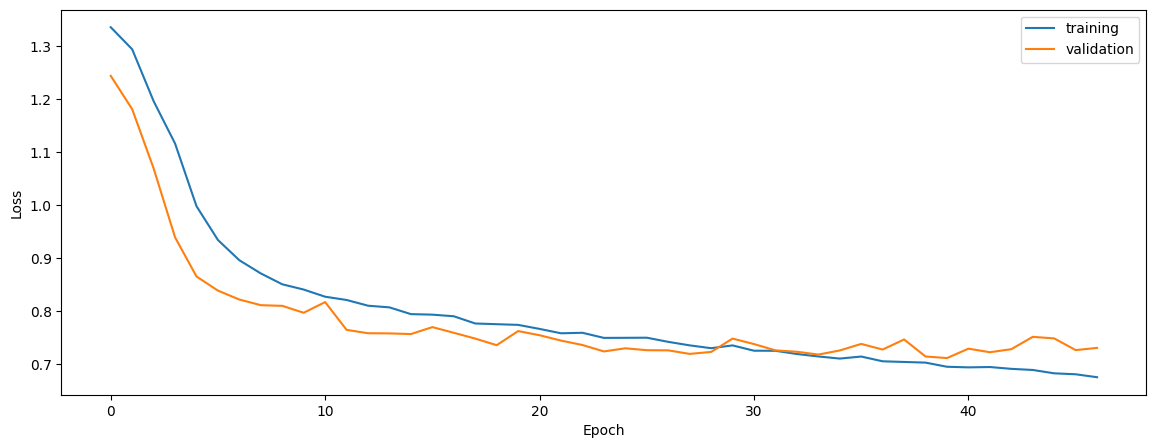

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


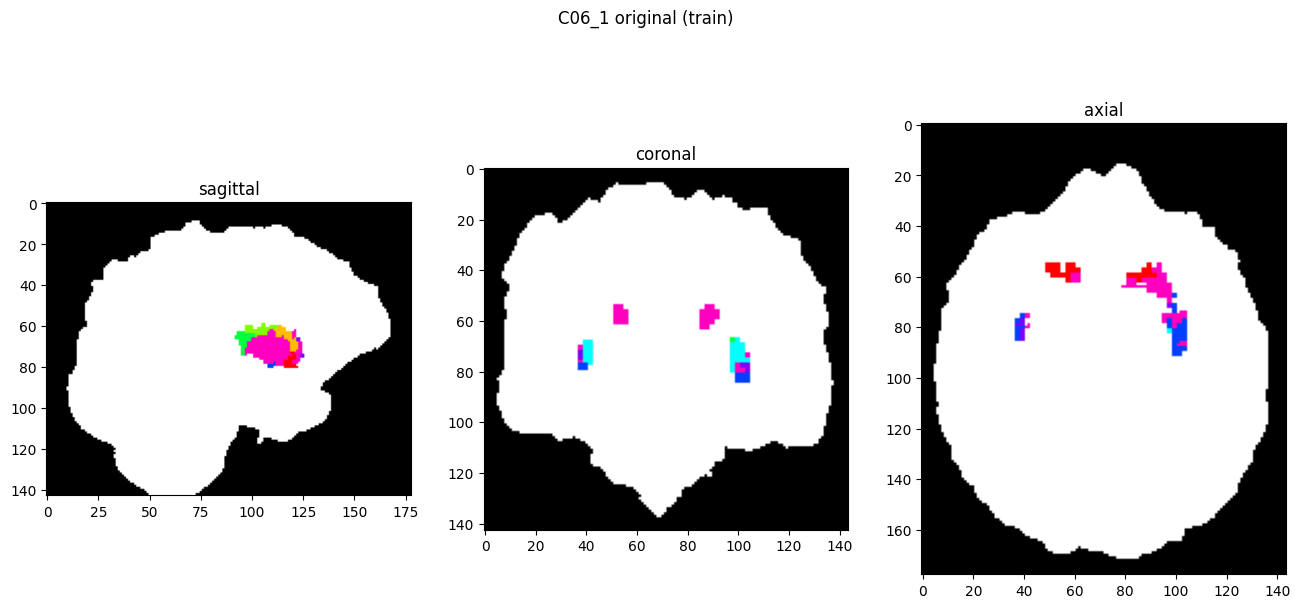

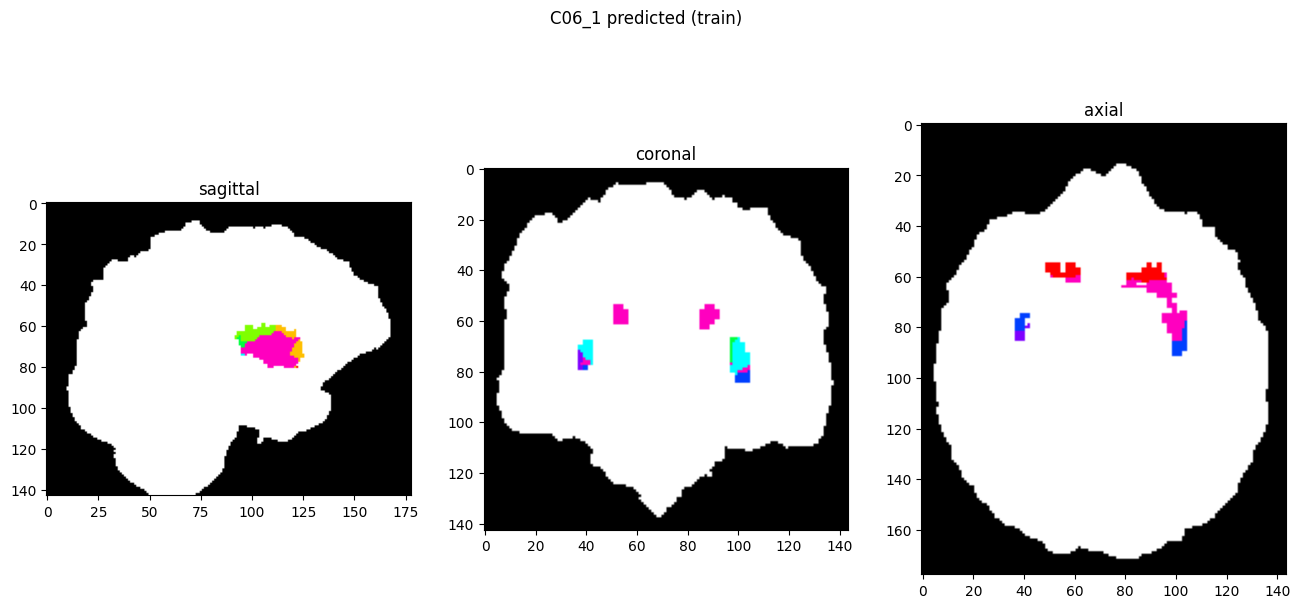

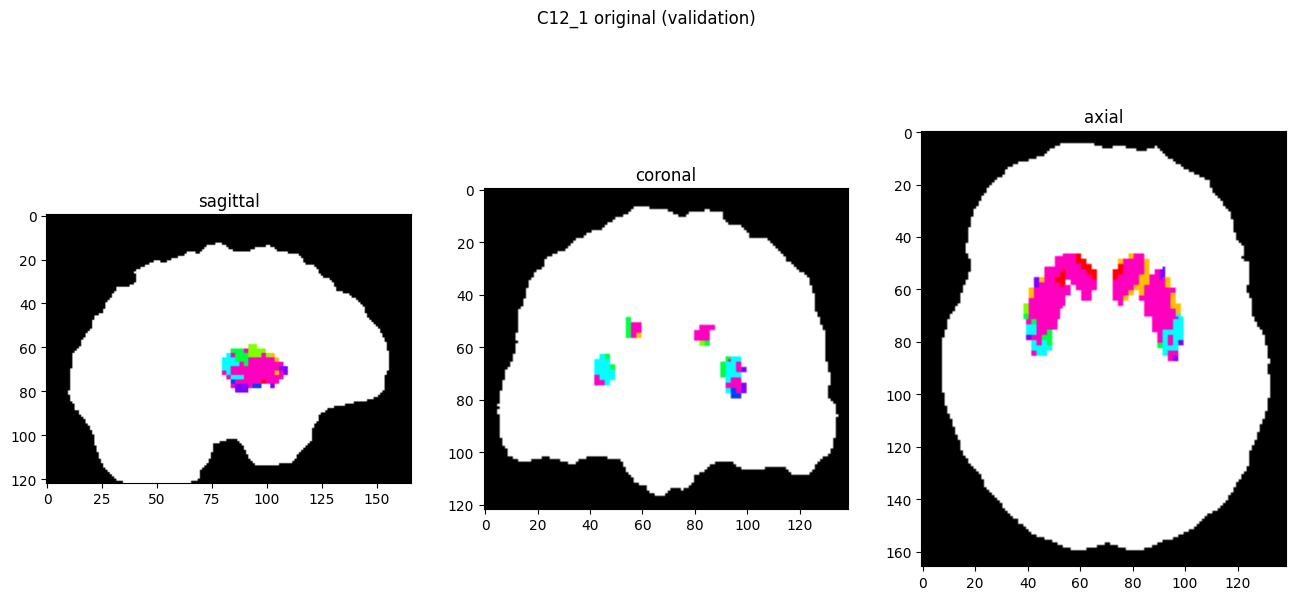

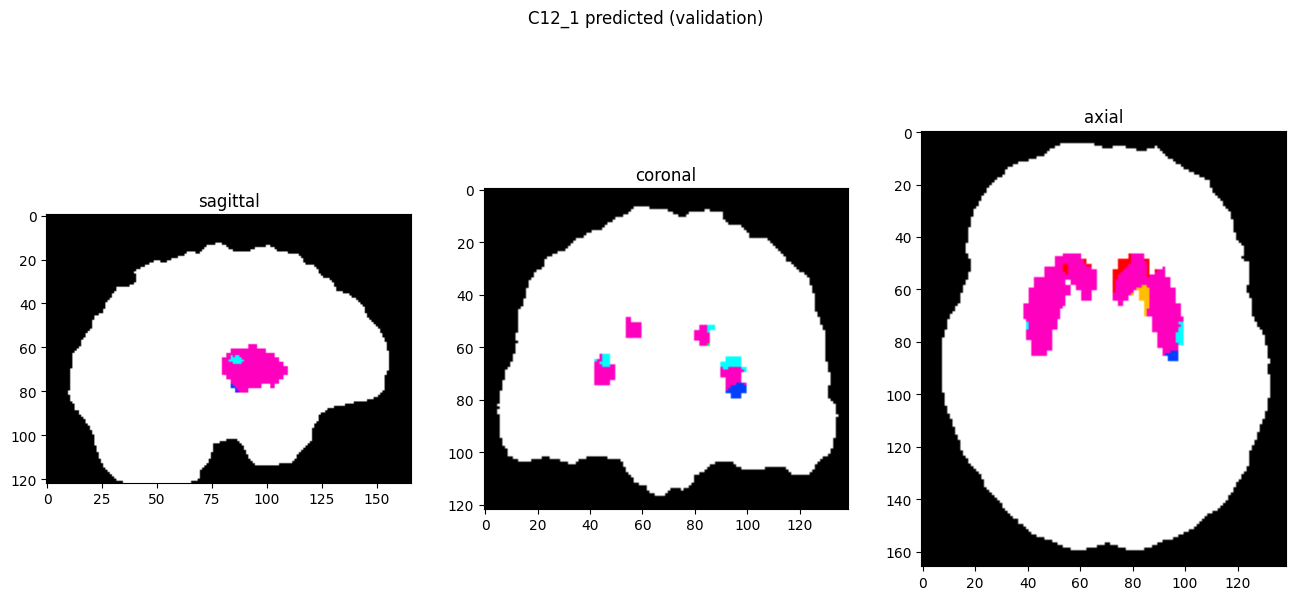

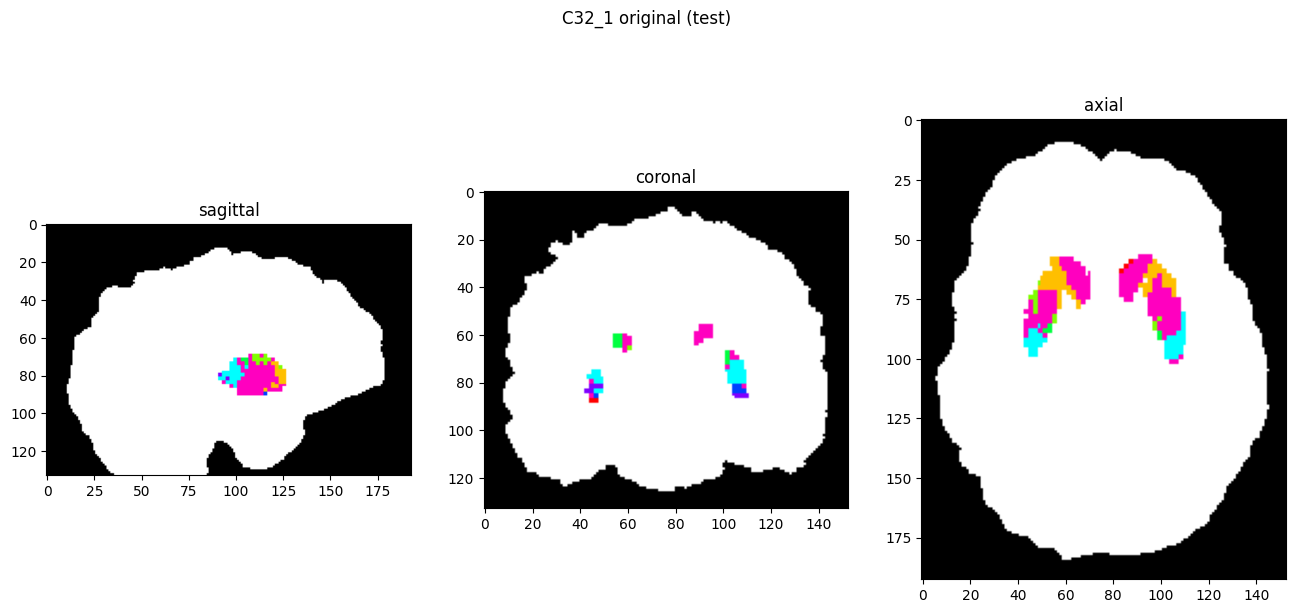

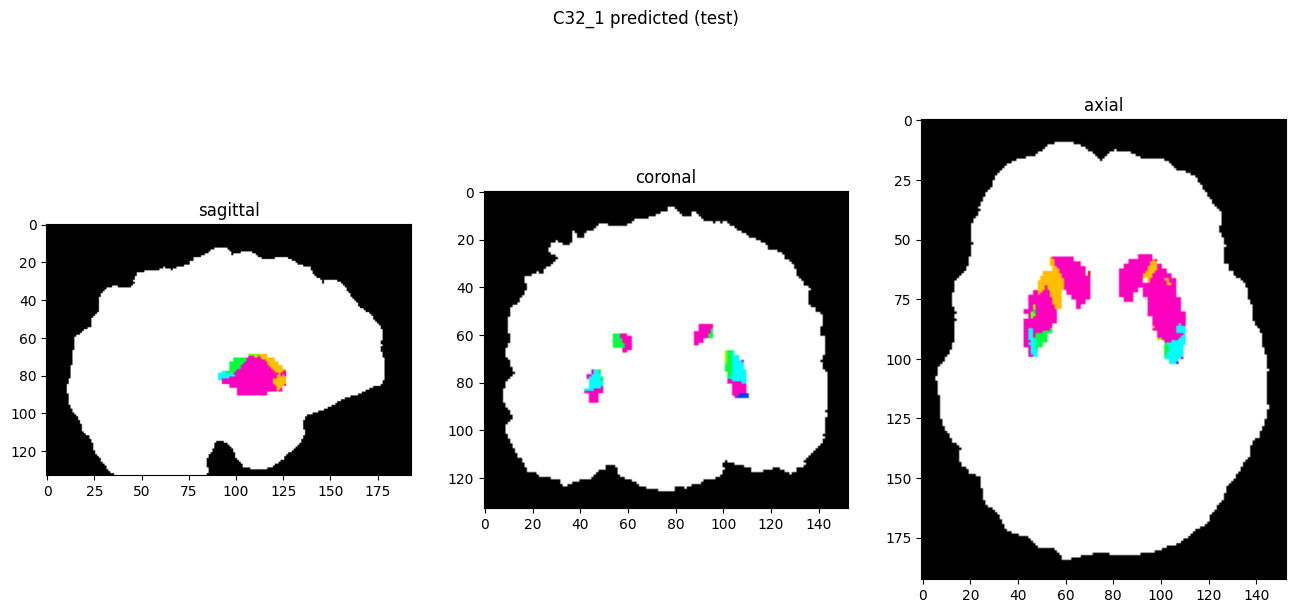

In [10]:
showResults(model, gen, threshold=0)